<a href="https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/main/Stable_diffusion_interactive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Stable Diffusion 0.6.5

| Description | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/R3gm/SD_diffusers_interactive?style=social)](https://github.com/R3gm/SD_diffusers_interactive) |


<details>
  <summary><font color=gray>Changes</summary>

```diff
  - Utilities for image to video
  - New upscalers
  - About using inpaint, outpaint and regional control
  - Multiple images for ip apapter
  - Metadata Viewer
  - Custom detector model for adetailer
  - Prompt emphasis variants
  - More image generation metadata
  - Download files options
  - Wildcards and Dynamic Prompts
  - Captioner fixed
  - Schedule Type section
  - Option to specify the ControlNet model for tasks.
  - New preprocessors: ZoeDepth, SegFormer, Depth Anything, TEED, Anyline, and LineartStandard.
  - Face restoration models: CodeFormer, GFPGAN, and RestoreFormer.
  - ControlNet repaint, useful for inpainting and outpainting tasks.
  - New IP adapters for anime-based models.
  - Improved SDXL generation quality with Classic-variant weight
  - Optimization presets
  - Prompt enhancer
  - Image captioning
  - Latent upscaler
  - Perturbed Attention Guidance (PAG).
  - ControlNet union for SDXL
  - Gallery explorer and PNG Info
  - Support SDXL models from civitai (safetensors).
  - IP Adapter with the variants FaceID and Instant-Style.
  - ControlNet optical pattern, tile, recolor for SD1.5 and SDXL
  - New prompt weight options.
  - Fixed download issues (You need `CIVITAI_API_KEY` to download from Civitai).
  - Style prompts.
  - Img2img, inpaint, tile realistic.
  - Hires fix.
  - Support for long prompts weights.
  - T2I Adapter for SDXL.
  - FreeU for all tasks.
  - For better performance, disable the progress bar in settings.
  - Adetailer.
  - Prompt weights: Depending on model and CFG you can weight up to around 1.5 or 1.6 before things start to get weird.
  - Controlnet 1.1 for SD1.5.
  - More functions, more bugs; less than 10 words, more laughs.
```
</details>


**Previous version of the Interactive Stable Diffusion:** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/f8c1ac269ebe8a91a7c78fffe8a9404ba3316387/Stable_diffusion_interactive_notebook.ipynb)



This Google Colab notebook offers a user-friendly interface for generating AI images from text prompts using Stable Diffusion. It uses [Stablepy](https://github.com/R3gm/stablepy) and Jupyter widgets, providing a simple and lightweight alternative to web-based tools, making it accessible for all to `get started with Stable Diffusion`. With Stablepy, you can smoothly apply stable diffusion in Python, enabling seamless integration with any interface.

GUI Based on [redromnon's repository](https://github.com/redromnon/stable-diffusion-interactive-notebook)

In [ ]:
#@title 1. Installing dependencies
%cd /content
def repo_exists(repo_url):
    import requests
    return requests.get(repo_url).status_code == 200

repo_name = "R3gm/SD_diffusers_interactive"
repo_alive = repo_exists(f"https://github.com/{repo_name}")
if repo_alive:
    repo_path = f"https://raw.githubusercontent.com/{repo_name}/refs/heads/main/tool_shed/sd_runes.py"
    !wget -q --show-progress {repo_path}

!apt -y install -qq aria2 rar > /dev/null 2>&1
!pip uninstall ydf grpcio-status thinc tensorflow-decision-forests spacy -y -q > /dev/null 2>&1
!pip install -q stablepy==0.6.5 transformers==4.49.0 thinc==8.3.4 blis==1.2.1 spacy==3.8.7 dynamicprompts==0.31.0 peft==0.17.1

import os
os.kill(os.getpid(), 9)

In [ ]:
#@title 2. Download checkpoints, VAEs, or LoRAs by providing URLs separated with commas. Supported sources: Civitai api link (requires API key), Google Drive, or Hugging Face. { form-width: "20%", display-mode: "form" }
import os
import locale
import requests
from requests.adapters import HTTPAdapter
from urllib3.util import Retry
import urllib.parse
import re
import copy

locale.getpreferredencoding = lambda: "UTF-8"
%cd /content

GLOBAL_DIR = ["models", "loras", "vaes", "embedings", "embedings_xl", "wildcards", "upscalers", "rar_files"]
WILDCARD_DIRECTORY = '/content/wildcards'
directory_models, directory_loras, directory_vaes, directory_embeds, directory_embeds_xl, directory_base_wc, directory_upscalers, rar_folder = GLOBAL_DIR
[os.makedirs(d, exist_ok=True) for d in GLOBAL_DIR]
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:127.0) Gecko/20100101 Firefox/127.0'

def request_json_data(url):
    if "civitai.com" in url:
        model_version_id = url.split('/')[-1]
        if "?modelVersionId=" in model_version_id:
            match = re.search(r'modelVersionId=(\d+)', url)
            model_version_id = match.group(1)
        endpoint_url = f"https://civitai.com/api/v1/model-versions/{model_version_id}"
    else:
        endpoint_url = f"https://civitai.com/api/v1/model-versions/by-hash/{url}"
    headers = {'User-Agent': USER_AGENT, 'content-type': 'application/json'}
    session = requests.Session()
    retries = Retry(total=3, backoff_factor=0.5, status_forcelist=[500, 502, 503, 504])
    session.mount("https://", HTTPAdapter(max_retries=retries))
    result = session.get(endpoint_url, params={}, headers=headers, stream=True, timeout=(3.0, 5))
    result.raise_for_status()
    return result.json()

class ModelInformation:
    def __init__(self, json_data):
        self.original_json = copy.deepcopy(json_data)

        self.model_version_id = json_data.get("id", "")
        self.model_id = json_data.get("modelId", "")
        self.download_url = json_data.get("downloadUrl", "")
        self.model_url = f"https://civitai.com/models/{self.model_id}?modelVersionId={self.model_version_id}"
        self.trainedWords = ", ".join(json_data.get("trainedWords", []))
        self.description = json_data.get("description", "")
        self.baseModel = json_data.get("baseModel", "")
        air = json_data.get("air", "")
        self.arch = self.typem = ""
        if air:
            air = air.upper().split(":")
            self.arch, self.typem = air[2], air[3]
        self.filename_url = next(
            (v.get("name", "") for v in json_data.get("files", []) if str(self.model_version_id) in v.get("downloadUrl", "") and v.get("type", "Model") == "Model"), ""
        )
        self.images = [img.get("url", "") for img in json_data.get("images", [])]

        cdata = [
            f"[Page: {self.model_url}]" if self.model_url else "",
            f"[BaseModel: {self.baseModel}]" if self.baseModel else "",
            f"[Arch: {self.arch}]" if self.arch else "",
            f"[Type: {self.typem}]" if self.typem else "",
            f"[TrainedWords: {self.trainedWords}]" if self.trainedWords else ""
        ]
        extra_data = " ".join(p for p in cdata if p)
        self.info_str = f"{self.filename_url} {extra_data}".strip()

def get_civit_params(url):
    try:
        json_data = request_json_data(url)
        mdc = ModelInformation(json_data)
        if mdc.download_url and mdc.filename_url:
            return mdc.download_url, mdc.filename_url, mdc
        else:
            ValueError("Invalid Civitai model URL or model version ID.")
    except Exception as e:
        print(f"Error retrieving Civitai metadata: {e} — fallback to redirect download")
        return url, None, None

def civ_redirect_down(url, dir_, civitai_api_key, alternative_name):
    filename_base = filename = None

    if alternative_name:
        output_path = os.path.join(dir_, alternative_name)
        if os.path.exists(output_path):
            return output_path, alternative_name

    # Follow the redirect to get the actual download URL
    curl_command = (
        f'curl -L -sI --connect-timeout 5 --max-time 5 '
        f'-H "Content-Type: application/json" '
        f'-H "Authorization: Bearer {civitai_api_key}" "{url}"'
    )

    headers = os.popen(curl_command).read()

    # Look for the redirected "Location" URL
    location_match = re.search(r'location: (.+)', headers, re.IGNORECASE)

    if location_match:
        redirect_url = location_match.group(1).strip()

        # Extract the filename from the redirect URL's "Content-Disposition"
        filename_match = re.search(r'filename%3D%22(.+?)%22', redirect_url)
        if filename_match:
            encoded_filename = filename_match.group(1)
            # Decode the URL-encoded filename
            decoded_filename = urllib.parse.unquote(encoded_filename)

            filename = decoded_filename
            # print(f"Filename redirect: {filename}")

    filename_base = alternative_name if alternative_name else filename
    if not filename_base:
        return None, None
    elif os.path.exists(os.path.join(dir_, filename_base)):
        return os.path.join(dir_, filename_base), filename_base

    !aria2c --console-log-level=error --summary-interval=10 -c -x 16 \
        -k 1M -s 16 -d "{dir_}" -o "{filename_base}" "{redirect_url}"

    output_path = os.path.join(dir_, filename_base)
    if not os.path.exists(output_path):
        return None, filename_base

    return output_path, filename_base

def civ_api_down(url, dir_, civitai_api_key, civ_filename):
    """
    This method is susceptible to being blocked because it generates a lot of temp redirect links with aria2c.
    If an API key limit is reached, generating a new API key and using it can fix the issue.
    """
    output_path = None

    if "?" in url:
      url = url.split("?")[0]

    url_dl = url + f"?token={civitai_api_key}"
    if not civ_filename:
        !aria2c -c -x 1 -s 1 -d "{dir_}" "{url_dl}"
    else:
        output_path = os.path.join(dir_, civ_filename)
        if not os.path.exists(output_path):
            !aria2c --console-log-level=error --summary-interval=10 -c -x 16 \
                -k 1M -s 16 -d "{dir_}" -o "{civ_filename}" "{url_dl}"

    return output_path

def drive_down(url, dir_):
    import gdown

    output_path = None

    drive_id, _ = gdown.parse_url.parse_url(url, warning=False)
    dir_files = os.listdir(dir_)

    for dfile in dir_files:
        if drive_id in dfile:
            output_path = os.path.join(dir_, dfile)
            break

    if not output_path:
        original_path = gdown.download(url, f"{dir_}/", fuzzy=True)

        dir_name, base_name = os.path.split(original_path)
        name, ext = base_name.rsplit(".", 1)
        new_name = f"{name}_{drive_id}.{ext}"
        output_path = os.path.join(dir_name, new_name)

        os.rename(original_path, output_path)

    return output_path

def hf_down(url, dir_, hf_token):
    url = url.replace("?download=true", "")
    # url = urllib.parse.quote(url, safe=':/')  # fix encoding

    filename = url.split('/')[-1]
    output_path = os.path.join(dir_, filename)

    if os.path.exists(output_path):
        return output_path

    if "/blob/" in url:
        url = url.replace("/blob/", "/resolve/")

    if hf_token:
        user_header = f'"Authorization: Bearer {hf_token}"'
        !aria2c --console-log-level=error --summary-interval=10 --header={user_header} \
            -c -x 16 -k 1M -s 16 "{url}" -d "{dir_}" -o "{filename}"
    else:
        !aria2c --optimize-concurrent-downloads --console-log-level=error --summary-interval=10 \
            -c -x 16 -k 1M -s 16 "{url}" -d "{dir_}" -o "{filename}"

    return output_path

def download_things(directory, url, hf_token="", civitai_api_key=""):
    url = url.strip()
    if not url:
        return None

    downloaded_file_path = None

    if "drive.google.com" in url:
        downloaded_file_path = drive_down(url, directory)
    elif "huggingface.co" in url:
        downloaded_file_path = hf_down(url, directory, hf_token)
    elif "civitai.com" in url:
        if not civitai_api_key:
            msg = "You need an API key to download Civitai models."
            print(f"\033[91m{msg}\033[0m")
            return None

        url, civ_filename, civ_info = get_civit_params(url)
        if civ_info and civ_info.info_str:
            print(f"\033[92m{civ_info.info_str}\033[0m")

        downloaded_file_path, civ_filename = civ_redirect_down(url, directory, civitai_api_key, civ_filename)

        if not downloaded_file_path:
            msg = (
                "Download failed.\n"
                "If this is due to an API limit, generating a new API key may resolve the issue.\n"
                "Attempting to download using the old method..."
            )
            print(msg)
            downloaded_file_path = civ_api_down(url, directory, civitai_api_key, civ_filename)
    else:
        !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 \
            -d "{directory}" "{url}"

    return downloaded_file_path

def get_model_list(directory_path):
    model_list = []
    valid_extensions = {'.ckpt' , '.pt', '.pth', '.safetensors', '.bin'}

    for filename in os.listdir(directory_path):
        if os.path.splitext(filename)[1] in valid_extensions:
            name_without_extension = os.path.splitext(filename)[0]
            file_path = os.path.join(directory_path, filename)
            model_list.append((name_without_extension, file_path))
            print('\033[34mFILE: ' + file_path + '\033[0m')
    return model_list

def process_string(input_string):
    parts = input_string.split('/')
    return (parts[-1], input_string)

#@markdown ---
#@markdown - **Download SDXL and SD 1.5 Models**
download_model = "https://huggingface.co/frankjoshua/toonyou_beta6/resolve/main/toonyou_beta6.safetensors, https://civitai.com/api/download/models/456194" # @param {type:"string"}
#@markdown - **Download VAEs**
download_vae = "https://huggingface.co/fp16-guy/anything_kl-f8-anime2_vae-ft-mse-840000-ema-pruned_blessed_clearvae_fp16_cleaned/resolve/main/vae-ft-mse-840000-ema-pruned_fp16.safetensors" # @param {type:"string"}
#@markdown - **Download LoRAs**
download_lora = "https://civitai.com/api/download/models/97655, https://civitai.com/api/download/models/124358" # @param {type:"string"}
#@markdown ---
#@markdown - Also, diffuser format models for SDXL and SD1.5 can be loaded by specifying only the repository name `user/repo_name`. Users such as [John6666](https://huggingface.co/John6666/models) and [digiplay](https://huggingface.co/digiplay/models) convert these models. Note that the diffuser's extension `safetensors` is the only compatible format. These models will only be downloaded the first time you use them.
load_diffusers_format_model = "John6666/cat-tower-noobai-xl-checkpoint-v14-epsilon-pred-sdxl, John6666/cat-tower-noobai-xl-checkpoint-v15vpred-sdxl, Laxhar/noobai-XL-1.1, Laxhar/noobai-XL-Vpred-1.0, John6666/one-obsession-14-24d-sdxl, John6666/nova-anime-xl-il-v90-sdxl, John6666/nova-unreal-xl-v60-sdxl, John6666/nova-orange-xl-re-v10-sdxl, OnomaAIResearch/Illustrious-xl-early-release-v0, Eugeoter/artiwaifu-diffusion-2.0, digiplay/majicMIX_realistic_v7, John6666/t-ponynai3-v51-sdxl, yodayo-ai/kivotos-xl-2.0, Meina/MeinaMix_V11, John6666/ebara-mfcg-pony-mix-v12-sdxl, GraydientPlatformAPI/autism-pony, cagliostrolab/animagine-xl-3.1, cagliostrolab/animagine-xl-4.0" # @param {type:"string"}
#@markdown ---
#@markdown **Civitai API Key** - To `download models from Civitai`, you need to generate an API key in (https://civitai.com/user/account). You also require an account on Civitai for this process.
CIVITAI_API_KEY = ""  # @param {type:"string"}
#@markdown ---
#@markdown **HF TOKEN** - If you need to download your private model from Hugging Face, input your token here.
hf_token = ""  # @param {type:"string"}
#@markdown
#@markdown ---
#@markdown **HF TRANSFER** - can speed up downloads from Hugging Face, but sometimes the downloads might fail.
HF_TRANSFER = True  # @param {type: "boolean"}

if HF_TRANSFER:
    %env HF_HUB_ENABLE_HF_TRANSFER=1
    %env HF_HUB_DISABLE_XET=1
    !pip install hf_transfer -q > /dev/null 2>&1
else:
    if os.environ.get("HF_HUB_ENABLE_HF_TRANSFER") == '1':
        %env HF_HUB_ENABLE_HF_TRANSFER=0
        %env HF_HUB_DISABLE_XET=0

for url in [url.strip() for url in download_model.split(',')]:
    download_things(directory_models, url, hf_token, CIVITAI_API_KEY)
for url in [url.strip() for url in download_vae.split(',')]:
    download_things(directory_vaes, url, hf_token, CIVITAI_API_KEY)
for url in [url.strip() for url in download_lora.split(',')]:
    download_things(directory_loras, url, hf_token, CIVITAI_API_KEY)

URL_EMB = 'https://huggingface.co/embed/negative/resolve/main/'
download_embeds = [
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/resolve/main/bad_prompt.pt',
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/blob/main/bad_prompt_version2.pt',
    'https://huggingface.co/embed/EasyNegative/resolve/main/EasyNegative.safetensors',
    f'{URL_EMB}EasyNegativeV2.safetensors',
    f'{URL_EMB}bad-hands-5.pt',
    f'{URL_EMB}bad-artist.pt',
    f'{URL_EMB}ng_deepnegative_v1_75t.pt',
    f'{URL_EMB}bad-artist-anime.pt',
    f'{URL_EMB}bad-image-v2-39000.pt',
    f'{URL_EMB}verybadimagenegative_v1.3.pt',
    ]
for url_embed in download_embeds:
    download_things(directory_embeds, url_embed, hf_token, CIVITAI_API_KEY)
# negativeXL_D
URL_EMB2 = 'https://huggingface.co/LarryAIDraw/'
download_embeds_xl = [
    f'{URL_EMB2}FastNegative/resolve/main/FastNegative.safetensors',
    f'{URL_EMB2}AissistXLv2/resolve/main/AissistXLv2.safetensors',
    f'{URL_EMB2}eznegativexl/resolve/main/eznegativexl.safetensors',
    f'{URL_EMB2}DeepNegative_xl_v1/resolve/main/DeepNegative_xl_v1.safetensors',
    f'{URL_EMB2}SimplePositiveXLv2/resolve/main/SimplePositiveXLv2.safetensors',
    f'{URL_EMB2}negative_v2_Color_Balance_Calibration_0_8/resolve/main/negative_v2_Color_Balance_Calibration_0_8.safetensors',
    'https://huggingface.co/jiovannip/s17x1_/resolve/d0824689ecaa4eb9558ab26b5bc3b01ea10a175e/negative_v2.safetensors',
    'https://huggingface.co/KirtiKousik/embeddings/resolve/main/zPDXL2-neg.safetensors',
    'https://huggingface.co/KirtiKousik/embeddings/resolve/main/negativeXL_D.safetensors',
    f'{URL_EMB2}unaestheticXL_bp5/resolve/main/unaestheticXL_bp5.safetensors',
    ]
for url_embed in download_embeds_xl:
    download_things(directory_embeds_xl, url_embed, hf_token, CIVITAI_API_KEY)

links_wmc = [
    "https://huggingface.co/Ra92/WILDCARDS/resolve/main/200WildcardsNSFWAnd_v20.zip",
    "https://huggingface.co/iahhnim/iahhnim_wildcards_collection/resolve/main/iahhnim_wildcards_collection.zip",
    # only zip files
]
for url_wc in links_wmc:
    download_things(directory_base_wc, url_wc, hf_token, CIVITAI_API_KEY)
    if "iahhnim_wildcards_collection" in url_wc: # "iahhnim_wildcards_collection/WC-SDVN/2000/*"
        !unzip -q -n -j {directory_base_wc}/{url_wc.split('/')[-1]} "iahhnim_wildcards_collection/etoWildcards_pony_v50/etowildcards5.0/*" "iahhnim_wildcards_collection/WC-SDVN/2000/e621-*" -d {directory_base_wc}
    else:
        !unzip -q -n {directory_base_wc}/{url_wc.split('/')[-1]} -d {directory_base_wc}

# Build list models
embed_list = get_model_list(directory_embeds) + get_model_list(directory_embeds_xl)
model_list = get_model_list(directory_models)
if load_diffusers_format_model.strip():
    if "," in load_diffusers_format_model:
        load_diffusers_format_model = load_diffusers_format_model.split(",")
    if isinstance(load_diffusers_format_model, str):
        load_diffusers_format_model = [load_diffusers_format_model]
    for diff_format in load_diffusers_format_model:
        model_list.append(process_string(diff_format.strip()))
lora_model_list = get_model_list(directory_loras)
lora_model_list.insert(0, ("None",None))
vae_model_list = get_model_list(directory_vaes)
vae_model_list.insert(0, ("BakedVAE", "BakedVAE"))
vae_model_list.insert(0, ("None", None))
print('\033[33m🏁 Download and listing of valid models completed.\033[0m')

from stablepy import Model_Diffusers, UpscalerESRGAN
from stablepy.diffusers_vanilla.inpainting_canvas import draw
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy import scheduler_names, IP_ADAPTERS_SD, IP_ADAPTERS_SDXL, LATENT_UPSCALERS, CONTROLNET_MODEL_IDS, SCHEDULE_TYPE_OPTIONS, SCHEDULE_PREDICTION_TYPE_OPTIONS, TASK_AND_PREPROCESSORS, ALL_BUILTIN_UPSCALERS, FACE_RESTORATION_MODELS, PROMPT_WEIGHT_OPTIONS_PRIORITY
from stablepy.diffusers_vanilla.style_prompt_config import STYLE_NAMES
import torch

URL_UP = 'https://github.com/xinntao/Real-ESRGAN/releases/download/'
upscaler_dict_gui = {
    None : None,
    **{bu: bu for bu in ALL_BUILTIN_UPSCALERS},
    "RealESRNet_x4plus": f"{URL_UP}v0.1.1/RealESRNet_x4plus.pth",
    "4x-UltraSharp": "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "Real-ESRGAN-Anime-finetuning": "https://huggingface.co/danhtran2mind/Real-ESRGAN-Anime-finetuning/resolve/main/Real-ESRGAN-Anime-finetuning.pth",
    "4x_foolhardy_Remacri": "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "NickelbackFS4x": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth",
    "4xNomos8kDAT": "https://huggingface.co/Phips/4xNomos8kDAT/resolve/main/4xNomos8kDAT.safetensors",
    "8x_NMKD-Superscale_150000_G": "https://huggingface.co/lantianhang/8x_NMKD-Superscale_150000_G/resolve/main/8x_NMKD-Superscale_150000_G.pth",
    "4xRealWebPhoto_v4_dat2": "https://huggingface.co/Phips/4xRealWebPhoto_v4_dat2/resolve/main/4xRealWebPhoto_v4.pth",
    "2x-AnimeSharpV4_RCAN": "https://huggingface.co/Kim2091/2x-AnimeSharpV4/resolve/main/2x-AnimeSharpV4_RCAN.safetensors",
    "UltraSharpV2": "https://huggingface.co/Kim2091/UltraSharpV2/resolve/main/4x-UltraSharpV2.safetensors",
}

def extract_parameters(input_string):
    parameters = {}
    input_string = input_string.replace("\n", "")

    if "Negative prompt:" not in input_string:
        if "Steps:" in input_string:
            input_string = input_string.replace("Steps:", "Negative prompt: Steps:")
        else:
            print("Invalid metadata")
            parameters["prompt"] = input_string
            return parameters

    parm = input_string.split("Negative prompt:")
    parameters["prompt"] = parm[0].strip()
    if "Steps:" not in parm[1]:
        print("Steps not detected")
        parameters["neg_prompt"] = parm[1].strip()
        return parameters
    parm = parm[1].split("Steps:")
    parameters["neg_prompt"] = parm[0].strip()
    input_string = "Steps:" + parm[1]

    steps_match = re.search(r'Steps: (\d+)', input_string)
    if steps_match:
        parameters['Steps'] = int(steps_match.group(1))

    size_match = re.search(r'Size: (\d+x\d+)', input_string)
    if size_match:
        parameters['Size'] = size_match.group(1)
        width, height = map(int, parameters['Size'].split('x'))
        parameters['width'] = width
        parameters['height'] = height

    other_parameters = re.findall(r'([^,:]+): (.*?)(?=, [^,:]+:|$)', input_string)
    for param in other_parameters:
        parameters[param[0].strip()] = param[1].strip('"')

    return parameters

p_w_options = [(pwf, pwf) for pwf in PROMPT_WEIGHT_OPTIONS_PRIORITY]
p_w_options[0] = ("Classic format: (word:weight)", "Classic")
p_w_options[1] = ("Compel format: (word)weight", "Compel")

<font color='blue'>**How to Get the Civitai API URL of Your Model/LoRA/VAE:**</font>
<details>
<summary>Click to expand</summary>

**For example, if you want to download Toonyou from Civitai to this notebook, follow these steps to obtain the link for the download:**
1. Navigate to your model's URL: Go to the link for your model, LoRA, or VAE. For instance: https://civitai.com/models/30240/toonyou
2. Left-click on the download button and copy the link.

image.png

3. You will receive a link that looks like this:
`https://civitai.com/api/download/models/125771?type=Model&format=SafeTensor&size=pruned&fp=fp16`
4. We only need the part before the "?", so your final link will be:
`https://civitai.com/api/download/models/125771`
5. Make sure to set your Civitai API key in the downloads. You can then copy this link to the appropriate location, whether it’s for a model, LoRA, or VAE.

**Note**: Some models on Civitai may not display the download button. In such cases, look for a dropdown on the right side labeled "1 File" to find the file download button and copy the link.

</details>




<font color='blue'>**Utility:**</font>
<details>
<summary>Click to expand</summary>

- [![Custom Badge](https://img.shields.io/badge/DiffuseCraft-red?style=for-the-badge)](https://huggingface.co/spaces/r3gm/DiffuseCraft) In Hugging Face, you can load a diffusers format model by writing the repo ID in the 'Model' section. Check the 'Examples' in that GUI.

- [![Custom Badge](https://img.shields.io/badge/WAMU-v2-red?style=for-the-badge)](https://huggingface.co/spaces/r3gm/wan2-2-fp8da-aoti-preview) Use this space to animate your images.
Just enter a natural-language prompt describing what you want.

- [![Custom Badge](https://img.shields.io/badge/SDXL_SD15_checkpoint_to_Diffusers_v3-blue)](https://huggingface.co/spaces/John6666/sdxl-to-diffusers-v3)

- [![Custom Badge](https://img.shields.io/badge/civitai_to_huggingface_uploader-blue)](https://huggingface.co/spaces/John6666/civitai_to_hf)

- [![Custom Badge](https://img.shields.io/badge/multi_image_tagger-blue)](https://huggingface.co/spaces/John6666/danbooru-tags-transformer-v2-with-wd-tagger)

- [![Custom Badge](https://img.shields.io/badge/character_prompt_generator-blue)](https://huggingface.co/spaces/r3gm/character_prompt_generator) is designed to filter image tags so that only those relevant to a character's appearance are kept. The filters can be adjusted, for example, to select only tags related to clothing or facial expressions.

- `About ZeroGPU Limits`: Some Hugging Face Spaces run on **ZeroGPU**, which means they have **limited daily usage**.

    If you’re a **free user**, you must:

    1. **Log in** to your Hugging Face account.  
    2. **Join one of these organizations:**  
      - https://huggingface.co/LeRobot-worldwide-hackathon  
      - https://huggingface.co/nerdyface  

    Joining either organization gives you an **x8 ZeroGPU quota**, which provides **about 25 minutes of usage per day**.

- If you’re using a mobile device, you can create your inpaint mask using this [space](https://huggingface.co/spaces/r3gm/inpaint-mask-maker). Then, upload both the image and the mask to Colab, and specify their paths in the GUI.

- In the GUI, the `save_and_load_config` option saves all the parameters used in the last generation. If you run the cell again, it will reload the same parameters so you don’t have to enter them again. The data is saved in `/content/config_load.json`, which you can download an reuse later.


</details>




<font color='red'>**Common issues and potential solutions:**</font>
<details>
<summary>Click to expand</summary>

- **Black image output**: This problem happens when a tensor reaches a certain value and "explodes". To prevent this, avoid using high weights with LoRAs or IP Adapter. FreeU can also worsen the issue. A common fix is to use more stable VAE. For SDXL, you don't need to specify a VAE because the most stable one `madebyollin/sdxl-vae-fp16-fix`, automatically loads for execution.

- **Distorted or very strange images**: This usually occurs due to prompt weight. In this implementation, the emphasis level set using Compel or Classic is particularly sensitive. It's best to use low prompt weights. Similarly, for LoRAs, it's recommended to use low scales. Also, using Classic variants like Classic-original can help; It has a normalization method to avoid extreme peaks that can greatly distort the outcome.

- **Pony Diffusion not producing good images**: Compatibility with the model can be tricky. However, you can try using sampler DPM++ 1s or DPM2 with Compel or Classic prompt weights to improve results.

- **Image resolution**: Please note that if you use a 'TASK' other than 'txt2img,' the 'Width' and 'Height' will be set proportionally according to the 'Image resolution' setting in the GUI.


</details>




---
- **Prompt** - Tell the model what you want to see.
- **Negative Prompt** - Tell the model what you don't want to see.
- **Steps** - How long the model should work on the image.
- **CFG** - Controls how much the image generation process follows the text prompt.  Guidance scale ranging from 0 to 20. Lower values allow the AI to be more creative and less strict at following the prompt. Default is 7.5
- **Sampler** - Progressively reduce image noise through denoising steps.
- **Seed** -  A number that helps the model start generating the image. Set `-1` for using random seed values.
- **Clip Skip** - It allows to control the level of detail and accuracy in the generated images by skipping certain layers of the CLIP model during the image generation process.
- **Prompt weights and emphasis** -  Helps the model focus on different parts of the prompt. Prompt weights can be used to emphasize or de-emphasize certain aspects of the image, such as the object, the scene, or the style. Currently the A1111 format (`Classic`) is used: `(word:1.1)` or `(word)`. And the [Compel syntax](https://github.com/damian0815/compel/blob/main/doc/syntax.md) corresponding to `(word)1.1` or `(word)+`. This option can be changed in the `Prompt emphasis` dropdown.
- **Embeddings** - Help the model to adapt to a particular style.
- **FreeU** - Is a method that substantially improves diffusion model sample quality at no costs.
- **PAG scale** - PAG enhances image quality and is typically set to 3.0, which can be effective in some cases.
- **VAE** - Each model has a default VAE, but we can change it for another one to obtain different results. During inference, the VAE decoder is responsible for converting the denoised image (latent space) into images. In the GUI, leaving it as 'None' will use the model's default VAE. If you’re going to use it, make sure it’s a VAE appropriate for the type of model you’re working with, whether it’s for SD1.5 or SDXL.
- **ControlNet** - Enhances text-to-image diffusion models by allowing various spatial contexts to serve as additional conditioning, enabling the generation of more controlled and context-aware images. The right column contains all the specific ControlNet options.
- **Inpaint** - Is a technique for filling parts of an image by using a diffusion model to generate new pixels based on the surrounding pixels. It can be used to repair damaged photos, remove unwanted objects from images, and even create new images by combining multiple images. To use this option more easily, use the cell 'Upload an image here for use in Inpainting or ControlNet', check 'Create_mask_for_Inpaint,' and run the cell to upload an image to create a mask of the image with the mouse; Or alternatively, use the space [inpaint-mask-maker](https://huggingface.co/spaces/r3gm/inpaint-mask-maker) and then submit the image and mask to the colab
- **Outpaint** - lets you extend the image beyond its original border, in this notebook is compatible but requires a special mask, which can be created in [outpaint-mask-maker](https://huggingface.co/spaces/r3gm/outpaint-mask-maker). Then, submit the resulting padded image and mask to the Colab. You need to set the `TASK` to `repaint` with `Strength` `1.0`.
- **Adetailer** - Adetailer automates inpainting and fixing common issues. It is advisable to set "Inpaint strength" to values lower than 0.4 for better results.
- **LCM and TCD** - Latent Consistency Models (LCM) can generate images in a few steps. When selecting the 'LCM Auto-Loader' or 'TCD Auto-Loader' sampler, the model automatically loads the LoRA for the task. Generally, guidance_scale is used at 1.0 or a maximum of 2.0, with steps between 4 and 8. It is also compatible with other types of LoRA optimization, such as Hyper.
- **img2img** - Is a feature that allows you to modify an existing image based on a text prompt. This means that you can take an image and use the model to change its style, content, or composition.
- **Styles** - These are additions to the prompt and negative prompt to utilize a specific style in generation.
- **IP-Adapter** - This lets you use an image as part of your prompt to guide the generation. In simple terms, you can send an image to help the model follow its look, style, specific person, or identity. You can use multiple images or masks by separating them with commas, like `image1.png, image2.png`
    Most ip models are trained on real-world images, so they work best for realistic results, and not all of them handle masks well.
    For IP-Adapter with SDXL models:
    - For realistic things, **plus_face** works well with masks.
    - For illustrations or anime-style images, **noob-ipa_vit_G** works with masks and preserves a character’s appearance. **noob-ipa** and **ipa_anime** preserve alternative details like clothing, color or poses. **noob-stylize_vit_G** transfer the drawing style.
- **Regional control** (for multiple characters in one image) - A common issue with these models is that when you try to generate multiple characters in the same image, they often merge together or lose their distinct features. While this notebook doesn’t support automatic regional prompting, you can try some manual approaches:

    1. **Use models that handle multiple characters better**  
      Some models, like **catTowerNoobaiXL_v14EpsilonPred**, can represent multiple characters more effectively, though some blending may still occur.

    2. **Manual fix with inpainting**  
      Generate an image containing all characters, then create a mask over one character and use **inpaint** or **repaint** task with that character’s prompt to replace or refine that area.

    3. **IP-Adapter regional masks**  
      Prepare separate images of each character along with their corresponding masks (both masks should have the same aspect ratio).  
      In the GUI, if you are using the `txt2img` task, adjust the **Width** and **Height** to align with the same aspect ratio as the masks.  
      Specify the paths to these images and masks in the IP-Adapter tab, recommended to use IP-Adapter models such as **noob-ipa_vit_G** or **plus_face** for better mask alignment and definition.

- **High-resolution** - It allows you to proportionally increase the size of your images and correct some imperfections in them.
- **Prompt enhancer** - Automatically adjusts prompts by adding relevant quality tags or elaborating on the main idea.
- **Wildcards and Dynamic Prompts Syntax** - lets you create flexible, varied prompt templates using a few key features:

    1. Curly braces `{option1|option2}` for random selection
    2. Ranges like `{2$$option1|option2|option3}` to select multiple variants at once  
    3. Double-underscore wildcards like `__filename__` to pull random lines from your wildcard files  

    For a guide on the syntax, see the [syntax guide](https://github.com/adieyal/dynamicprompts/blob/main/docs/SYNTAX.md).

    You can activate this option in the **Settings** tab, under **WILDCARDS & DYNAMIC PROMPTS**.

    If you use a `Variable parameter`, type `DYNAMIC` in `Filename pattern` to save images using the variable's name.

- **Store and Download Generated Images** -
    By default, download links are created using Litterbox (https://litterbox.catbox.moe). To enable this, set `Generate link after this many images` to 1 or higher. Note: Litterbox may block requests if too many links are created in a short time.
  - Hugging Face Upload: Alternatively, you can save files to your Hugging Face account. In the `HF Params` field, enter your details in this format (values separated by |): `hf_xxxxxxxx|username|private_repo_name`. If the repository does not exist, it will be created automatically.
  - RAR Compression (Optional):You can set a password in the `RAR password` field and the images will be compressed into a .rar file instead of processing them individually. The number of images in the rar depends on the `Generate link after this many images` value and finally, a download link for the RAR file will be generated. If you use `HF Params`, you can specify the name of the RAR file in addition to the parameters `HF Params` by adding `|myrarname`.
  - `Numbered Range`: Use this feature to specify a range of generated images that should be compressed into a RAR file and generate a download link.
  - Extra option: Enable `Auto-download for saved images` this option to automatically download the generated images when the generation process is complete.
- **Face restoration** - Restores realistic facial details, reducing imperfections for natural results
- **Optimization presets** - Pre-defined configurations that optimize image generation for different scenarios. These presets can speed up the generation process or, in some cases, improve image quality. Using these presets is optional.
- 🎲 - Set a random seed.
- ↙️ - It allows you to use Generation Data and set the parameters in the GUI, currently only available for some specific parameters.
- 🗑️ - Clear prompt and negative prompt.
- 🔼🔽 - Resolution presets
---

In [ ]:
#@title 3. GUI { form-width: "20%", display-mode: "form" }
save_and_load_config = True #@param {type:"boolean"}
portrait_view = False #@param {type:"boolean"}
%cd /content
from google.colab import output, files
output.disable_custom_widget_manager()
output.no_vertical_scroll()
import ipywidgets as wd
from ipywidgets import HBox as HB, VBox as VB, Label as sbt
import mediapy, random, logging, time, json, uuid, re
from PIL import Image
from IPython.display import display
from IPython.utils import capture
logging.getLogger("diffusers").setLevel(logging.ERROR)
import diffusers
diffusers.utils.logging.set_verbosity(40)
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=FutureWarning, module="transformers")
warnings.filterwarnings("ignore")
from stablepy import logger
from ipywidgets import TwoByTwoLayout, Layout, interactive
import gc, base64, copy, requests
from dynamicprompts.generators import RandomPromptGenerator, CombinatorialPromptGenerator
from dynamicprompts.wildcards.wildcard_manager import WildcardManager
from IPython import display as _display
from IPython import get_ipython as _get_ipython
from datetime import datetime
from huggingface_hub import HfApi
from huggingface_hub.utils import disable_progress_bars, enable_progress_bars

class Litterbox:
    API = "https://litterbox.catbox.moe/resources/internals/api.php"
    TIMES = {"1h", "12h", "24h", "72h"}

    def __init__(self, expire="24h"):
        if expire not in self.TIMES:
            print(f"Invalid expire time: {expire}, set to 1 hour")
            expire = "1h"
        self.expire = expire

    def upload_file(self, path):
        def try_upload():
            with open(path, "rb") as f:
                r = requests.post(self.API, files={"fileToUpload": f}, data={
                    "reqtype": "fileupload",
                    "time": self.expire
                })
            r.raise_for_status()
            if r.text.startswith("https://"):
                return r.text.strip()
            raise RuntimeError(f"Bad response: {r.text}")

        try:
            return try_upload()
        except Exception as e:
            print(f"Upload failed: {e}, retrying in 5 seconds...")
            time.sleep(5)
            return try_upload()

def parse_hf_string(ss: str, default_rar="compressed_images"):
    parts = ss.strip().split("|")
    if len(parts) < 3:
        raise ValueError(f"Missing required fields: expected format is hf_token|username|repository, but got: {ss}")

    token = parts[0].strip()
    username = parts[1].strip()
    reponame = parts[2].strip()
    rarfilename = parts[3].strip() if len(parts) > 3 and parts[3].strip() else default_rar
    return token, username, reponame, rarfilename

class HFUpload():
    def __init__(self, api_params: str):
        self.token, self.username, self.reponame, self.rarfilename = parse_hf_string(api_params)
        self.api = HfApi()
        self.api.create_repo(
            repo_id=self.reponame,
            repo_type="model",
            private=True,
            exist_ok=True,
            token=self.token,
        )
        self.api_params = api_params

    def upload_file(self, path):
        base = os.path.basename(path)
        if base.lower().endswith('.rar'):
            base = base.replace("compressed_images", self.rarfilename)
        disable_progress_bars()
        self.api.upload_file(
            path_or_fileobj=path,
            path_in_repo=base,
            repo_id=f"{self.username}/{self.reponame}",
            token=self.token,
            repo_type="model",
        )
        enable_progress_bars()
        hf_url = f"https://huggingface.co/{self.username}/{self.reponame}/resolve/main/{base}"
        return hf_url

def download_fix_colab(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f'Cannot find file: {filename}')

    comm_manager = _get_ipython().kernel.comm_manager
    comm_id = 'download_' + str(uuid.uuid4())

    def download_file(comm, _):
        f = open(filename, mode='rb')
        def on_message(_):
            chunk = f.read(1024 * 1024)
            if chunk:
                comm.send({}, None, [chunk])
            else:
                comm.close()
                f.close()
                comm_manager.unregister_target(comm_id, download_file)
        comm.on_msg(on_message)

    comm_manager.register_target(comm_id, download_file)

    safe_var_name = re.sub(r'\W|^(?=\d)', '_', os.path.basename(filename))

    js_code = f"""
    if (!window._download_started_{safe_var_name}) {{
      window._download_started_{safe_var_name} = true;

      async function download(id, filename) {{
        if (!google.colab.kernel.accessAllowed) return;

        const buffers = [];
        const channel = await google.colab.kernel.comms.open(id);
        channel.send({{}});

        for await (const message of channel.messages) {{
          channel.send({{}});
          if (message.buffers) {{
            for (const buffer of message.buffers) {{
              buffers.push(buffer);
            }}
          }}
        }}

        const blob = new Blob(buffers, {{type: 'application/octet-stream'}});
        const a = document.createElement('a');
        a.href = window.URL.createObjectURL(blob);
        a.download = filename;
        a.click();
      }}

      download({json.dumps(comm_id)}, {json.dumps(os.path.basename(filename))});
    }}
    """

    _display.display(_display.Javascript(js_code))

def stretch_list(_short, target_len):
    stretched = []
    count = target_len / len(_short)
    for i, val in enumerate(_short):
        start = round(i * count)
        end = round((i + 1) * count)
        stretched.extend([val] * (end - start))
    return stretched

WM_RANDOM = "Random"
WM_SHUFFE = "Shuffled"
WM_COMBINATORIAL = "Sequential Combinations"
WM_PROGRESIVE = "Progressive Repeats"
WM_TYPES = [WM_RANDOM, WM_SHUFFE, WM_COMBINATORIAL, WM_PROGRESIVE]

def gen_dyn_prompts(
    wm_generator_type,
    wmanager,
    wm_prompt,
    wm_max_prompts,
    wm_combinatorial_start=1
):
    start_index = wm_combinatorial_start - 1

    if wm_generator_type in [WM_COMBINATORIAL, WM_PROGRESIVE]:
        wm_dynamic_generator = CombinatorialPromptGenerator(wmanager)
    else:
        wm_dynamic_generator = RandomPromptGenerator(wmanager)

    prompt_pool = wm_dynamic_generator.generate(
        wm_prompt,
        num_images=(wm_max_prompts if wm_generator_type != WM_SHUFFE else 1000)
    )

    if not prompt_pool:
        return [""]

    if wm_generator_type == WM_SHUFFE:
        prompt_pool = list(set(prompt_pool))
        random.shuffle(prompt_pool)
    elif wm_generator_type == WM_PROGRESIVE:
        prompt_pool = stretch_list(prompt_pool, wm_max_prompts)

    if wm_max_prompts < len(prompt_pool):  # Limit prompts
        prompt_pool = prompt_pool[:wm_max_prompts]

    if wm_generator_type == WM_COMBINATORIAL:  # Handle index
        if start_index > 0:
            if start_index >= len(prompt_pool):
                raise ValueError("The selected prompt number is too high — there aren’t that many prompt combinations.")
            print(f"Starting with prompt number {wm_combinatorial_start} from the available combinations.")
            prompt_pool = prompt_pool[start_index:]
    elif wm_max_prompts > len(prompt_pool):  # Repeat to fill limit
        repeats = (wm_max_prompts + len(prompt_pool) - 1) // len(prompt_pool)
        prompt_pool = (prompt_pool * repeats)[:wm_max_prompts]

    return prompt_pool

def make_string_fancy(text):
    return base64.b64encode(text.encode()).decode()
def make_string_normal(fancy_text):
    return base64.b64decode(fancy_text).decode()

#PARAMETER WIDGETS
width = "225px"
width_up = "300px"
width_pe = "450px"
auto_ly = wd.Layout(height='auto', width='auto')
lora_layout = {'width':'165px'}
lora_scale_layout = {'width':'50px'}
style = {'description_width': 'initial'} # show full text
def hidl(): return wd.Layout(visibility='hidden')
def widl(): return wd.Layout(width=width)
def widu(): return wd.Layout(width=width_up)
def widm(): return wd.Layout(width=width_pe)

try:
    from sd_runes import *
except:
    print("sd_runes.py not found, using default values.")
    DIFFUSERS_CONTROLNET_MODEL = ["Automatic","r3gm/controlnet-union-promax-sdxl-fp16"]
    OPTIMIZATION_PARAMS = {
        "None": [30, 7.5, 'DPM++ 2M', 'None', 'None', '', "", ""],
        "DMD2 4step": [4, 0., 'LCM', '', 'dmd2_sdxl_4step_lora_fp16.safetensors', '', '', 'https://huggingface.co/tianweiy/DMD2/resolve/main/dmd2_sdxl_4step_lora_fp16.safetensors'],
        "TCD": [8, 0., 'TCD Auto-Loader', '', "", "", "", ""],
    }
    VALID_OPTI_LORA = list(OPTIMIZATION_PARAMS.keys())[1:2]
    MODELS_PROMPT_ENHANCER = [
        "None",
        "T5 flux",
    ]
    QUALITY_PROMPT_LIST = [
        {
            "name": "None",
            "prompt": [],
            "negative_prompt": [],
        },
        {
            "name": "Common",
            "prompt": ['(masterpiece)', '(best quality)', '(ultra-detailed)', 'intricate details'],
            "negative_prompt": ['longbody', 'lowres', 'bad anatomy', 'bad hands', 'missing fingers', 'pubic hair', 'extra digit', 'fewer digits', 'worst quality', 'low quality', 'very displeasing', '(bad)'],
        },
    ]
    AVAILABLE_PREFIX_LIST = []
    all_original_resolutions = [[1152, 896], [1216, 832], [1344, 768], [1920, 1080]]
    ratios = [2/3, 3/4, 16/9]

MDL_ENH = MODELS_PROMPT_ENHANCER
control_model_list = job_lst = list(CONTROLNET_MODEL_IDS.keys())
POST_PROCESSING_SAMPLER = ["Use same sampler"] + [
    n for n in scheduler_names if "Auto-Loader" not in n
]

class OptimPreset():
    def __init__(self):
        self.default_params = None

    def set_optimization(self, opt, steps_gui, cfg_gui, sampler_gui, lora_gui, lora_scale_gui, scheduler_gui):
        if not opt in list(OPTIMIZATION_PARAMS.keys()): opt = "None"
        if self.default_params is None:
            self.default_params = [steps_gui, cfg_gui, sampler_gui, lora_gui, lora_scale_gui, scheduler_gui]

        if opt == "None":
            if self.default_params[3] in VALID_OPTI_LORA:
                self.default_params[3] = None
            normal_params = self.default_params
            self.default_params = None
            return *normal_params,

        def_steps_gui = 30
        def_cfg_gui = 7.
        steps = OPTIMIZATION_PARAMS.get(opt, None)[0]
        cfg = OPTIMIZATION_PARAMS.get(opt, None)[1]
        sampler = OPTIMIZATION_PARAMS.get(opt, None)[2]
        scheduler = OPTIMIZATION_PARAMS.get(opt, None)[5]
        lora_scale = 1.

        if opt in VALID_OPTI_LORA:
            lora = opt
        elif "Auto-Loader" in sampler:
            lora = lora_gui if lora_gui not in VALID_OPTI_LORA else None
            lora_scale = lora_scale_gui
        else:
            lora = lora_gui
            lora_scale = lora_scale_gui

        return steps, cfg, sampler, lora, lora_scale, scheduler

    def class_optimization_lora_path(self, lora_gui7, modelq):
        opt_lora_name = ""

        if lora_gui7 in VALID_OPTI_LORA:
            params_opt = OPTIMIZATION_PARAMS.get(lora_gui7, None)
            if modelq.class_name == "StableDiffusionPipeline":
                download_opt_lora = params_opt[6]
                opt_lora_name = params_opt[3]
            elif modelq.class_name == "StableDiffusionXLPipeline":
                download_opt_lora = params_opt[7]
                opt_lora_name = params_opt[4]
            else:
                print("No valid class_name")

            if not opt_lora_name:
                print(
                    "This optimization method is missing some key "
                    "components needed for this model."
                )
            elif "/" in opt_lora_name:
                pass  # Diffusers lora
            elif os.path.exists(f"./loras/{opt_lora_name}"):
                opt_lora_name = f"./loras/{opt_lora_name}"
            elif not os.path.exists(f"./loras/{opt_lora_name}"):
                download_things(directory_loras, download_opt_lora, hf_token, CIVITAI_API_KEY)
                opt_lora_name = "./loras/" + opt_lora_name if opt_lora_name else None
            return opt_lora_name
        else:
            return lora_gui7

try:
    opt_preset_main
except:
    opt_preset_main = OptimPreset()

def drop_wd(vod, pod, layout=auto_ly, expand_style=True):
    return wd.Dropdown(
        options=vod,
        value=vod[0][1] if isinstance(vod[0], tuple) else vod[0],
        description=pod+":",
        layout=layout,
        style=style if expand_style else {},
    )
opti_method_opt = drop_wd(list(OPTIMIZATION_PARAMS.keys()), "Optimization presets")

def opti_update_options(option_):
    opti_presets = opt_preset_main.set_optimization(option_, steps.value, CFG.value, select_sampler.value, select_lora7.value, lora_weights_scale7.value, select_scheduler.value)

    steps.value = opti_presets[0]
    CFG.value = opti_presets[1]
    select_sampler.value = opti_presets[2]
    select_lora7.value = opti_presets[3]
    lora_weights_scale7.value = opti_presets[4]
    if opti_presets[5]:
        select_scheduler.value = opti_presets[5]

interactive(opti_update_options, option_=opti_method_opt)

# ==Left==
def int_wd_(v, steps, min, max, title):
    return wd.BoundedIntText(value=v, min=min, max=max, step=steps, description=f"{title}:", layout=widl())
def float_wd(v, steps, min, max, title, expand_style=True, layout=widl()):
    return wd.BoundedFloatText(value=v, min=min, max=max, step=steps, description=title+":", layout=layout, style=style if expand_style else {})
num_images = int_wd_(1, 1, 1, 500, "Images")
steps = int_wd_(30, 1, 1, 150, "Steps")
CFG = float_wd(7.5, 0.5, 0, 30, "CFG", False)
select_sampler = drop_wd(scheduler_names, "Sampler", widl(), False)
select_scheduler = drop_wd(SCHEDULE_TYPE_OPTIONS, "Scheduler", widl(), False)
def compact_int_wd(v, steps, min, max, title):
    return wd.BoundedIntText(value=v, min=min, max=max, step=steps, description=f"{title}:", layout={'width':'107px'}, style=style)
img_height = compact_int_wd(512, 8, 64, 4096, "Height")
img_width = compact_int_wd(512, 8, 64, 4096, "Width")
pag_scale = float_wd(0.0, 0.1, 0.0, 10.0, "PAG scale", False)
random_seed = wd.IntText(
    value=-1,
    description="Seed:",
    layout=wd.Layout(width="195px"),
    disabled=False
)
def emoji_wd(px, title):
    return wd.Button(
        description=title,
        disabled=False,
        layout=wd.Layout(width=px),
        style={'description_width': 'initial', 'button_color': '#97BC62'},
    )
random_seed_button = emoji_wd("20px", "🎲")
def set_random_seed_button(value):
    random_seed.value = -1
    return
random_seed_button.on_click(set_random_seed_button)
def lora_nn_(num):
    return wd.Dropdown(options=lora_model_list, description=f"Lora{str(num)}:", layout=lora_layout)
def lora_scale_():
    return wd.BoundedFloatText(min=-8.0, max=8.0, step=0.01, value=0.75, layout=lora_scale_layout)
select_lora1 = lora_nn_(1)
lora_weights_scale1 = lora_scale_()
select_lora2 = lora_nn_(2)
lora_weights_scale2 = lora_scale_()
select_lora3 = lora_nn_(3)
lora_weights_scale3 = lora_scale_()
select_lora4 = lora_nn_(4)
lora_weights_scale4 = lora_scale_()
select_lora5 = lora_nn_(5)
lora_weights_scale5 = lora_scale_()
select_lora6 = lora_nn_(6)
lora_weights_scale6 = lora_scale_()

select_lora7 = lora_nn_(7)
select_lora7.options = lora_model_list + [(m_opt, m_opt) for m_opt in VALID_OPTI_LORA]
lora_weights_scale7 = lora_scale_()

def s_check_wd(t, v):
    return wd.Checkbox(value=v, description=t, layout=widl())
def check_wd(t, v):
    return wd.Checkbox(value=v, description=t, layout=auto_ly, style=style)
select_clip_skip = check_wd("Layer 2 Clip Skip", True)
freeu_check = check_wd("FreeU", False)

# ==Center==
display_imgs = wd.Output() # layout={'border': '1px solid black'}
select_model = drop_wd(model_list, "Model", auto_ly, False)
vae_model_dropdown = drop_wd(vae_model_list, "VAE", auto_ly, False)

def master_prompts(text):
    return wd.Textarea(
        value="",
        placeholder=text,
        rows=5,
        layout=auto_ly,
    )
prompt = master_prompts("Enter prompt")
neg_prompt = master_prompts("Enter negative prompt")

delete_params_button = emoji_wd("40px", "🗑️")
def delete_params_in_ui(value):
    prompt.value = ""
    neg_prompt.value = ""
    return
delete_params_button.on_click(delete_params_in_ui)

active_ti = wd.Checkbox(
    value=False,
    description='Active Textual Inversion in prompt',
    layout=auto_ly,
)
weights_prompt = drop_wd(p_w_options, "Prompt emphasis")

generate = wd.Button(
    description="Generate",
    disabled=False,
    button_style="primary",
    layout=Layout(height='auto', width='auto'),
    style = {'font_weight': 'bold'}
)

# GENERATE
def check_error(error, pp_params_data=None):
    if (
        "CUDA out of memory. Tried to allocate" in str(error)
        or ": CUBLAS_STATUS_ALLOC_FAILED ; GPU=0" in str(error)
    ):
        print("Error: CUDA out of memory.")
        print("Reason: Your GPU does not have enough memory to allocate for the operation.")
        print("Solution: Restart the runtime to clear the GPU memory.")
        print("After restarting, rerun the 2 (Downloads) and 3 (GUI) cells in this notebook.")
        if save_and_load_config and pp_params_data is not None:
            save_config_params(pp_params_data)
        display(restart_runtime)
        raise RuntimeError(str(error))
    else:
        raise error

extra_msg_status = 0
count_runs = 0
def generate_img(i):

    global model

    if clear_out_auto.value:
        display_imgs.clear_output()
    generate.disabled = True

    with display_imgs:

        print("Loading model...")

        with torch.no_grad():
            try:
                model
            except:
                model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)

            try:
                model.load_pipe(select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)
            except Exception as error:
                check_error(error)

        model.advanced_params(img_prep_cuda.value, partial_cpu_offload.value, disable_embed_cache.value, disable_prepcache.value)

        if clear_out_auto.value:
            display_imgs.clear_output()

        global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config, extra_msg_status

        image_control_base = None
        if select_task.value != job_lst[13]:
            if os.path.exists(img_tsk.value):
                image_control_base = img_tsk.value
            else:
                try:
                    image_control_base = destination_path_cn_img
                except Exception as e:
                    # print(e)
                    print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
                    generate.disabled = False
                    return
            if os.path.isdir(image_control_base):
                import glob
                control_imgf = image_control_base
                _all_files = glob.glob(os.path.join(control_imgf, '**', '*.*'), recursive=True)
                img_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp']
                _all_images = [
                    file for file in _all_files if os.path.splitext(file)[1].lower() in img_extensions
                ]
                image_control_base = sorted(_all_images, key=os.path.basename)
                print(f"Found {len(image_control_base)} images in folder {control_imgf}")

        mask_control_base = ""
        if select_task.value in [job_lst[12], job_lst[23]]:
            if os.path.exists(mask_inpaint_gui.value):
                mask_control_base = mask_inpaint_gui.value
            else:
                try:
                    mask_control_base = mask_control
                except:
                    print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                    generate.disabled = False
                    return

        if "https://" not in str(upscaler_dict_gui[upscale_gui.value]):
            upscaler_model = upscale_gui.value
        else:
            url_upscaler = upscaler_dict_gui[upscale_gui.value]
            download_things(directory_upscalers, url_upscaler, hf_token)
            upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

        if extra_msg_status<3:
            if model.class_name == "StableDiffusionPipeline" and not vae_model_dropdown.value:
                print("It is advisable to use a VAE with SD 1.5, such as 'vae-ft-mse-840000-ema-pruned_fp16'")
                extra_msg_status += 1
            elif model.class_name == "StableDiffusionXLPipeline" and vae_model_dropdown.value and "vae-ft-mse-840000-ema-pruned_fp16" in vae_model_dropdown.value:
                print("The VAE 'vae-ft-mse-840000-ema-pruned_fp16' is for SD 1.5, but you are using SDXL.")
                extra_msg_status += 1
        logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

        count_runs += 1
        if count_runs%11 == 0 and count_runs != 0:
            print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Simple Gallery Explorer', to prevent any inconvenience from disconnection due to inactivity.")

        params_ip_img = []
        params_ip_msk = []
        params_ip_model = []
        params_ip_mode = []
        params_ip_scale = []

        all_adapters = [
            (ipa_img0, ipa_mask0, ipa_model0, ipa_mode0, ipa_scale0),
            (ipa_img1, ipa_mask1, ipa_model1, ipa_mode1, ipa_scale1),
            (ipa_img2, ipa_mask2, ipa_model2, ipa_mode2, ipa_scale2),
        ]

        for imgip, mskip, modelip, modeip, scaleip in all_adapters:
            if imgip.value:
                ip_list = [ipi.strip() for ipi in imgip.value.split(",") if ipi.strip()]
                ipmsk_list = [ipm.strip() for ipm in mskip.value.split(",") if ipm.strip()]
                params_ip_img.append(ip_list)
                params_ip_msk.append(ipmsk_list)
                params_ip_model.append(modelip.value)
                params_ip_mode.append(modeip.value)
                params_ip_scale.append(scaleip.value)

        adetailer_params_A = dict(
            face_detector_ad=face_detector_ad_A.value,
            person_detector_ad=person_detector_ad_A.value,
            hand_detector_ad=hand_detector_ad_A.value,
            prompt=prompt_ad_A.value,
            negative_prompt=negative_prompt_ad_A.value,
            strength=strength_ad_A.value,
            mask_dilation=mask_dilation_A.value,
            mask_blur=mask_blur_A.value,
            mask_padding=mask_padding_A.value,
            inpaint_only=adetailer_inpaint_only.value,
            sampler=adetailer_sampler.value,
            custom_model_path=custom_model_path_A.value,
        )
        adetailer_params_B = dict(
            face_detector_ad=face_detector_ad_B.value,
            person_detector_ad=person_detector_ad_B.value,
            hand_detector_ad=hand_detector_ad_B.value,
            prompt=prompt_ad_B.value,
            negative_prompt=negative_prompt_ad_B.value,
            strength=strength_ad_B.value,
            mask_dilation=mask_dilation_B.value,
            mask_blur=mask_blur_B.value,
            mask_padding=mask_padding_B.value,
            custom_model_path=custom_model_path_B.value,
        )
        pipe_params = dict(
            prompt=prompt.value,
            negative_prompt=neg_prompt.value,
            img_height=img_height.value,
            img_width=img_width.value,
            num_images=num_images.value,
            num_steps=steps.value,
            guidance_scale=CFG.value,
            clip_skip=select_clip_skip.value,
            seed=random_seed.value,
            image=image_control_base,
            preprocessor_name=base_preprocessor.value,
            preprocess_resolution=prep_res_global.value,
            image_resolution=img_res_gl.value,
            style_prompt=style_names_multi_selection.value,
            style_json_file="",
            pag_scale=pag_scale.value,
            image_mask=mask_control_base,
            strength=strength_gui.value,
            low_threshold=canny_low.value,
            high_threshold=canny_high.value,
            value_threshold=mlsd_value.value,
            distance_threshold=mlsd_distance.value,
            recolor_gamma_correction=gamma_correction.value,
            tile_blur_sigma=tile_blur_sigma_gui.value,
            lora_A=select_lora1.value,
            lora_scale_A=lora_weights_scale1.value,
            lora_B=select_lora2.value,
            lora_scale_B=lora_weights_scale2.value,
            lora_C=select_lora3.value,
            lora_scale_C=lora_weights_scale3.value,
            lora_D=select_lora4.value,
            lora_scale_D=lora_weights_scale4.value,
            lora_E=select_lora5.value,
            lora_scale_E=lora_weights_scale5.value,
            lora_F=select_lora6.value,
            lora_scale_F=lora_weights_scale6.value,
            lora_G=opt_preset_main.class_optimization_lora_path(select_lora7.value, model),
            lora_scale_G=lora_weights_scale7.value,
            textual_inversion=filter_valid_embed(embed_list, model, prompt.value, neg_prompt.value, active_ti.value),
            syntax_weights=weights_prompt.value,
            sampler=select_sampler.value,
            schedule_type=select_scheduler.value,
            schedule_prediction_type=select_sampling_type.value,
            xformers_memory_efficient_attention=xformers_attn.value,
            gui_active=True,
            loop_generation=loop_generator.value,
            controlnet_conditioning_scale=cn_outscale.value,
            control_guidance_start=cn_start.value,
            control_guidance_end=cn_stop.value,
            generator_in_cpu=init_generator_in_cpu.value,
            FreeU=freeu_check.value,
            adetailer_A=adetailer_active_A.value,
            adetailer_A_params=adetailer_params_A,
            adetailer_B=adetailer_active_B.value,
            adetailer_B_params=adetailer_params_B,
            leave_progress_bar=True,
            disable_progress_bar=disable_progress_bar_check.value,
            image_previews=False,
            display_images=display_images.value,
            image_display_scale=image_display_scale.value,
            save_generated_images=save_generated_images.value,
            image_storage_location=image_directory.value,
            filename_pattern=filename_pattern_gui.value,
            retain_compel_previous_load=retain_compel.value,
            retain_detailfix_model_previous_load=retain_dtl.value,
            retain_hires_model_previous_load=retain_hires.value,
            t2i_adapter_preprocessor=t2i_prepcheck.value,
            t2i_adapter_conditioning_scale=t2i_scale.value,
            t2i_adapter_conditioning_factor=t2i_fact.value,
            upscaler_model_path=upscaler_model,
            upscaler_increases_size=upscaler_size.value,
            upscaler_tile_size=upscaler_tile_size.value,
            upscaler_tile_overlap=upscaler_tile_overlap.value,
            hires_steps=hires_steps.value,
            hires_denoising_strength=hires_denoise.value,
            hires_prompt=hires_prompt.value,
            hires_negative_prompt=hires_negative_prompt.value,
            hires_sampler=hires_sampler.value,
            hires_schedule_type=hires_schedtype.value,
            hires_guidance_scale=hires_guid_scale.value,
            hires_before_adetailer=hires_before.value,
            hires_after_adetailer=hires_after.value,
            ip_adapter_image=params_ip_img,
            ip_adapter_mask=params_ip_msk,
            ip_adapter_model=params_ip_model,
            ip_adapter_mode=params_ip_mode,
            ip_adapter_scale=params_ip_scale,
            face_restoration_model=face_restoration_model.value,
            face_restoration_visibility=face_vis.value,
            face_restoration_weight=face_weight.value,
        )

        if guidance_rescale.value:
            pipe_params["guidance_rescale"] = guidance_rescale.value

        if show_params.value:
            print(pipe_params)

        if client_loop_auto_submit_gui.value:
            if client_hf_params_gui.value:
                client_upload_base = HFUpload(client_hf_params_gui.value)
            else:
                client_upload_base = Litterbox(client_expire.value)

        if wm_generator_type_gui.value == "Disabled" and not isinstance(image_control_base, list):
            if client_loop_auto_submit_gui.value and loop_generator.value > 1:
                print("Link downloads doesn’t support internal loops 🔁.\nTo work around this, choose 'Random' in 'Wildcards and Dynamic Prompts'\nand use the 'Maximum number of prompt loops 🔁' instead")
            try:
                with torch.inference_mode():
                    images, image_list = model(**pipe_params)
            except Exception as error:
                check_error(error, pipe_params)

            if show_gen_data.value:
                print(image_list[2][-1])

            if auto_download_img_gui.value:
                for iim in image_list[1]:
                    if os.path.exists(iim):
                        download_fix_colab(iim)

            if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
                upload_images_or_rar(image_list[1], client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
        else:
            wmanager = WildcardManager(WILDCARD_DIRECTORY)
            wm_prompts_out = gen_dyn_prompts(
                wm_generator_type_gui.value,
                wmanager,
                prompt.value,
                wm_maxloops.value,
                wm_index_combinatorial_gui.value,
            )
            if isinstance(image_control_base, list):
                wm_prompts_out = stretch_list(wm_prompts_out, len(image_control_base))

            vari_paramA = generate_extra_pp_data(
                wm_extra_ppA.value,
                wm_optsa.value,
            )
            vari_paramB = generate_extra_pp_data(
                wm_extra_ppB.value,
                wm_optsb.value,
            )
            if vari_paramA and vari_paramB:
                keyA_, valuesA_ = list(vari_paramA.items())[0]
                keyB_, valuesB_ = list(vari_paramB.items())[0]
                if keyA_ == keyB_:
                    extra_pp_data = {keyA_: valuesA_}
                    print("If both variable parameters are set to the same, only the first will be used.")
                else:
                    extra_pp_data = {
                        keyA_: [a for a in valuesA_ for _ in valuesB_],
                        keyB_: valuesB_ * len(valuesA_)
                    }
            else:
                extra_pp_data = vari_paramA if vari_paramA else vari_paramB
            if extra_pp_data:
                extra_pp_data = {k: v * len(wm_prompts_out) for k, v in extra_pp_data.items()}

            print(f"Generating prompts in {len(wm_prompts_out)} loop(s)...")
            all_images_submit = []
            for nx, wm_prompt_item in enumerate(wm_prompts_out):
                try:
                    if isinstance(image_control_base, list):
                        pipe_params["image"]=image_control_base[nx]
                        print(f"Control image: {pipe_params['image']}")
                    elif use_lastimg.value and nx>0:
                        pipe_params["image"]=images[-1]
                    with torch.inference_mode():
                        if extra_pp_data:
                            print(" & ".join(f"\033[38;5;34m{key0.upper()}: {extra_pp_data[key0][nx]}\033[0m" for key0 in extra_pp_data.keys()))
                        images, image_list = model(
                            **{
                                ok1: ov1 for ok1, ov1 in pipe_params.items() if ok1 not in ["prompt", "loop_generation", "filename_pattern"] + list(extra_pp_data.keys())
                            },
                            prompt=wm_prompt_item,
                            loop_generation=1,
                            filename_pattern=pipe_params["filename_pattern"].replace("DYNAMIC", "_".join(str(extra_pp_data[key0][nx]) for key0 in extra_pp_data.keys())),
                            **{k:v[nx] for k, v in extra_pp_data.items()},
                        )
                except Exception as error:
                    check_error(error, pipe_params)

                if show_gen_data.value:
                    print(image_list[2][-1])

                if auto_download_img_gui.value:
                    for iim in image_list[1]:
                        if os.path.exists(iim):
                            download_fix_colab(iim)

                if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
                    all_images_submit += image_list[1]
                    if len(all_images_submit) >= client_loop_auto_submit_gui.value or nx == len(wm_prompts_out)-1:
                        upload_images_or_rar(all_images_submit, client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
                        all_images_submit = []

        generate.disabled = False

        if save_and_load_config:
            save_config_params(pipe_params)

        torch.cuda.empty_cache()
        gc.collect()
        display(clear_outputs)

    generate.disabled = False
    return

generate.on_click(generate_img)

def save_config_params(pipe_params_base):
    file_path = 'config_load.json'
    jds = copy.deepcopy(pipe_params_base)

    jds.update(
        client_loop_auto_submit_gui=client_loop_auto_submit_gui.value,
        client_expire_after_gui=client_expire.value,
        client_rar_password_gui=make_string_fancy(client_rarpass.value),
        client_hf_params_gui=make_string_fancy(client_hf_params_gui.value),
        client_backup_links=client_backup_links.value,
        wm_extra_pp_optionsA_gui=wm_optsa.value,
        wm_extra_ppA=wm_extra_ppA.value,
        wm_extra_pp_optionsB_gui=wm_optsb.value,
        wm_extra_ppB=wm_extra_ppB.value,
        auto_download_img_gui=auto_download_img_gui.value,
        wm_generator_type_gui=wm_generator_type_gui.value,
        wm_max_loop_generation_gui=wm_maxloops.value,
        wm_index_combinatorial_gui=wm_index_combinatorial_gui.value,
        use_last_image_as_input=use_lastimg.value,
        select_model=select_model.label,
        task_name=select_task.label,
        vae_model=vae_model_dropdown.label,
        type_model_precision=model_precision.label,
        upscaler_model_path=upscale_gui.label,
        controlnet_model_gui=controlnet_model_gui.value,
        clear_out_auto=clear_out_auto.value,
        image_preprocessor_cuda_active_gui=img_prep_cuda.value,
        partial_cpu_offload=partial_cpu_offload.value,
        disable_prompt_embeds_cache=disable_embed_cache.value,
        disable_image_preprocessor_cache=disable_prepcache.value,
        show_gen_data=show_gen_data.value,
        show_params=show_params.value,
        prompt=make_string_fancy(jds["prompt"]),
        negative_prompt=make_string_fancy(jds["negative_prompt"]),
        textual_inversion=active_ti.value,
        fdA=face_detector_ad_A.value,
        pdA=person_detector_ad_A.value,
        hdA=hand_detector_ad_A.value,
        pA=prompt_ad_A.value,
        npA=negative_prompt_ad_A.value,
        sA=strength_ad_A.value,
        mdA=mask_dilation_A.value,
        mbA=mask_blur_A.value,
        mpA=mask_padding_A.value,
        ioA=adetailer_inpaint_only.value,
        smA=adetailer_sampler.value,
        cmA=custom_model_path_A.value,
        fdB=face_detector_ad_B.value,
        pdB=person_detector_ad_B.value,
        hdB=hand_detector_ad_B.value,
        pB=prompt_ad_B.value,
        npB=negative_prompt_ad_B.value,
        sB=strength_ad_B.value,
        mdB=mask_dilation_B.value,
        mbB=mask_blur_B.value,
        mpB=mask_padding_B.value,
        cmB=custom_model_path_B.value,
        ipa_img00=ipa_img0.value,
        ipa_mask00=ipa_mask0.value,
        ipa_model00=ipa_model0.value,
        ipa_mode00=ipa_mode0.value,
        ipa_scale00=ipa_scale0.value,
        ipa_img01=ipa_img1.value,
        ipa_mask01=ipa_mask1.value,
        ipa_model01=ipa_model1.value,
        ipa_mode01=ipa_mode1.value,
        ipa_scale01=ipa_scale1.value,
        ipa_img02=ipa_img2.value,
        ipa_mask02=ipa_mask2.value,
        ipa_model02=ipa_model2.value,
        ipa_mode02=ipa_mode2.value,
        ipa_scale02=ipa_scale2.value,
        hires_prompt=make_string_fancy(jds["hires_prompt"]),
        hires_negative_prompt=make_string_fancy(jds["hires_negative_prompt"]),
        lora_G=select_lora7.value,
        opti_method_opt=opti_method_opt.value,
        image_task=img_tsk.value,
    )
    jds.pop("image", None)
    with open(file_path, 'w') as json_file:
        json.dump(jds, json_file, indent=2)

def l_button_wd(title, style_b="info"):
    return wd.Button(
        description=title,
        disabled=False,
        button_style=style_b,
        layout=wd.Layout(height='auto', width='auto'),
    )

show_textual_inversion = l_button_wd("List available textual inversions")
def ele_textual_inv(value):
  with display_imgs:
    print('Write the word in the prompt or negative prompt for use and check "Active Textual Inversion in prompt"')
    print('SD 1.5 embeddings:')
    for name, directory_name in embed_list:
        if not "embedings_xl/" in directory_name:
            print(f'\033[34m {name} \033[0m')
    print('SDXL embeddings:')
    for name, directory_name in embed_list:
        if "embedings_xl/" in directory_name:
            print(f'\033[34m {name} \033[0m')
    return
show_textual_inversion.on_click(ele_textual_inv)

def filter_valid_embed(valid_embeds, model, prompt_t, neg_prompt_t, active_ti):
    if not active_ti:
        return []

    data_text = f"{prompt_t}{neg_prompt_t}"
    key_embed_xl = "embedings_xl/"
    filtered_embeds = []
    for name, path_dir in valid_embeds:
        if name in data_text:
            if model.class_name == "StableDiffusionXLPipeline" and key_embed_xl in path_dir:
                filtered_embeds.append((name, path_dir))
            elif model.class_name == "StableDiffusionPipeline" and key_embed_xl not in path_dir:
                filtered_embeds.append((name, path_dir))
            else:
                print(f"{name} is not a valid embedding for {model.class_name}")
    return filtered_embeds

clear_outputs = l_button_wd("Clear outputs")
def clear_outputs_run(value):
    display_imgs.clear_output()
    generate.disabled = False
    return
clear_outputs.on_click(clear_outputs_run)

t2i_prepcheck = wd.Checkbox(
    value=True,
    description='T2i-adapter preprocessor',
    layout=Layout(visibility='hidden', width=width),
    style=style
)
t2i_scale = float_wd(1., .1, 0., 5., "T2i Scale", True, layout=Layout(visibility='hidden', width=width))
t2i_fact = float_wd(.55, .01, .0, 1., "Limit adapter application (%)", True, Layout(visibility='hidden', width=width))

restart_runtime = l_button_wd("RESTART RUNTIME", "danger")
def restart_run(value):
    os.kill(os.getpid(), 9)
restart_runtime.on_click(restart_run)

# ==Right ControlNet==
selected_indices_tasks = [13, 12, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22, 23]
select_task = drop_wd([job_lst[i] for i in selected_indices_tasks], "TASK", auto_ly, False)
cn_outscale = float_wd(1., .1, 0., 5., "ControlNet Scale", True, wd.Layout())
def slider_cn_conf(title, v):
    return wd.FloatSlider(value=v, min=0.00, max=1.0, step=0.01, description=title, style=style)
cn_start = slider_cn_conf("ControlNet Start (%):", 0.0)
cn_stop = slider_cn_conf("ControlNet Stop (%):", 1.0)
def int_slider_cn_conf(title):
    return wd.IntSlider(value=512, min=64, step=64, max=2048, description=title, style=style, continuous_update=True)
prep_res_global = int_slider_cn_conf("Preprocessor resolution")
img_res_gl = int_slider_cn_conf("Image resolution")
def aux_img_wd(tt2, pls2):
    return wd.Text(value="", placeholder=pls2, rows=1, description=tt2, layout=hidl(), style=style)
img_tsk = aux_img_wd('Image path:', "/content/my_image.png")
base_preprocessor = wd.Dropdown(value='None', description='Preprocessor:', options=['Canny', 'None'], style=style)
strength_gui = wd.FloatSlider(value=0.35, min=0.01, max=1.0, step=0.01, description='Strength:', layout=hidl(), style=style)
mask_inpaint_gui = aux_img_wd("Mask path:", "/content/my_mask.png")
canny_low = wd.BoundedIntText(value=100, min=1, max=255, description='Canny low threshold:', layout=hidl(), style=style)
canny_high = wd.BoundedIntText(value=200, min=1, max=255, description='Canny high threshold', layout=hidl(), style=style)
mlsd_value = float_wd(.1, .01, .01, 2., "'MLSD' Hough value", True, hidl())
mlsd_distance = float_wd(.1, .01, .01, 20., "'MLSD' Hough distance", True, hidl())
gamma_correction = float_wd(1., .001, 0., 25., "'RECOLOR' gamma correction", True, layout=hidl())
tile_blur_sigma_gui = float_wd(9., 1., 0., 100., "'TILE' blur sigma", True, layout=hidl())

def update_widgets(option):
    if option in TASK_AND_PREPROCESSORS:
        base_preprocessor.options = TASK_AND_PREPROCESSORS[option]
        base_preprocessor.index = 0

    def set_visibility(widgets, visibility):
        for widget in widgets:
            widget.layout.visibility = visibility

    t2i_widgets = [
        t2i_prepcheck,
        t2i_scale,
        t2i_fact
    ]
    if option in job_lst[14:19]:
        set_visibility(t2i_widgets, "visible")
    else:
        set_visibility(t2i_widgets, "hidden")

    vis_st_ly = 'visible' if option in [job_lst[19], job_lst[12], job_lst[23]] else 'hidden'
    strength_gui.layout.visibility = vis_st_ly

    vis_mk_inpt = 'visible' if option in [job_lst[12], job_lst[23]] else 'hidden'
    mask_inpaint_gui.layout.visibility = vis_mk_inpt

    vis_img_tsk = 'visible' if option != job_lst[13] else 'hidden'
    img_tsk.layout.visibility = vis_img_tsk

    canny_widgets = [canny_low, canny_high]
    if option == job_lst[1]:
        set_visibility(canny_widgets, 'visible')
    else:
        set_visibility(canny_widgets, 'hidden')

    mlsd_widgets = [mlsd_value, mlsd_distance]
    if option == job_lst[2]:
        set_visibility(mlsd_widgets, 'visible')
    else:
        set_visibility(mlsd_widgets, 'hidden')

    recolor_visibility = 'visible' if option == job_lst[22] else 'hidden'
    gamma_correction.layout.visibility = recolor_visibility

    tile_visibility = 'visible' if option == job_lst[21] else 'hidden'
    tile_blur_sigma_gui.layout.visibility = tile_visibility

interactive(update_widgets, option=select_task)

# ==prompt enhancer==
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch

POSITIVE_TAGS = [tag for d in QUALITY_PROMPT_LIST for tag in d["prompt"]]
NEGATIVE_TAGS = [tag for d in QUALITY_PROMPT_LIST for tag in d["negative_prompt"]]
if AVAILABLE_PREFIX_LIST:
    POSITIVE_TAGS += [tag for d in AVAILABLE_PREFIX_LIST for tag in d["prompt"]]
    NEGATIVE_TAGS += [tag for d in AVAILABLE_PREFIX_LIST for tag in d["negative_prompt"]]
POSITIVE_TAGS = list(set(POSITIVE_TAGS))
NEGATIVE_TAGS = list(set(NEGATIVE_TAGS))
NAME_QUALITY_TAGS = [d["name"] for d in QUALITY_PROMPT_LIST]
NAME_PREFIX_TAGS = [d["name"] for d in AVAILABLE_PREFIX_LIST] if AVAILABLE_PREFIX_LIST else []

class Prompt_Enhancer:
    def __init__(self, device=None):
        self.model = None
        self.tokenizer = None
        self.model_name = "None"
        self.device = device if device else (
            "cuda" if torch.cuda.is_available() else "cpu"
        )
    def load_model(self, model_name):
        if self.model_name != model_name:
            self.model = None
            self.tokenizer = None
            print(f"Loading Prompt Enhancer model: {model_name}")
        else:
            return None

        if model_name == MDL_ENH[0]:
            pass
        elif model_name == MDL_ENH[1]:
            self.model = pipeline("summarization", model="gokaygokay/Lamini-Prompt-Enchance", device=self.device)
        elif model_name == MDL_ENH[2]:
            self.model = pipeline("summarization", model="gokaygokay/Lamini-Prompt-Enchance-Long", device=self.device)
        elif model_name == MDL_ENH[3]:
            model_checkpoint = "gokaygokay/Flux-Prompt-Enhance"
            tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
            model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).eval().to(device=self.device)
            self.model = pipeline('text2text-generation', model=model, tokenizer=tokenizer, repetition_penalty=1.5, device=self.device)
        elif model_name == MDL_ENH[4]:
            self.model = pipeline('text-generation', model='Gustavosta/MagicPrompt-Stable-Diffusion', tokenizer='gpt2', device=self.device)
        elif model_name == MDL_ENH[5]:
            self.model = pipeline('text-generation', model='daspartho/prompt-extend', device=self.device)
        elif model_name == MDL_ENH[6]:
            self.tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M-Instruct")
            self.model = AutoModelForCausalLM.from_pretrained("gokaygokay/SmolLM2-Prompt-Enhance").to(self.device)
        else:
            raise ValueError("No valid model name")

        self.model_name = model_name

        return "Model loaded"
    def filter_duplicates(self, prompt_tags, existing_tags, filter_quality_tags, remove_duplicate):
        existing_tags = existing_tags if filter_quality_tags else []
        list_tags_ = [x.strip() for x in prompt_tags.split(",") if x.strip() and x.strip() not in existing_tags]

        if remove_duplicate:
            list_tags_ = list(dict.fromkeys(list_tags_))

        return list_tags_
    def set_quality_tags(self, preset_quality, positive_list_tags, negative_list_tags):
        quality_prompts = QUALITY_PROMPT_LIST[NAME_QUALITY_TAGS.index(preset_quality)]
        positive_list_tags.extend(quality_prompts["prompt"])
        negative_list_tags.extend(quality_prompts["negative_prompt"])

        if preset_quality in NAME_PREFIX_TAGS:
            prefix_ = AVAILABLE_PREFIX_LIST[NAME_PREFIX_TAGS.index(preset_quality)]
            def process_prompt(pname, plist):
                if f"var_{pname}" in prefix_:
                    div_v = prefix_[f"var_{pname}"]
                    variable_part = prefix_[pname][div_v:]
                    ppart = random.sample(variable_part, random.randint(0, len(variable_part)))
                    return prefix_[pname][:div_v] + ppart + plist
                else:
                    return prefix_[pname] + plist
            positive_list_tags = process_prompt("prompt", positive_list_tags)
            negative_list_tags = process_prompt("negative_prompt", negative_list_tags)

        return positive_list_tags, negative_list_tags
    def enhance_prompt(
        self,
        sr_prompt,
        sr_neg_prompt,
        preset_quality,
        filter_quality_tags,
        remove_duplicate,
    ):
        list_sr_prompt = self.filter_duplicates(
            sr_prompt, POSITIVE_TAGS, filter_quality_tags, remove_duplicate
        )
        list_sr_neg_prompt = self.filter_duplicates(
            sr_neg_prompt, NEGATIVE_TAGS, filter_quality_tags, remove_duplicate
        )

        cprompt = ", ".join(list_sr_prompt)
        enh_txt = ""

        if self.model_name == MDL_ENH[0]:
            enh_txt = ""
        elif self.model_name == MDL_ENH[1]:
            result = self.model(
                "Enhance the description: " + cprompt,
                repetition_penalty=1.25,
                num_beams=2,
                top_k=150,
                top_p=0.95,
                temperature=1.0,
                no_repeat_ngram_size=2,
                do_sample=True,
            )
            enh_txt = result[0]['summary_text']

            pattern = r'^.*?of\s+(.*?(?:\.|$))'
            match = re.match(pattern, enh_txt, re.IGNORECASE | re.DOTALL)

            if match:
                remaining_text = enh_txt[match.end():].strip()
                modified_sentence = match.group(1).capitalize()
                enh_txt = modified_sentence + ' ' + remaining_text
        elif self.model_name == MDL_ENH[2]:
            result = self.model(
                "Enhance the description: " + cprompt,
                repetition_penalty=1.25,
                num_beams=2,
                top_k=150,
                top_p=0.95,
                temperature=1.0,
                no_repeat_ngram_size=2,
                do_sample=True,
            )
            enh_txt = result[0]['summary_text']
        elif self.model_name == MDL_ENH[3]:
            result = self.model(
                "enhance prompt: " + cprompt,
                max_length=256,
                repetition_penalty=1.25,
                num_beams=2,
                top_k=150,
                top_p=0.95,
                temperature=1.0,
                no_repeat_ngram_size=2,
                do_sample=True,
            )
            enh_txt = result[0]['generated_text']
        elif self.model_name == MDL_ENH[4]:
            response = self.model(
                cprompt,
                max_new_tokens=random.randint(60, 90),
                num_return_sequences=1,
            )
            response_list = []
            for x in response:
                resp = x['generated_text'].strip()
                if resp != cprompt and len(resp) > (len(cprompt) + 4) and resp.endswith((":", "-", "—")) is False:
                    response_list.append(resp+'\n')

            response_end = ", ".join(response_list)
            response_end = re.sub(r'[^ ]+\.[^ ]+', '', response_end)
            enh_txt = response_end.replace("<", "").replace(">", "")
            enh_txt = enh_txt.replace(cprompt, "").replace("\n", "")
        elif self.model_name == MDL_ENH[5]:
            enh_txt = self.model(
                cprompt+',',
                num_return_sequences=1,
                max_new_tokens=random.randint(40, 80),
            )[0]["generated_text"]
            enh_txt = enh_txt.replace(cprompt, "")
        elif self.model_name == MDL_ENH[6]:
            messages = [{"role": "user", "content": cprompt}]
            chat_msg = self.tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            input_ids = self.tokenizer.encode(chat_msg, return_tensors="pt").to(self.device)
            outputs = self.model.generate(
                input_ids,
                max_new_tokens=256,
                repetition_penalty=1.25,
                num_beams=2,
                top_k=150,
                top_p=0.95,
                temperature=1.0,
                no_repeat_ngram_size=2,
                do_sample=True,
            )
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            enh_txt = response.split("assistant\n")[-1]
        else:
            enh_txt = ""

        cprompt = cprompt + ", " + enh_txt.replace(".", ",")

        list_enhanced_prompt = self.filter_duplicates(
            cprompt, POSITIVE_TAGS, filter_quality_tags, remove_duplicate
        )

        list_qa_prompt, list_qa_neg_prompt = self.set_quality_tags(
            preset_quality, list_enhanced_prompt, list_sr_neg_prompt
        )

        return ", ".join(list_qa_prompt), ", ".join(list_qa_neg_prompt)

pe_quality_selector = wd.Dropdown(
    options=NAME_QUALITY_TAGS,
    value=NAME_QUALITY_TAGS[1],
    description="Quality tags:",
    layout=widu(),
)
def pe_text(neg=False):
    return wd.Textarea(
        value="",
        placeholder=f"Write the {' negative' if neg else ''} prompt here.",
        rows=8 if neg else 12,
        layout=wd.Layout(width=width_pe),
        style = style,
    )
pe_prompt = pe_text()
pe_negative_prompt = pe_text(True)
pe_model_selector = drop_wd(MDL_ENH, "Model", widu(), False)
pe_remove_duplicate = check_wd("Remove duplicates", True)
pe_quality_duplicate = check_wd("Remove previous quality tags", True)
pe_delete = emoji_wd("40px", "🗑️")
def pe_delete_params_in_ui(value):
    pe_prompt.value = ""
    pe_negative_prompt.value = ""
    return
pe_delete.on_click(pe_delete_params_in_ui)

pe_generate = wd.Button(
    description="Enhance prompt",
    disabled=False,
    button_style="primary",
    layout=Layout(height='auto', width="auto"),
    style = {'font_weight': 'bold'}
)

try:
    pe_model
except:
    pe_model = Prompt_Enhancer()

def pe_inference(i):
    global pe_model
    pe_generate.disabled = True
    pe_generate.description = "Processing..."
    with display_imgs:
        pe_model.load_model(pe_model_selector.value)
        new_prompt, new_neg_prompt = pe_model.enhance_prompt(
            pe_prompt.value,
            pe_negative_prompt.value,
            pe_quality_selector.value,
            pe_quality_duplicate.value,
            pe_remove_duplicate.value,
        )
        pe_prompt.value = new_prompt
        pe_negative_prompt.value = new_neg_prompt
    pe_generate.description = "Enhance prompt"
    pe_generate.disabled = False
    return
pe_generate.on_click(pe_inference)

pe_copy_main = l_button_wd("Copy from main tab")
def set_pe_copy_main(value):
    pe_prompt.value = prompt.value
    pe_negative_prompt.value = neg_prompt.value
    return
pe_copy_main.on_click(set_pe_copy_main)

pe_main = l_button_wd("Send to main tab")
def set_pe_main(value):
    prompt.value = pe_prompt.value
    neg_prompt.value = pe_negative_prompt.value
    tab.selected_index = 0
    return
pe_main.on_click(set_pe_main)

# ==Adetailer==
adetailer_inpaint_only = check_wd("Inpaint only", True)
adetailer_verbose = check_wd("Verbose", False)
adetailer_sampler = drop_wd(POST_PROCESSING_SAMPLER, "Adetailer sampler", wd.Layout(width="500px"))

# A
adetailer_active_A =  s_check_wd("Enable Adetailer A", False)
def prompt_ad_conf(title):
    return wd.Textarea(
        value="",
        placeholder=title,
        rows=3,
        layout=widl(),
    )
prompt_ad_A = prompt_ad_conf("Main prompt will be use")
negative_prompt_ad_A = prompt_ad_conf("Main negative prompt will be use")
def strength_ad():
    return wd.FloatSlider(
        value=0.35,
        min=0.01,
        max=1.0,
        step=0.01,
        description='strength:',
        layout=widl(),
        style=style
    )
strength_ad_A = strength_ad()
face_detector_ad_A = s_check_wd("Face detector", True)
person_detector_ad_A = s_check_wd("Person detector", False)
hand_detector_ad_A = s_check_wd("Hand detector", False)
def text_wd(vo, po, do):
    return wd.Text(
        value=vo,
        placeholder=po,
        rows=1,
        description=do,
        layout=auto_ly,
        style=style
    )
mask_dilation_A = int_wd_(4, 1, 1, 999, "Mask dilation")
mask_blur_A = int_wd_(4, 1, 1, 999, "Mask blur")
mask_padding_A = int_wd_(32, 1, 1, 999, "Mask padding")
custom_model_path_A = text_wd("", "/content/detectorModel.pt", 'Custom model path:')
# B
adetailer_active_B =  s_check_wd("Enable Adetailer B", False)
prompt_ad_B = prompt_ad_conf("Main prompt will be use")
negative_prompt_ad_B = prompt_ad_conf("Main negative prompt will be use")
strength_ad_B = strength_ad()
face_detector_ad_B = s_check_wd("Face detector", False)
person_detector_ad_B = s_check_wd("Person detector", True)
hand_detector_ad_B = s_check_wd("Hand detector", False)
custom_model_path_B = text_wd("", "/content/detectorModel.pt", 'Custom model path:')
mask_dilation_B = int_wd_(4, 1, 1, 999, "Mask dilation")
mask_blur_B = int_wd_(4, 1, 1, 999, "Mask blur")
mask_padding_B = int_wd_(32, 1, 1, 999, "Mask padding")

# Face res
face_res_options = [None] + FACE_RESTORATION_MODELS
face_restoration_model = drop_wd(face_res_options, "Model", widl())
face_vis = float_wd(1.0, 0.001, 0., 1., "Visibility", False)
face_weight = float_wd(0.5, 0.001, 0., 1., "Weight", False)

# ==High-resolution==
upscaler_keys = list(upscaler_dict_gui.keys())
upscale_gui = drop_wd(upscaler_keys, "Upscaler", widu())
upscaler_size = float_wd(1.5, .1, 1.1, 6., "Upscale by", True, widu())
def hires_int_conf(v, min, max, title, stp):
    return wd.BoundedIntText(
        value=v,
        min=min,
        max=max,
        step=stp,
        description=f"{title}:",
        layout=widu(),
        style = style,
    )
upscaler_tile_size = hires_int_conf(192, 0, 512, "Tile size", 16)
upscaler_tile_overlap = hires_int_conf(8, 1, 48, "Tile overlap", 1)
hires_steps = hires_int_conf(30, 0, 200, "Hires steps", 1)
hires_denoise = float_wd(.55, .01, .1, 1., "Hires denoising strength", True, widu())
hires_sampler = drop_wd(POST_PROCESSING_SAMPLER, "Hires sampler", widu(), False)
hires_schedtype = drop_wd(["Use same schedule type"] + SCHEDULE_TYPE_OPTIONS, "Hires schedule type", widu(), False)
hires_guid_scale = float_wd(-1., .5, -1., 30., "Hires CFG (-1 is main CFG)", True, widu())
def hires_text(neg=False):
    return wd.Textarea(
        value="",
        placeholder=f"Main{' negative' if neg else ''} prompt will be use",
        rows=3,
        layout=widu(),
        style = style,
    )
hires_prompt = hires_text()
hires_negative_prompt = hires_text(True)

def scale_image_down(swid, shei, ups_modeln, ups_scale=1.5, stepsupscale=0, verbose=True):
    if swid % 8 != 0 or shei % 8 != 0:
        print(f"Note: Input resolution {swid}×{shei} is not a multiple of 8 — it will be adjusted down to the nearest multiple of 8.")

    if ups_modeln in [None, "None"] or not stepsupscale:
        dwid, dhei = swid, shei
        if verbose:
            print(f"Upscaler is disabled — using the original resolution: {dwid}×{dhei} as the final size.")
    else:
        if ups_modeln in LATENT_UPSCALERS:
            print("Latent upscaler may cause slight variation in final resolution.")
        # int((swid / ups_scale) // 8 * 8) # low value
        dwid = int(round((swid / ups_scale) / 8) * 8)
        dhei = int(round((shei / ups_scale) / 8) * 8)

        if stepsupscale == 2:
            dwid = int(round((dwid / ups_scale) / 8) * 8)
            dhei = int(round((dhei / ups_scale) / 8) * 8)
            if verbose:
                print(f"Upscaler '{ups_modeln}' is activated with double reduction — resolution {int((dwid*ups_scale)//8*8)}×{int((dhei*ups_scale)//8*8)} reduced to {dwid}×{dhei} to fit the final resolution.")
        else:
            if verbose:
                print(f"Upscaler '{ups_modeln}' is activated — resolution {int((dwid*ups_scale)//8*8)}×{int((dhei*ups_scale)//8*8)} reduced to {dwid}×{dhei} to fit the final resolution.")

    return dwid, dhei

def scale_image_up(swid, shei, ups_modeln, ups_scale=1.5, stepsupscale=0):
    if ups_modeln in [None, "None"] or not stepsupscale:
        dwid, dhei = swid, shei
        print(f"Upscaler is disabled — using the original resolution: {dwid}×{dhei} as the final size.")
    else:
        dwid = int((swid * ups_scale) // 8 * 8)
        dhei = int((shei * ups_scale) // 8 * 8)

        if stepsupscale == 2:
            dwid = int((dwid * ups_scale) // 8 * 8)
            dhei = int((dhei * ups_scale) // 8 * 8)
            print(f"Upscaler '{ups_modeln}' is activated with double reduction — resolution {dwid}×{dhei} reduced to {swid}×{shei} to fit the final resolution.")
        else:
            print(f"Upscaler '{ups_modeln}' is activated — resolution {dwid}×{dhei} reduced to {swid}×{shei} to fit the final resolution.")
    return dwid, dhei

fit_resolution_width = hires_int_conf(1080, 0, 4096, "target width", 16)
fit_resolution_height = hires_int_conf(1920, 0, 4096, "target height", 16)
fit_resolution_apply = wd.Button(
    description="Adjust width and height",
    disabled=False,
    button_style="info",
    layout=widu(),
    style=style,
)
def fit_res(value):
    tab.selected_index = 0

    with display_imgs:
        new_fit_w, new_fit_h = scale_image_down(
            fit_resolution_width.value, fit_resolution_height.value,
            upscale_gui.value, upscaler_size.value,
            (int(hires_before.value)+int(hires_after.value)),
            (select_task.value == job_lst[13])
        )
        if select_task.value == job_lst[13]:
            img_width.value, img_height.value = new_fit_w, new_fit_h
        else:
            new_fit_h = int(round(new_fit_h / 64.0)) * 64
            new_fit_w = int(round(new_fit_w / 64.0)) * 64
            img_res_n = max(new_fit_w, new_fit_h)
            _, _ = scale_image_up(
                new_fit_w, new_fit_h,
                upscale_gui.value, upscaler_size.value,
                (int(hires_before.value)+int(hires_after.value)),
            )
            img_res_gl.value = img_res_n
        return
fit_resolution_apply.on_click(fit_res)

def get_all_resolutions(res_list):
    return [list(res) for pair in res_list for res in (pair, pair[::-1])]
def gen_res_ratios(ratios, target_pixels=1048576, center_point=1024):
    resolutions = []
    for ratio in ratios:
        width = int(center_point * (ratio ** 0.5))
        height = int(target_pixels / width)
        width -= width % 8
        height -= height % 8
        resolutions.append([width, height])
    return get_all_resolutions(resolutions)

base_resolutions = get_all_resolutions(all_original_resolutions)
megapixel_resolutions = gen_res_ratios(ratios)
all_resolutions = base_resolutions + megapixel_resolutions
PRESET_RES_OPT = [list(t) for t in sorted(set(tuple(r) for r in all_resolutions))]
MAX_INDEX_RES = len(PRESET_RES_OPT)-1

def _search_val_res(prevalue, mode="up"):
    if prevalue not in PRESET_RES_OPT:
        def distance(res):
            return abs(res[0] - prevalue[0])
        return min(PRESET_RES_OPT, key=distance)
    if mode == "up":
        return PRESET_RES_OPT[min(PRESET_RES_OPT.index(prevalue)+1, MAX_INDEX_RES)]
    else:
        return PRESET_RES_OPT[max(PRESET_RES_OPT.index(prevalue)-1, 0)]

res_search_up = emoji_wd("35px", "🔼")
res_search_down = emoji_wd("35px", "🔽")

def res_val_selector(value):
    fit_resolution_width.value, fit_resolution_height.value = _search_val_res(
        [int(fit_resolution_width.value), int(fit_resolution_height.value)],
        "up" if value.description == "🔼" else "down"
    )
res_search_up.on_click(res_val_selector)
res_search_down.on_click(res_val_selector)

main_search_up = emoji_wd("35px", "🔼")
main_search_down = emoji_wd("35px", "🔽")

def main_res_val_selector(value):
    img_width.value, img_height.value = _search_val_res(
        [int(img_width.value), int(img_height.value)],
        "up" if value.description == "🔼" else "down"
    )
main_search_up.on_click(main_res_val_selector)
main_search_down.on_click(main_res_val_selector)

# Load generation data
extract_params_button = emoji_wd("40px", "↙️")

valid_receptors = {
    "prompt": prompt,
    "neg_prompt": neg_prompt,
    "Steps": steps,
    "width": img_width,
    "height": img_height,
    "Seed": random_seed,
    "Sampler": select_sampler,
    "CFG scale": CFG,
    "Clip skip": select_clip_skip,
    "Model": select_model,
    "Schedule type": select_scheduler,
    "PAG": pag_scale,
    "FreeU": freeu_check,
    "Hires upscaler": upscale_gui,
    "Hires upscale": upscaler_size,
    "Hires steps": hires_steps,
    "Hires denoising strength": hires_denoise,
    "Hires CFG": hires_guid_scale,
    "Hires sampler": hires_sampler,
    "Hires schedule type": hires_schedtype,
    "Image resolution": img_res_gl,
    "Strength": strength_gui,
    "Lora_1": select_lora1,
    "Lora_scale_1": lora_weights_scale1,
    "Lora_2": select_lora2,
    "Lora_scale_2": lora_weights_scale2,
    "Lora_3": select_lora3,
    "Lora_scale_3": lora_weights_scale3,
    "Lora_4": select_lora4,
    "Lora_scale_4": lora_weights_scale4,
    "Lora_5": select_lora5,
    "Lora_scale_5": lora_weights_scale5,
    "Lora_6": select_lora6,
    "Lora_scale_6": lora_weights_scale6,
    "Lora_7": select_lora7,
    "Lora_scale_7": lora_weights_scale7,
    "Strength": strength_gui,
    "Prompt emphasis": weights_prompt,
    }
valid_keys = list(valid_receptors.keys())

def set_params_in_ui(value):
  with display_imgs:
    parameters = extract_parameters(prompt.value)

    if "Sampler" in parameters:
        value_sampler = parameters["Sampler"]
        for s_type in SCHEDULE_TYPE_OPTIONS:
            if s_type in value_sampler:
                value_sampler = value_sampler.replace(s_type, "").strip()
                parameters["Sampler"] = value_sampler
                parameters["Schedule type"] = s_type

    params_lora = []
    if ">" in parameters["prompt"] and "<" in parameters["prompt"]:
        params_lora = re.findall(r'<lora:[^>]+>', parameters["prompt"])
    if "Loras" in parameters:
        params_lora += re.findall(r'<lora:[^>]+>', parameters["Loras"])

    if params_lora:
        parsed_params = []
        for tag_l in params_lora:
            try:
                inner = tag_l.strip("<>")        # remove < >
                _, data_l = inner.split(":", 1)  # remove the "lora:" part
                parts_l = data_l.split(":")

                name_l = parts_l[0]
                weight_l = float(parts_l[1]) if len(parts_l) > 1 else 1.0  # default weight = 1.0

                parsed_params.append((name_l, weight_l))
            except Exception as e:
                print(f"Error parsing LoRA tag {tag_l}: {e}")

        num_lora = 1
        l_paths = [l[1] for l in lora_model_list]
        for parsed_l, parsed_s in parsed_params:
            filtered_loras = [m for m in l_paths[1:] if parsed_l in m]
            if filtered_loras:
                parameters[f"Lora_{num_lora}"] = filtered_loras[0]
                parameters[f"Lora_scale_{num_lora}"] = parsed_s
                num_lora += 1

    for key, val in parameters.items():
        if key in valid_keys:
            if isinstance(val, str):
                val = val.strip()
                if val.endswith(','):
                    val = val[:-1].strip()

            if key == "Sampler":
                if val not in scheduler_names:
                    continue
            if key in ["Schedule type", "Hires schedule type"]:
                if val not in SCHEDULE_TYPE_OPTIONS:
                    val = "Automatic"
            if key == "Hires sampler":
                if val not in POST_PROCESSING_SAMPLER:
                    continue
            if key == "Prompt emphasis":
                if val not in PROMPT_WEIGHT_OPTIONS_PRIORITY:
                    continue
            elif key == "Clip skip":
                if int(val) >= 2:
                    val = True
            if key == "prompt":
                if ">" in val and "<" in val:
                    val = re.sub(r'<[^>]+>', '', val)
                    print("Removed LoRA written in the prompt")
            if key in ["prompt", "neg_prompt"]:
                val = re.sub(r'\s+', ' ', re.sub(r',+', ',', val)).strip()
            if key in ["Steps", "width", "height", "Seed", "Hires steps", "Image resolution"]:
                val = int(val)
            if key == "FreeU":
                val = True
            if key in ["CFG scale", "PAG", "Hires upscale", "Hires denoising strength", "Hires CFG", "Strength"]:
                val = float(val)
            if key == "Model":
                model_label = [l[0] for l in model_list]
                filtered_models = [m for m in model_label if val in m]
                if filtered_models:
                    val = filtered_models[0]
                    valid_receptors[key].label = val
                continue
            if key == "Hires upscaler":
                if val not in upscaler_keys:
                    continue

            valid_receptors[key].value = val
    return

extract_params_button.on_click(set_params_in_ui)

# ==IP Adapter==
def ip_image_conf(name="image path"):
    return wd.Text(
        value="",
        placeholder=f"/content/my_ip_adapter_{name[:4]}.png",
        rows=1,
        description=f'{name}:'.capitalize(),
        layout=widm(),
        style=style
    )
ipa_img0 = ip_image_conf()
ipa_img1 = ip_image_conf()
ipa_img2 = ip_image_conf()
ipa_mask0 = ip_image_conf("mask path (optional)")
ipa_mask1 = ip_image_conf("mask path (optional)")
ipa_mask2 = ip_image_conf("mask path (optional)")

IP_MODELS = sorted(list(set(IP_ADAPTERS_SD + IP_ADAPTERS_SDXL)))
IP_MODES = ["original", "style", "layout", "style+layout"]

def ip_dropdown(options=None, label="Model"):
    return wd.Dropdown(
        value=options[0],
        description=f'{label}:',
        options=options,
        layout=widm(),
        style=style
    )
ipa_model0 = ip_dropdown(IP_MODELS)
ipa_model1 = ip_dropdown(IP_MODELS)
ipa_model2 = ip_dropdown(IP_MODELS)
ipa_mode0 = ip_dropdown(IP_MODES, "Mode")
ipa_mode1 = ip_dropdown(IP_MODES, "Mode")
ipa_mode2 = ip_dropdown(IP_MODES, "Mode")

def ip_scale_conf():
    return wd.BoundedFloatText(
        min=0.0,
        max=2.0,
        step=0.01,
        value=0.7,
        description="Scale:",
        layout=widm(),
    )
ipa_scale0 = ip_scale_conf()
ipa_scale1 = ip_scale_conf()
ipa_scale2 = ip_scale_conf()

# ==Settings==
loop_generator = wd.IntSlider(
    value=1,
    min=1,
    max=10,
    description='Internal loops 🔁',
    style = style,
)
select_sampling_type = drop_wd(SCHEDULE_PREDICTION_TYPE_OPTIONS, "Discrete Sampling Type")
guidance_rescale = float_wd(0., .01, .0, 1.5, "CFG rescale", True, auto_ly)
image_directory = text_wd(
    "./images",
    "/content/images",
    'Image storage directory:',
)
filename_pattern_gui = text_wd(
    "model,seed",
    "model,seed,sampler,schedule_type,img_width,img_height,guidance_scale,num_steps,vae,prompt_section,neg_prompt_section",
    'Filename pattern:',
)
controlnet_model_gui = drop_wd(DIFFUSERS_CONTROLNET_MODEL, "ControlNet Model")
retain_task = check_wd("Retain task model in cache", False)
disable_progress_bar_check = check_wd("Disable progress bar", False)
xformers_attn = check_wd("Xformers memory efficient attention", False)
display_images = check_wd("Display images", True)
image_display_scale = float_wd(1., .01, .05, 1., "Image display scale", True, auto_ly)
save_generated_images = check_wd("Save images", True)
auto_download_img_gui = check_wd("Auto-download for saved images (experimental)", False)
hires_before = check_wd("Hires before adetailer", False)
hires_after = check_wd("Hires after adetailer", True)
clear_out_auto = check_wd("Clear outputs automatically", True)
img_prep_cuda = check_wd("Enable CUDA for image preprocessor (speedup ControlNet tasks)", False)
partial_cpu_offload = check_wd("Partial CPU offload (reduce GPU memory usage)", False)
disable_embed_cache = check_wd("Disable prompt embeds cache", False)
disable_prepcache = check_wd("Disable image preprocessor cache", False)
retain_compel = check_wd("Retain compel previous load", False)
retain_dtl = check_wd("Retain adetailer model previous load", False)
retain_hires = check_wd("Retain hires model previous load", False)
show_gen_data = check_wd("Show generation data", False)
show_params = check_wd("Show all the configured parameters", False)
init_generator_in_cpu = check_wd("Seed Noise on CPU", False)

model_precision = wd.RadioButtons(
    options=[("float16", torch.float16),("float32", torch.float32)],
    description="Model precision:",
    layout=auto_ly,
    style = style,
)

try:
    style_names_found = model.STYLE_NAMES
except:
    style_names_found = STYLE_NAMES
style_names_multi_selection = wd.SelectMultiple(
    options=style_names_found,
    #value=['No Style'],
    rows=10,
    description='Styles',
    disabled=False
)

# Dynamic prompts
wm_options = ["Disabled"] + WM_TYPES
wm_generator_type_gui = drop_wd(wm_options, "Wildcards and Dynamic Prompts")
def left_int_confau(v, steps, min, max, title):
    return wd.BoundedIntText(
        value = v,
        min = min,
        max=max,
        step=steps,
        description=f"{title}:",
        layout=auto_ly,
        style=style,
    )
wm_maxloops = left_int_confau(5, 1, 1, 500, "Maximum number of prompt loops 🔁")
wm_index_combinatorial_gui = left_int_confau(1, 1, 1, 500, "Starting prompt number for 'Sequential Combinations'")

WW_PP_DICT = dict(
    sampler=scheduler_names,
    schedule_type=SCHEDULE_TYPE_OPTIONS,
    guidance_scale=[round(x * 0.5, 1) for x in range(0, 151)],
    syntax_weights=[pwo[1] for pwo in p_w_options],
    pag_scale=[round(x * 0.1, 2) for x in range(0, 31)],
    FreeU=[False, True],
    lora_A=[x[1] for x in lora_model_list],
    lora_scale_A=[round(x * 0.05, 2) for x in range(0, 41)],
    lora_B=[x[1] for x in lora_model_list],
    lora_scale_B=[round(x * 0.05, 2) for x in range(0, 41)],
    num_steps=list(range(2, 101)),
    strength=[round(x * 0.05, 2) for x in range(1, 21)],
    hires_denoising_strength=[round(x * 0.05, 2) for x in range(1, 21)],
    hires_guidance_scale=[round(x * 0.5, 1) for x in range(0, 41)],
    hires_sampler=POST_PROCESSING_SAMPLER[1:],
    hires_schedule_type=SCHEDULE_TYPE_OPTIONS,
    controlnet_conditioning_scale=[round(x * 0.05, 2) for x in range(0, 41)],
    control_guidance_start=[round(x * 0.05, 2) for x in range(0, 10)],
    control_guidance_end=[round(0.55 + x * 0.05, 2) for x in range(0, 10)],
    image_resolution=[64 * x for x in range(8, 33)],
    img_height=[768, 832, 896, 1024, 1152, 1216, 1280, 1344, 1536, 1600, 1728, 1920, 2048],
    img_width=[768, 832, 896, 1024, 1152, 1216, 1280, 1344, 1536, 1600, 1728, 1920, 2048],
    ip_adapter_scale=[round(x * 0.1, 1) for x in range(0, 21)],  # only one IP Adapter
    ip_adapter_image=[["demo.png"]],  #  'im1, im2|im3,im4'
    ip_adapter_mask=[["demo_mask.png"]],  # 'mk1, mk2|mk3, mk4'
    ip_adapter_model=IP_ADAPTERS_SDXL,
    image_mask=["demo_path.png"],
    # image=["demo_path.png"],
)
path_pp_data = ["image_mask", "image"]
def generate_extra_pp_data(
    pp_valueA: str,
    pp_optionA: str,
) -> dict:
    if pp_optionA is None:
        return {}
    if pp_valueA == "*":
        return {pp_optionA: WW_PP_DICT[pp_optionA]}
    valspp = [v.strip() for v in pp_valueA.split("|") if v.strip()]
    try:
        expected_type = type(WW_PP_DICT[pp_optionA][0])
        if expected_type is list:
            valspp = [[v.strip() for v in s.split(',') if v.strip()] for s in valspp]
        elif pp_optionA in path_pp_data:
            valspp = [v for v in valspp]
        elif isinstance(WW_PP_DICT[pp_optionA][0], str):
            valspp = [expected_type(v) for v in valspp if v in WW_PP_DICT[pp_optionA]]
        else:
            valspp = [expected_type(v) for v in valspp]
    except Exception as e:
        print(str(e))
        print(f"Error processing variable parameters: {valspp}")
        valspp = WW_PP_DICT[pp_optionA]
    if not valspp:
        return {pp_optionA: WW_PP_DICT[pp_optionA]}
    return {pp_optionA: valspp}
wm_pp_options = [None] + list(WW_PP_DICT.keys())
wm_optsa = drop_wd(wm_pp_options, "Variable parameter 1", wd.Layout(height='auto', width='253px'))
wm_extra_ppA = text_wd(
    "*",
    "Euler a|Euler|DPM++ 2M",
    "Values:",
)
wm_optsb = drop_wd(wm_pp_options, "Variable parameter 2", wd.Layout(height='auto', width='253px'))
wm_extra_ppB = text_wd(
    "*",
    "Euler a|Euler|DPM++ 2M",
    "Values:",
)
use_lastimg = check_wd("Use last loop generated image as input (not for Txt2Img)", False)
wm_button = l_button_wd("List of Available Wildcards")

def show_wm_main(value):
    tab.selected_index = 0
    with display_imgs:
        print('To use a wildcard, include its name in your prompt \nand choose an option in "Wildcards and Dynamic Prompts" in the tab Settings.')
        print(f'Available wildcards can be found in folder: {WILDCARD_DIRECTORY}')

        wmanager = WildcardManager(WILDCARD_DIRECTORY)
        list_wm_txt = sorted(list(wmanager.get_collection_names()))

        for name in list_wm_txt:
            print(f'\033[34m __{name}__ \033[0m')
        return
wm_button.on_click(show_wm_main)

def save_backup_link_(backup_links, submit_url, pw_cllb, timestamp):
    if os.path.isdir(backup_links):
        backup_filename = "backup_links.txt"
        backup_path = os.path.join(backup_links, backup_filename)
        # pw_params = f" PASSWORD: {pw_cllb}" if pw_cllb else ""
        pw_params = ""
        with open(backup_path, "a") as f:
            f.write(f"[{timestamp[::-1].replace('-', ':', 2)[::-1]}] {submit_url}{pw_params}\n")

def client_submit_now(range_img, pw_, expire_, folder_img_, hf_params_, backup_links):
    pw_ = pw_.strip()
    try:
        start, end = map(int, range_img.split("-"))
        if end < start:
            raise ValueError
    except:
        print("❌ Invalid range of images.")
        return

    if hf_params_:
        client_upload_base = HFUpload(hf_params_)
    else:
        client_upload_base = Litterbox(expire_)

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    rar_filename = f"compressed_images_{timestamp}.rar"
    rar_path = f"{rar_folder}/{rar_filename}"

    all_images_submit = []
    for ik in range(int(start), int(end) + 1):
        prefix = f"{ik:05d}"
        matches = [f for f in os.listdir(folder_img_) if f.startswith(prefix)]
        all_images_submit.extend(matches)

    # Create RAR with password (overwrite if exists)
    image_args = " ".join(f'"{os.path.join(folder_img_, path)}"' for path in all_images_submit)
    if not pw_:
        pw_ = "InteractiveSD"
    !rar a -hp{pw_} -ep {rar_path} {image_args} -y  > /dev/null 2>&1

    submit_url = client_upload_base.upload_file(rar_path)
    save_backup_link_(backup_links, submit_url, pw_, timestamp)
    print(f"Download link: {submit_url} PASSWORD: {pw_}")
    all_images_submit = []

def upload_images_or_rar(imgs_cllb, client_mg, pw_cllb, rar_cllb, backup_links):
    pw_cllb = pw_cllb.strip()
    if not pw_cllb:
        for img in imgs_cllb:
            submit_url = client_mg.upload_file(img)
            save_backup_link_(backup_links, submit_url, pw_cllb, datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
            print(f"Download link: {submit_url} image: {os.path.basename(img)}")
            if len(imgs_cllb) > 1 and client_mg.__class__.__name__ != "HFUpload":
                time.sleep(1)
    else:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        rar_filename = f"compressed_images_{timestamp}.rar"
        rar_path = os.path.join(rar_cllb, rar_filename)

        image_args = " ".join(f'"{path}"' for path in imgs_cllb)
        os.system(f'rar a -hp{pw_cllb} -ep "{rar_path}" {image_args} -y > /dev/null 2>&1')

        submit_url = client_mg.upload_file(rar_path)
        save_backup_link_(backup_links, submit_url, pw_cllb, timestamp)
        print(f"Download link: {submit_url} PASSWORD: {pw_cllb}")

client_loop_auto_submit_gui = left_int_confau(0, 1, 0, 500, "Generate link after this many images (set to 1 to enable)")

client_expire_options = ["1h", "12h", "24h", "72h"]
client_expire = drop_wd(client_expire_options, "Expiration time for the download link")
client_rarpass = text_wd(
    "",
    "InteractiveSD",
    'RAR password (adds all images to a .rar if set):',
)
client_backup_links = text_wd(
    "",
    "/content",
    'The file will be saved as:',
)
client_hf_params_gui = text_wd(
    "",
    "hf_xxxxxxxxxxxxxxx|my_user|my_private_repo_name",
    "HF Params:"
)
client_range = text_wd(
    "1-10",
    "134-145",
    'Numbered Range:',
)
client_btn_sub = l_button_wd("Create a Download Link for images in the 'Numbered Range'")
def client_button_cllb(value):
    tab.selected_index = 0
    with display_imgs:
        print('Compressing the images in the selected range into a .rar file and generating a password-protected download link.')
        client_submit_now(client_range.value, client_rarpass.value, client_expire.value, image_directory.value, client_hf_params_gui.value, client_backup_links.value)
        return
client_btn_sub.on_click(client_button_cllb)

# ==App==
def title_wd(title, color="#97BC62"):
    return wd.HTML(
        value=f"<h2 style='color: {color}; margin-top: 0;'>{title}</h2>",
        layout=wd.Layout(display="flex", justify_content="center")
    )
title_tab_one = title_wd("SD Interactive", "#2C5F2D")
title_tab_adetailer = title_wd("Adetailer")
title_tab_face_res = title_wd("Face restoration")
title_tab_hires = title_wd("High-resolution")
title_tab_ip_adapter = title_wd("IP Adapter")
title_tab_settings = title_wd("Settings")
def line_wd(width):
    return wd.HTML(f'<div style="border-bottom: dashed 1px #97BC62; margin: 5px 0 5px 0; width: {width}%">')

buttons_ = TwoByTwoLayout(top_left=generate,
               top_right=show_textual_inversion,
               bottom_right=clear_outputs, merge=True)

show_textual_inversion.style.button_color = '#97BC62'
clear_outputs.style.button_color = '#97BC62'
generate.style.button_color = '#2C5F2D'

pe_buttons_ = TwoByTwoLayout(top_left=pe_generate,
               top_right=pe_copy_main,
               bottom_right=pe_main,layout=widu(),merge=True)

left_sidebar_gui_g = VB(
    [
        num_images,
        steps,
        CFG,
        select_sampler,
        select_scheduler,
        HB([img_width, img_height],layout=widl()),
        HB([random_seed, random_seed_button],layout=widl()),
        HB([select_lora1, lora_weights_scale1],layout=widl()),
        HB([select_lora2, lora_weights_scale2],layout=widl()),
        HB([select_lora3, lora_weights_scale3],layout=widl()),
        HB([select_lora4, lora_weights_scale4],layout=widl()),
        HB([select_lora5, lora_weights_scale5],layout=widl()),
        HB([select_lora6, lora_weights_scale6],layout=widl()),
        HB([select_lora7, lora_weights_scale7],layout=widl()),
        pag_scale,
        HB([select_clip_skip, freeu_check],layout=widl()),
    ]
)
if portrait_view:
    t2i_componets_view = HB([t2i_prepcheck, t2i_scale, t2i_fact])
else:
    t2i_componets_view = VB([t2i_prepcheck, t2i_scale, t2i_fact])
center_gui_g = VB(
    [
        select_task,
        select_model,
        vae_model_dropdown,
        opti_method_opt,
        prompt,
        neg_prompt,
        HB([extract_params_button, delete_params_button, weights_prompt, main_search_up, main_search_down, active_ti]),
        buttons_,
        t2i_componets_view,
    ]
)
right_sidebar_gui_g = VB(
    [
        # title_tab_one,
        img_res_gl,
        img_tsk,
        strength_gui,
        mask_inpaint_gui,
        line_wd(90),
        cn_outscale,
        cn_start,
        cn_stop,
        base_preprocessor,
        prep_res_global,
        canny_low,
        canny_high,
        mlsd_value,
        mlsd_distance,
        gamma_correction,
        tile_blur_sigma_gui,
    ]
)

# TAB 1
if portrait_view:
    tab_sd = VB(
        [
          right_sidebar_gui_g,
          left_sidebar_gui_g,
          center_gui_g,
          display_imgs,
        ]
    )
else:
    tab_sd = VB(
        [
          wd.AppLayout(
            header=None,
            left_sidebar=left_sidebar_gui_g,
            center=center_gui_g,
            right_sidebar=right_sidebar_gui_g,
            footer=None,
            pane_widths=[1.1, 1.4, 1.2],
            # pane_heights=["0px", 1, '0px'],
          ),
          display_imgs,
        ]
    )

# TAB 2
tab_pe = VB([
    # title_tab_pe,
    sbt("Write a text and press 'Enhance prompt' for enhance the text"),
    pe_prompt,
    pe_negative_prompt,
    pe_quality_selector,
    pe_model_selector,
    HB([pe_delete, pe_remove_duplicate, pe_quality_duplicate]),
    pe_buttons_,
])

# TAB 3
header_gui_adetailer = VB(
    [
        title_tab_adetailer,
        sbt("For better performance, use 'Disable progress bar' in settings."),
        HB([adetailer_inpaint_only, adetailer_verbose]),
        adetailer_sampler,
        line_wd(58),
    ],
)
ls_adetailer = VB(
    [
        adetailer_active_A,
        prompt_ad_A,
        negative_prompt_ad_A,
        strength_ad_A,
        face_detector_ad_A,
        person_detector_ad_A,
        hand_detector_ad_A,
        custom_model_path_A,
        mask_dilation_A,
        mask_blur_A,
        mask_padding_A,
    ],
)
mid_adetailer = VB(
    [
        adetailer_active_B,
        prompt_ad_B,
        negative_prompt_ad_B,
        strength_ad_B,
        face_detector_ad_B,
        person_detector_ad_B,
        hand_detector_ad_B,
        custom_model_path_B,
        mask_dilation_B,
        mask_blur_B,
        mask_padding_B,
    ],
)
rg_adetailer = VB(
    [
        title_tab_face_res,
        face_restoration_model,
        face_vis,
        face_weight,
    ]
)

if portrait_view:
    tab_adetailer = VB(
        [
            header_gui_adetailer,
            ls_adetailer,
            mid_adetailer,
            rg_adetailer,
        ]
    )
else:
    tab_adetailer = VB(
        [
          wd.AppLayout(
            header=header_gui_adetailer,
            left_sidebar=ls_adetailer,
            center=mid_adetailer,
            right_sidebar=rg_adetailer,
            pane_widths=[1, 1, 1],
          ),
        ]
    )

# TAB 4
tab_high_resolution = VB([
    title_tab_hires,
    sbt("<< UPSCALE >>"),
    upscale_gui,
    upscaler_size,
    upscaler_tile_size,
    upscaler_tile_overlap,
    line_wd(32),
    sbt("<< HI-RES FIX >>"),
    hires_steps,
    hires_denoise,
    hires_sampler,
    hires_schedtype,
    hires_guid_scale,
    hires_prompt,
    hires_negative_prompt,
    line_wd(32),
    sbt("<< Try adjusting to match a specific resolution >>"),
    HB([sbt("Resolution Presets:"),res_search_up,res_search_down]),
    fit_resolution_width,
    fit_resolution_height,
    fit_resolution_apply,
])

# TAB 5
ip_section_1 = VB(
    [
        title_tab_ip_adapter,
        sbt("<< IP Adapter 1>>"),
        ipa_img0,
        ipa_mask0,
        ipa_model0,
        ipa_mode0,
        ipa_scale0,
    ]
)
ip_section_2 = VB(
    [
        line_wd(width),
        sbt("<< IP Adapter 2>>"),
        ipa_img1,
        ipa_mask1,
        ipa_model1,
        ipa_mode1,
        ipa_scale1,
    ],
)
ip_section_3 = VB(
    [
        line_wd(width),
        sbt("<< IP Adapter 3>>"),
        ipa_img2,
        ipa_mask2,
        ipa_model2,
        ipa_mode2,
        ipa_scale2,
    ],
)
tab_ip_adapter = VB(
        [
            ip_section_1,
            ip_section_2,
            ip_section_3,
        ]
    )

# TAB 6
tab_settings = VB([
    loop_generator,
    controlnet_model_gui,
    disable_progress_bar_check,
    img_prep_cuda,
    display_images,
    save_generated_images,
    image_directory,
    filename_pattern_gui,
    show_gen_data,
    show_params,
    auto_download_img_gui,
    hires_before,
    hires_after,
    clear_out_auto,
    partial_cpu_offload,
    disable_embed_cache,
    disable_prepcache,
    retain_task,
    retain_compel,
    retain_dtl,
    retain_hires,
    init_generator_in_cpu,
    image_display_scale,
    model_precision,
    VB([
        wd.HTML(
            value="<p style='color: #97BC62; font-weight: bold;'>⏲️WILDCARDS & DYNAMIC PROMPTS⏲️</p>",
            layout=wd.Layout(display="flex", justify_content="center")
        ),
        wm_generator_type_gui,
        sbt("Each loop generates one prompt variant, moving to the next with each cycle."),
        wm_maxloops,
        wm_button,
        line_wd(100),
        wm_index_combinatorial_gui,
        use_lastimg,
        line_wd(100),
        sbt("Select one or two parameters that should change across prompt loops (Optional):"),
        HB([wm_optsa, wm_extra_ppA]),
        HB([wm_optsb, wm_extra_ppB]),
    ], layout=Layout(border='0.5px solid green')),
    VB([
        wd.HTML(
            value="<p style='color: #97BC62; font-weight: bold;'>⏲️DOWNLOAD LINK FOR IMAGES⏲️</p>",
            layout=wd.Layout(display="flex", justify_content="center")
        ),
        client_loop_auto_submit_gui,
        client_rarpass,
        sbt("Folder to save backup of your download links (Optional):"),
        HB([client_backup_links, sbt("/backup_links.txt")]),
        line_wd(100),
        sbt("Litterbox config (https://litterbox.catbox.moe)"),
        sbt("The download link is temporary — all files are deleted after expiration."),
        client_expire,
        line_wd(100),
        sbt("To use HuggingFace storage instead of Litterbox, set the required params."),
        sbt("Repo storage is permanent and auto-created if needed: hf_token|user|private_repo"),
        client_hf_params_gui,
        line_wd(100),
        client_range,
        client_btn_sub,
    ]),
])

tab_settings_2 = VB([
    select_sampling_type,
    guidance_rescale,
    style_names_multi_selection,
])

if portrait_view:
    all_tab_settings = VB([tab_settings_2,tab_settings],layout=wd.Layout(width="500px"))
else:
    all_tab_settings = HB([tab_settings,tab_settings_2])

# APP
tab = wd.Tab()
tab.children = [
    VB(
        children = [
            tab_sd,
        ]),
    VB(
        children = [
            tab_pe,
        ]),
    VB(
        children = [
            tab_adetailer,
        ]),
    VB(
        children = [
            tab_high_resolution,
        ]),
    VB(
        children = [
            tab_ip_adapter,
        ]),
    VB(
        children = [
            title_tab_settings,
            all_tab_settings,
        ]),
]

tab.set_title(0, "Stable Diffusion")
tab.set_title(1, "Prompt enhancer")
tab.set_title(2, "Detail-fix")
tab.set_title(3, "High-resolution")
tab.set_title(4, "IP Adapter")
tab.set_title(5, "Settings")
tab.selected_index = 0

display(tab)

if save_and_load_config:
    pipe_params_now = dict(
        select_model=select_model,
        task_name=select_task,
        vae_model=vae_model_dropdown,
        type_model_precision=model_precision,
        prompt=prompt,
        negative_prompt=neg_prompt,
        img_height=img_height,
        img_width=img_width,
        num_images=num_images,
        num_steps=steps,
        guidance_scale=CFG,
        clip_skip=select_clip_skip,
        seed=random_seed,
        preprocess_resolution=prep_res_global,
        image_resolution=img_res_gl,
        style_prompt=style_names_multi_selection,
        pag_scale=pag_scale,
        image_mask=mask_inpaint_gui,
        image_task=img_tsk,
        strength=strength_gui,
        low_threshold=canny_low,
        high_threshold=canny_high,
        value_threshold=mlsd_value,
        distance_threshold=mlsd_distance,
        recolor_gamma_correction=gamma_correction,
        tile_blur_sigma=tile_blur_sigma_gui,
        lora_A=select_lora1,
        lora_scale_A=lora_weights_scale1,
        lora_B=select_lora2,
        lora_scale_B=lora_weights_scale2,
        lora_C=select_lora3,
        lora_scale_C=lora_weights_scale3,
        lora_D=select_lora4,
        lora_scale_D=lora_weights_scale4,
        lora_E=select_lora5,
        lora_scale_E=lora_weights_scale5,
        lora_F=select_lora6,
        lora_scale_F=lora_weights_scale6,
        lora_G=select_lora7,
        lora_scale_G=lora_weights_scale7,
        textual_inversion=active_ti,
        syntax_weights=weights_prompt,
        sampler=select_sampler,
        schedule_type=select_scheduler,
        schedule_prediction_type=select_sampling_type,
        xformers_memory_efficient_attention=xformers_attn,
        loop_generation=loop_generator,
        controlnet_conditioning_scale=cn_outscale,
        control_guidance_start=cn_start,
        control_guidance_end=cn_stop,
        generator_in_cpu=init_generator_in_cpu,
        FreeU=freeu_check,
        disable_progress_bar=disable_progress_bar_check,
        display_images=display_images,
        image_display_scale=image_display_scale,
        save_generated_images=save_generated_images,
        image_storage_location=image_directory,
        filename_pattern=filename_pattern_gui,
        retain_compel_previous_load=retain_compel,
        retain_detailfix_model_previous_load=retain_dtl,
        retain_hires_model_previous_load=retain_hires,
        t2i_adapter_preprocessor=t2i_prepcheck,
        t2i_adapter_conditioning_scale=t2i_scale,
        t2i_adapter_conditioning_factor=t2i_fact,
        upscaler_model_path=upscale_gui,
        upscaler_increases_size=upscaler_size,
        upscaler_tile_size=upscaler_tile_size,
        upscaler_tile_overlap=upscaler_tile_overlap,
        hires_steps=hires_steps,
        hires_denoising_strength=hires_denoise,
        hires_prompt=hires_prompt,
        hires_negative_prompt=hires_negative_prompt,
        hires_sampler=hires_sampler,
        hires_schedule_type=hires_schedtype,
        hires_guidance_scale=hires_guid_scale,
        hires_before_adetailer=hires_before,
        hires_after_adetailer=hires_after,
        opti_method_opt=opti_method_opt,
        controlnet_model_gui=controlnet_model_gui,
        clear_out_auto=clear_out_auto,
        image_preprocessor_cuda_active_gui=img_prep_cuda,
        partial_cpu_offload=partial_cpu_offload,
        disable_prompt_embeds_cache=disable_embed_cache,
        disable_image_preprocessor_cache=disable_prepcache,
        show_gen_data=show_gen_data,
        show_params=show_params,
        guidance_rescale=guidance_rescale,
        face_restoration_model=face_restoration_model,
        face_restoration_visibility=face_vis,
        face_restoration_weight=face_weight,
        wm_generator_type_gui=wm_generator_type_gui,
        wm_max_loop_generation_gui=wm_maxloops,
        wm_index_combinatorial_gui=wm_index_combinatorial_gui,
        auto_download_img_gui=auto_download_img_gui,
        use_last_image_as_input=use_lastimg,
        client_loop_auto_submit_gui=client_loop_auto_submit_gui,
        client_expire_after_gui=client_expire,
        client_rar_password_gui=client_rarpass,
        client_hf_params_gui=client_hf_params_gui,
        client_backup_links=client_backup_links,
        wm_extra_pp_optionsA_gui=wm_optsa,
        wm_extra_ppA=wm_extra_ppA,
        wm_extra_pp_optionsB_gui=wm_optsb,
        wm_extra_ppB=wm_extra_ppB,
        adetailer_A=adetailer_active_A,
        fdA=face_detector_ad_A,
        pdA=person_detector_ad_A,
        hdA=hand_detector_ad_A,
        pA=prompt_ad_A,
        npA=negative_prompt_ad_A,
        sA=strength_ad_A,
        mdA=mask_dilation_A,
        mbA=mask_blur_A,
        mpA=mask_padding_A,
        ioA=adetailer_inpaint_only,
        smA=adetailer_sampler,
        cmA=custom_model_path_A,
        adetailer_B=adetailer_active_B,
        fdB=face_detector_ad_B,
        pdB=person_detector_ad_B,
        hdB=hand_detector_ad_B,
        pB=prompt_ad_B,
        npB=negative_prompt_ad_B,
        sB=strength_ad_B,
        mdB=mask_dilation_B,
        mbB=mask_blur_B,
        mpB=mask_padding_B,
        cmB=custom_model_path_B,
        ipa_img00=ipa_img0,
        ipa_mask00=ipa_mask0,
        ipa_model00=ipa_model0,
        ipa_mode00=ipa_mode0,
        ipa_scale00=ipa_scale0,
        ipa_img01=ipa_img1,
        ipa_mask01=ipa_mask1,
        ipa_model01=ipa_model1,
        ipa_mode01=ipa_mode1,
        ipa_scale01=ipa_scale1,
        ipa_img02=ipa_img2,
        ipa_mask02=ipa_mask2,
        ipa_model02=ipa_model2,
        ipa_mode02=ipa_mode2,
        ipa_scale02=ipa_scale2,
    )

    # Write gui
    file_path = 'config_load.json'
    pipe_valid_keys_now = list(pipe_params_now.keys())
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            # Load the JSON data
            try: json_params = json.load(file)
            except: json_params = {}

        for key_loaded, val_loaded in json_params.items():
            if key_loaded in pipe_valid_keys_now:
                if key_loaded in ["prompt", "negative_prompt", "hires_prompt", "hires_negative_prompt", "client_rar_password_gui", "client_hf_params_gui"]:
                    val_loaded = make_string_normal(val_loaded)
                try:
                    if key_loaded in ["select_model","task_name","vae_model","type_model_precision", "upscaler_model_path"]:
                      pipe_params_now[key_loaded].label = val_loaded
                    else:
                      pipe_params_now[key_loaded].value = val_loaded
                except Exception as e:
                    print(key_loaded, val_loaded)
                    print(str(e))

/content


<IPython.core.display.Javascript object>

In [ ]:
# @markdown Generate in GUI
output_here = False # @param {"type":"boolean","placeholder":"False"}

count_runs = 0
activity_messages = [
    "Processing...",
    "Generating...",
    "Please wait...",
    "Loading...",
    "Initializing...",
    "Rendering...",
    "In progress...",
    "Executing...",
    "Compiling...",
    "Building...",
    "Creating...",
    "Request pending...",
    "System processing...",
    "Task underway...",
]

def generate_img_beta():
    global model

    # First load
    with torch.no_grad():
        try:
            model
        except:
            model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)

        try:
            model.load_pipe(select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)
        except Exception as error:
            check_error(error)

    model.advanced_params(img_prep_cuda.value, partial_cpu_offload.value, disable_embed_cache.value, disable_prepcache.value)

    global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config, extra_msg_status

    image_control_base = None
    if select_task.value != job_lst[13]:
        if os.path.exists(img_tsk.value):
            image_control_base = img_tsk.value
        else:
            try:
                image_control_base = destination_path_cn_img
            except Exception as e:
                # print(e)
                print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
                generate.disabled = False
                return
        if os.path.isdir(image_control_base):
            import glob
            control_imgf = image_control_base
            _all_files = glob.glob(os.path.join(control_imgf, '**', '*.*'), recursive=True)
            img_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp']
            _all_images = [
                file for file in _all_files if os.path.splitext(file)[1].lower() in img_extensions
            ]
            image_control_base = sorted(_all_images, key=os.path.basename)
            print(f"Found {len(image_control_base)} images in folder {control_imgf}")

    mask_control_base = ""
    if select_task.value in [job_lst[12], job_lst[23]]:
        if os.path.exists(mask_inpaint_gui.value):
            mask_control_base = mask_inpaint_gui.value
        else:
            try:
                mask_control_base = mask_control
            except:
                print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                generate.disabled = False
                return

    if "https://" not in str(upscaler_dict_gui[upscale_gui.value]):
        upscaler_model = upscale_gui.value
    else:
        url_upscaler = upscaler_dict_gui[upscale_gui.value]
        download_things(directory_upscalers, url_upscaler, hf_token)
        upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

    if extra_msg_status<3:
        if model.class_name == "StableDiffusionPipeline" and not vae_model_dropdown.value:
            print("It is advisable to use a VAE with SD 1.5, such as 'vae-ft-mse-840000-ema-pruned_fp16'")
            extra_msg_status += 1
        elif model.class_name == "StableDiffusionXLPipeline" and vae_model_dropdown.value and "vae-ft-mse-840000-ema-pruned_fp16" in vae_model_dropdown.value:
            print("The VAE 'vae-ft-mse-840000-ema-pruned_fp16' is for SD 1.5, but you are using SDXL.")
            extra_msg_status += 1
    logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

    count_runs += 1
    if count_runs%11 == 0 and count_runs != 0:
        print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Simple Gallery Explorer', to prevent any inconvenience from disconnection due to inactivity.")

    params_ip_img = []
    params_ip_msk = []
    params_ip_model = []
    params_ip_mode = []
    params_ip_scale = []

    all_adapters = [
        (ipa_img0, ipa_mask0, ipa_model0, ipa_mode0, ipa_scale0),
        (ipa_img1, ipa_mask1, ipa_model1, ipa_mode1, ipa_scale1),
        (ipa_img2, ipa_mask2, ipa_model2, ipa_mode2, ipa_scale2),
    ]

    for imgip, mskip, modelip, modeip, scaleip in all_adapters:
        if imgip.value:
            ip_list = [ipi.strip() for ipi in imgip.value.split(",") if ipi.strip()]
            ipmsk_list = [ipm.strip() for ipm in mskip.value.split(",") if ipm.strip()]
            params_ip_img.append(ip_list)
            params_ip_msk.append(ipmsk_list)
            params_ip_model.append(modelip.value)
            params_ip_mode.append(modeip.value)
            params_ip_scale.append(scaleip.value)

    adetailer_params_A = dict(
        face_detector_ad=face_detector_ad_A.value,
        person_detector_ad=person_detector_ad_A.value,
        hand_detector_ad=hand_detector_ad_A.value,
        prompt=prompt_ad_A.value,
        negative_prompt=negative_prompt_ad_A.value,
        strength=strength_ad_A.value,
        mask_dilation=mask_dilation_A.value,
        mask_blur=mask_blur_A.value,
        mask_padding=mask_padding_A.value,
        inpaint_only=adetailer_inpaint_only.value,
        sampler=adetailer_sampler.value,
        custom_model_path=custom_model_path_A.value,
    )
    adetailer_params_B = dict(
        face_detector_ad=face_detector_ad_B.value,
        person_detector_ad=person_detector_ad_B.value,
        hand_detector_ad=hand_detector_ad_B.value,
        prompt=prompt_ad_B.value,
        negative_prompt=negative_prompt_ad_B.value,
        strength=strength_ad_B.value,
        mask_dilation=mask_dilation_B.value,
        mask_blur=mask_blur_B.value,
        mask_padding=mask_padding_B.value,
        custom_model_path=custom_model_path_B.value,
    )
    pipe_params = dict(
        prompt=prompt.value,
        negative_prompt=neg_prompt.value,
        img_height=img_height.value,
        img_width=img_width.value,
        num_images=num_images.value,
        num_steps=steps.value,
        guidance_scale=CFG.value,
        clip_skip=select_clip_skip.value,
        seed=random_seed.value,
        image=image_control_base,
        preprocessor_name=base_preprocessor.value,
        preprocess_resolution=prep_res_global.value,
        image_resolution=img_res_gl.value,
        style_prompt=style_names_multi_selection.value,
        style_json_file="",
        pag_scale=pag_scale.value,
        image_mask=mask_control_base,
        strength=strength_gui.value,
        low_threshold=canny_low.value,
        high_threshold=canny_high.value,
        value_threshold=mlsd_value.value,
        distance_threshold=mlsd_distance.value,
        recolor_gamma_correction=gamma_correction.value,
        tile_blur_sigma=tile_blur_sigma_gui.value,
        lora_A=select_lora1.value,
        lora_scale_A=lora_weights_scale1.value,
        lora_B=select_lora2.value,
        lora_scale_B=lora_weights_scale2.value,
        lora_C=select_lora3.value,
        lora_scale_C=lora_weights_scale3.value,
        lora_D=select_lora4.value,
        lora_scale_D=lora_weights_scale4.value,
        lora_E=select_lora5.value,
        lora_scale_E=lora_weights_scale5.value,
        lora_F=select_lora6.value,
        lora_scale_F=lora_weights_scale6.value,
        lora_G=opt_preset_main.class_optimization_lora_path(select_lora7.value, model),
        lora_scale_G=lora_weights_scale7.value,
        textual_inversion=filter_valid_embed(embed_list, model, prompt.value, neg_prompt.value, active_ti.value),
        syntax_weights=weights_prompt.value,
        sampler=select_sampler.value,
        schedule_type=select_scheduler.value,
        schedule_prediction_type=select_sampling_type.value,
        xformers_memory_efficient_attention=xformers_attn.value,
        gui_active=True,
        loop_generation=loop_generator.value,
        controlnet_conditioning_scale=cn_outscale.value,
        control_guidance_start=cn_start.value,
        control_guidance_end=cn_stop.value,
        generator_in_cpu=init_generator_in_cpu.value,
        FreeU=freeu_check.value,
        adetailer_A=adetailer_active_A.value,
        adetailer_A_params=adetailer_params_A,
        adetailer_B=adetailer_active_B.value,
        adetailer_B_params=adetailer_params_B,
        leave_progress_bar=True,
        disable_progress_bar=disable_progress_bar_check.value,
        image_previews=False,
        display_images=display_images.value,
        image_display_scale=image_display_scale.value,
        save_generated_images=save_generated_images.value,
        image_storage_location=image_directory.value,
        filename_pattern=filename_pattern_gui.value,
        retain_compel_previous_load=retain_compel.value,
        retain_detailfix_model_previous_load=retain_dtl.value,
        retain_hires_model_previous_load=retain_hires.value,
        t2i_adapter_preprocessor=t2i_prepcheck.value,
        t2i_adapter_conditioning_scale=t2i_scale.value,
        t2i_adapter_conditioning_factor=t2i_fact.value,
        upscaler_model_path=upscaler_model,
        upscaler_increases_size=upscaler_size.value,
        upscaler_tile_size=upscaler_tile_size.value,
        upscaler_tile_overlap=upscaler_tile_overlap.value,
        hires_steps=hires_steps.value,
        hires_denoising_strength=hires_denoise.value,
        hires_prompt=hires_prompt.value,
        hires_negative_prompt=hires_negative_prompt.value,
        hires_sampler=hires_sampler.value,
        hires_schedule_type=hires_schedtype.value,
        hires_guidance_scale=hires_guid_scale.value,
        hires_before_adetailer=hires_before.value,
        hires_after_adetailer=hires_after.value,
        ip_adapter_image=params_ip_img,
        ip_adapter_mask=params_ip_msk,
        ip_adapter_model=params_ip_model,
        ip_adapter_mode=params_ip_mode,
        ip_adapter_scale=params_ip_scale,
        face_restoration_model=face_restoration_model.value,
        face_restoration_visibility=face_vis.value,
        face_restoration_weight=face_weight.value,
    )

    if guidance_rescale.value:
        pipe_params["guidance_rescale"] = guidance_rescale.value

    if show_params.value:
        print(pipe_params)

    if client_loop_auto_submit_gui.value:
        if client_hf_params_gui.value:
            client_upload_base = HFUpload(client_hf_params_gui.value)
        else:
            client_upload_base = Litterbox(client_expire.value)

    if wm_generator_type_gui.value == "Disabled" and not isinstance(image_control_base, list):
        if client_loop_auto_submit_gui.value and loop_generator.value > 1:
            print("Link downloads doesn’t support internal loops 🔁.\nTo work around this, choose 'Random' in 'Wildcards and Dynamic Prompts'\nand use the 'Maximum number of prompt loops 🔁' instead")
        try:
            with torch.inference_mode():
                images, image_list = model(**pipe_params)
        except Exception as error:
            check_error(error, pipe_params)

        if show_gen_data.value:
            print(image_list[2][-1])

        if auto_download_img_gui.value:
            for iim in image_list[1]:
                if os.path.exists(iim):
                    download_fix_colab(iim)

        if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
            upload_images_or_rar(image_list[1], client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
    else:
        wmanager = WildcardManager(WILDCARD_DIRECTORY)
        wm_prompts_out = gen_dyn_prompts(
            wm_generator_type_gui.value,
            wmanager,
            prompt.value,
            wm_maxloops.value,
            wm_index_combinatorial_gui.value,
        )
        if isinstance(image_control_base, list):
            wm_prompts_out = stretch_list(wm_prompts_out, len(image_control_base))

        vari_paramA = generate_extra_pp_data(
            wm_extra_ppA.value,
            wm_optsa.value,
        )
        vari_paramB = generate_extra_pp_data(
            wm_extra_ppB.value,
            wm_optsb.value,
        )
        if vari_paramA and vari_paramB:
            keyA_, valuesA_ = list(vari_paramA.items())[0]
            keyB_, valuesB_ = list(vari_paramB.items())[0]
            if keyA_ == keyB_:
                extra_pp_data = {keyA_: valuesA_}
                print("If both variable parameters are set to the same, only the first will be used.")
            else:
                extra_pp_data = {
                    keyA_: [a for a in valuesA_ for _ in valuesB_],
                    keyB_: valuesB_ * len(valuesA_)
                }
        else:
            extra_pp_data = vari_paramA if vari_paramA else vari_paramB
        if extra_pp_data:
            extra_pp_data = {k: v * len(wm_prompts_out) for k, v in extra_pp_data.items()}

        print(f"Generating prompts in {len(wm_prompts_out)} loop(s)...")
        all_images_submit = []
        for nx, wm_prompt_item in enumerate(wm_prompts_out):
            try:
                if isinstance(image_control_base, list):
                    pipe_params["image"]=image_control_base[nx]
                    print(f"Control image: {pipe_params['image']}")
                elif use_lastimg.value and nx>0:
                    pipe_params["image"]=images[-1]
                with torch.inference_mode():
                    if extra_pp_data:
                        print(" & ".join(f"\033[38;5;34m{key0.upper()}: {extra_pp_data[key0][nx]}\033[0m" for key0 in extra_pp_data.keys()))
                    images, image_list = model(
                        **{
                            ok1: ov1 for ok1, ov1 in pipe_params.items() if ok1 not in ["prompt", "loop_generation", "filename_pattern"] + list(extra_pp_data.keys())
                        },
                        prompt=wm_prompt_item,
                        loop_generation=1,
                        filename_pattern=pipe_params["filename_pattern"].replace("DYNAMIC", "_".join(str(extra_pp_data[key0][nx]) for key0 in extra_pp_data.keys())),
                        **{k:v[nx] for k, v in extra_pp_data.items()},
                    )
            except Exception as error:
                check_error(error, pipe_params)

            if show_gen_data.value:
                print(image_list[2][-1])

            if auto_download_img_gui.value:
                for iim in image_list[1]:
                    if os.path.exists(iim):
                        download_fix_colab(iim)

            if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
                all_images_submit += image_list[1]
                if len(all_images_submit) >= client_loop_auto_submit_gui.value or nx == len(wm_prompts_out)-1:
                    upload_images_or_rar(all_images_submit, client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
                    all_images_submit = []

    generate.disabled = False

    if save_and_load_config:
        save_config_params(pipe_params)

    torch.cuda.empty_cache()
    gc.collect()

    return

print(random.choice(activity_messages))
if output_here:
    output.disable_custom_widget_manager()
    output.no_vertical_scroll()
    generate_img_beta()
else:
    tab.selected_index = 0
    generate_img("")
print(" " * 15, "━" * 15)

In [ ]:
#@title Upload an image 👈‍‍ 🖼️🖼️🖼️
#@markdown - To use Img2Img, Inpainting or ControlNet, you need to upload the image with this cell (Run the cell)
Create_mask_for_Inpaint = False # @param {type:"boolean"}
stroke_width = 24 # @param {type:"integer"}
count_runs = 0
from stablepy.diffusers_vanilla.inpainting_canvas import draw
from google.colab import files
from IPython.display import HTML
import os, shutil, base64
import numpy as np
import matplotlib.pyplot as plt
%cd /content
uploaded = files.upload()

filename = next(iter(uploaded))
print(f'Uploaded file: {filename}')

upload_folder = 'uploaded_controlnet_image/'
if not os.path.exists(upload_folder):
    os.makedirs(upload_folder)

source_path = filename
destination_path_cn_img = os.path.join(upload_folder, filename)
shutil.move(source_path, destination_path_cn_img)
print(f'Moved file to {destination_path_cn_img}')
img_tsk.value = destination_path_cn_img

if Create_mask_for_Inpaint:
    init_image = destination_path_cn_img
    name_without_extension = os.path.splitext(init_image.split('/')[-1])[0]

    image64 = base64.b64encode(open(init_image, 'rb').read())
    image64 = image64.decode('utf-8')

    print('\033[34m Draw the mask with the mouse \033[0m')
    img = np.array(plt.imread(f'{init_image}')[:,:,:3])

    draw(image64, filename=f"./{name_without_extension}_draw.png", w=img.shape[1], h=img.shape[0], line_width=stroke_width)

    with_mask = np.array(plt.imread(f"./{name_without_extension}_draw.png")[:,:,:3])
    mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
    plt.imsave(f"./{name_without_extension}_mask.png",mask, cmap='gray')
    mask_control = f"./{name_without_extension}_mask.png"
    print(f'\033[34m Mask saved: {mask_control} \033[0m')
    try:
        mask_inpaint_gui.value = mask_control
    except:
        pass

In [ ]:
# @markdown Display the most recently saved generated image.
count_runs = 0
for iim, mmd in zip(image_list[1], image_list[2]):
    print(mmd)
    mediapy.show_images([Image.open(iim)])

<IPython.core.display.Javascript object>


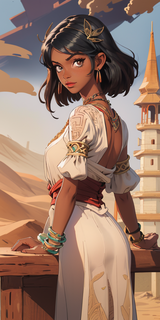
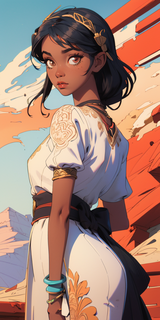
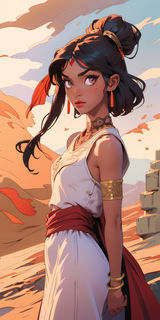

In [ ]:
import json
import os
import zipfile
import base64
import ipywidgets as widgets
from IPython.display import display
import mediapy
from PIL import Image, ImageFile
import glob
import uuid
from google.colab import output, files
from IPython.display import HTML
ImageFile.LOAD_TRUNCATED_IMAGES = True
output.disable_custom_widget_manager()
output.no_vertical_scroll()
count_runs = 0

def escape_html(text):
    """Escapes HTML special characters in the input text."""
    return text.replace("<", "&lt;").replace(">", "&gt;").replace("\n", "<br>")

def extract_metadata(image):
    try:
        metadata_keys = ['metadata', 'prompt', 'Comment', 'parameters']

        for key in metadata_keys:
            if key in image.info:
                return escape_html(image.info[key])

        return str(image.info)

    except Exception as e:
        return f"Error extracting metadata: {str(e)}"

class InvokeButton(object):
    def __init__(self, title, callback):
        self._title = title
        self._callback = callback

    def _repr_html_(self):
        callback_id = 'button-' + str(uuid.uuid4())
        output.register_callback(callback_id, self._callback)

        template = """<button id="{callback_id}">{title}</button>
            <script>
              document.querySelector("#{callback_id}").onclick = (e) => {{
                google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
                e.preventDefault();
              }};
            </script>"""
        html = template.format(title=self._title, callback_id=callback_id)
        return html

def download_archive(path):
    files.download(path)

#@title Simple Gallery Explorer and PNG info { form-width: "20%", display-mode: "form" }

page = 1 # @param {type:"integer"}
page = page if page else 1
number_of_images_per_page = 10 # @param {type:"integer"}

columns = 2 # @param {type:"integer"}
maximum_thumbnail_image_size = 320 # @param {type:"integer"}

folder_where_the_images_are_located = "/content/images/" # @param {type:"string"}
#@markdown It also works with individual images, e.g., `/content/myimage.png`

if os.path.isfile(folder_where_the_images_are_located):
    all_files = [folder_where_the_images_are_located]
elif os.path.isdir(folder_where_the_images_are_located):
    # all_files = glob.glob(os.path.join(folder_where_the_images_are_located, '*.*'))
    all_files = glob.glob(os.path.join(folder_where_the_images_are_located, '**', '*.*'), recursive=True)
else:
    raise ValueError(f"{folder_where_the_images_are_located} does not exist.")

img_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp']
all_images = [
    file for file in all_files if os.path.splitext(file)[1].lower() in img_extensions
]
# all_images.sort()
all_images = sorted(all_images, key=os.path.basename)

images_gallery = []
for i in range((number_of_images_per_page * (page-1)), min((number_of_images_per_page * page), len(all_images))):
    img_gallery = Image.open(all_images[i])
    images_gallery.append([img_gallery, all_images[i]])

# Define your images dictionary with HTML styling for the text
images_rev = {
    f'''
    <div style="border: 1px solid #ccc; border-radius: 8px; padding: 15px; margin: 15px; background-color: #f4ecd8; box-shadow: 0 4px 8px rgba(0,0,0,0.1); max-width: 320px;">
        <span style="font-weight: bold; color: #333; font-size: 12px; font-family: Arial, sans-serif;">{os.path.basename(path_file)}</span>
        <div style="margin-top: 10px;">
            {InvokeButton('Download', lambda path_file=path_file: download_archive(path_file))._repr_html_()}
        </div>
        <details style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #cc5500;">Parameters 👇</summary>
            <p style="font-size: 10px; color: #666;">{extract_metadata(img_gallery)}</p>
        </details>

    </div>
    ''': img_gallery
    for img_gallery, path_file in images_gallery
}

mediapy.show_images(images_rev, border=True, columns=columns, height=maximum_thumbnail_image_size)

def create_zip_file(image_paths, zip_path="images.zip"):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for image_path in image_paths:
            zipf.write(image_path, os.path.basename(image_path))
    return zip_path

def zip_download_archive():
    print("Creating the ZIP file...")
    image_files = [path_file for img_gallery, path_file in images_gallery]

    base_name_start = os.path.splitext(os.path.basename(image_files[0]))[0]
    base_name_end = os.path.splitext(os.path.basename(image_files[-1]))[0]

    zip_name = f"gallery_from_{base_name_start}_to_{base_name_end}.zip"
    initial_zip_path = create_zip_file(image_files, zip_name)

    print("Downloading...")
    download_archive(initial_zip_path)

if images_gallery:
    display(HTML(InvokeButton('Download ZIP 📦', zip_download_archive)._repr_html_()))

In [ ]:
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    AutoProcessor,
    AutoModelForCausalLM,
)
import torch
from abc import ABC, abstractmethod
import os
import gc
import shutil
from PIL import Image
from google.colab import files
import os
import shutil
#@title Image captioning
#@markdown - `Run the cell` and `upload an image`. You'll then receive a detailed description of the image. (You can also specify the directory where your image is located instead of uploading it.)
count_runs = 0

# r3gm datatune section code

IMG_EXTS = (".png", ".jpg", ".jpeg", ".webp", ".tif", ".tiff" ".bmp")

CAPTION_SUFFIX = "caption"

REPOS_FLORENCE = {
    "wd_tagger": "p1atdev/wd-swinv2-tagger-v3-hf",
    "florence PromptGen": "MiaoshouAI/Florence-2-base-PromptGen",
    "florence PromptGen large 2.0": "MiaoshouAI/Florence-2-large-PromptGen-v2.0",  # Instruction: <GENERATE_TAGS>
    "florence Flux": "gokaygokay/Florence-2-Flux",
    "florence Flux large": "gokaygokay/Florence-2-Flux-Large",
    "florence Castollux0.5": "PJMixers-Images/Florence-2-base-Castollux-v0.5",
    "florence nsfw": "ljnlonoljpiljm/florence-2-base-nsfw-v2",
}


def get_dataset_images(dataset):
    images = []
    for root, dirs, files in os.walk(dataset):
        for file in files:
            if file.lower().endswith(IMG_EXTS):
                images.append(os.path.join(root, file))
    return images


def free_mem():
    gc.collect()
    torch.cuda.empty_cache()


def clear_folder(folder_path):
    # os.makedirs(rm_background_folder, exist_ok=True)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)


def setup_datatune_path(datatune_dir: str) -> None:
    """
    Sets up the DATATUNE_DIR environment variable and creates the directory if
    it does not exist.

    Args:
        datatune_dir (str): The path to the directory to be set as
        DATATUNE_DIR.

    Returns:
        None
    """
    datatune_dir = os.path.abspath(datatune_dir)
    os.environ["DATATUNE_DIR"] = datatune_dir
    os.makedirs(datatune_dir, exist_ok=True)


def create_next_folder(id_suffix: str) -> str:
    """
    Creates a new subfolder within the directory specified by the DATATUNE_DIR
    environment variable.
    The new subfolder is named in the format 'subfolder###_id_suffix',
    where ### is a zero-padded
    number representing the next available subfolder index.

    Args:
        id_suffix (str): A string to be appended to the subfolder name.

    Returns:
        str: The path to the newly created subfolder.

    Raises:
        RuntimeError: If the DATATUNE_DIR environment variable is not set.
    """

    datatune_dir = os.getenv("DATATUNE_DIR")
    if not datatune_dir:
        raise RuntimeError("Set a valid DATATUNE_DIR first")

    all_items = os.listdir(datatune_dir)
    directories = [
        im for im in all_items if os.path.isdir(os.path.join(datatune_dir, im))
    ]
    folder_name = f"subfolder{str(len(directories) + 1).zfill(3)}_"

    work_dir = os.path.join(datatune_dir, folder_name + id_suffix)
    os.makedirs(work_dir, exist_ok=True)

    return work_dir


def create_out_path(
    output_folder,
    input_file,
    output_extension=".png",
    suffix=None
):
    if not output_extension.startswith("."):
        output_extension = "." + output_extension

    name_file = os.path.splitext(os.path.basename(input_file))[0]

    if suffix:
        name_file += str(suffix)

    output_file = os.path.join(
        output_folder,
        name_file + output_extension
    )
    return output_file


class BaseConfig(ABC):
    def __init__(self, image_size, class_name, repo_id, processor):
        self.image_size = image_size
        self.class_name = class_name
        self.repo_id = repo_id
        self.processor = processor

    @abstractmethod
    def load_captioner(self):
        pass

    @abstractmethod
    def preprocess(self):
        pass

    @abstractmethod
    def inference(self):
        pass


def _people_tag(noun: str, minimum: int = 1, maximum: int = 5):
    return (
        [f"1{noun}"]
        + [f"{num}{noun}s" for num in range(minimum + 1, maximum + 1)]
        + [f"{maximum+1}+{noun}s"]
    )


PEOPLE_TAGS = (
    _people_tag("girl") + _people_tag("boy") + _people_tag("other") + ["no humans"]
)

RATING_MAP = {
    "general": "safe",
    "sensitive": "sensitive",
    "questionable": "nsfw",
    "explicit": "explicit, nsfw",
}


def postprocess_results(
    results: dict[str, float],
    general_threshold: float,
    character_threshold: float,
):
    results = {
        k: v for k, v in sorted(
            results.items(), key=lambda item: item[1], reverse=True
        )
    }

    rating = {}
    character = {}
    general = {}

    for k, v in results.items():
        if k.startswith("rating:"):
            rating[k.replace("rating:", "")] = v
            continue
        elif k.startswith("character:"):
            character[k.replace("character:", "")] = v
            continue

        general[k] = v

    character = {k: v for k, v in character.items() if v >= character_threshold}
    general = {k: v for k, v in general.items() if v >= general_threshold}

    return rating, character, general


def animagine_prompt(
    rating: list[str], character: list[str], general: list[str]
):
    people_tags: list[str] = []
    other_tags: list[str] = []
    rating_tag = RATING_MAP[rating[0]]

    for tag in general:
        if tag in PEOPLE_TAGS:
            people_tags.append(tag)
        else:
            other_tags.append(tag)

    all_tags = people_tags + character + other_tags + [rating_tag]

    return ", ".join(all_tags)


class WDTaggerConfig(BaseConfig):
    def __init__(self):
        super().__init__(
            512,
            AutoModelForImageClassification,
            "p1atdev/wd-swinv2-tagger-v3-hf",
            AutoImageProcessor,
        )

    def load_captioner(self, device, **kwargs):
        if "repo_id" in kwargs:
            self.repo_id = kwargs.pop("repo_id")

        processor = self.processor.from_pretrained(
            self.repo_id, trust_remote_code=True
        )
        captioner = self.class_name.from_pretrained(
            self.repo_id,
            torch_dtype=torch.float32,
            **kwargs,
        ).to(device)

        return captioner, processor

    def preprocess(self, img_pil, prompt, processor):

        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        return processor.preprocess(img_pil, return_tensors="pt")

    def inference(self, inputs, captioner, processor, **kwargs):

        with torch.no_grad():
            outputs = captioner(**inputs.to(captioner.device, captioner.dtype))
        logits = torch.sigmoid(outputs.logits[0])  # take the first logits

        results = {
            captioner.config.id2label[i]: logit.float() for i, logit in enumerate(logits)
        }
        rating, character, general = postprocess_results(
            results,
            kwargs.get("tag_threshold", 0.35),
            kwargs.get("character_tag_threshold", 0.80),
        )
        generated_text = animagine_prompt(
            list(rating.keys()), list(character.keys()), list(general.keys())
        )

        return generated_text


class FlorenceConfig(BaseConfig):
    def __init__(self):
        super().__init__(
            256,
            AutoModelForCausalLM,
            "MiaoshouAI/Florence-2-base-PromptGen",
            AutoProcessor,
        )
        self.prompt = "<GENERATE_PROMPT>"

    def load_captioner(self, device, **kwargs):
        if "repo_id" in kwargs:
            self.repo_id = kwargs.pop("repo_id")

        processor = self.processor.from_pretrained(
            self.repo_id, trust_remote_code=True
        )
        captioner = self.class_name.from_pretrained(
            self.repo_id,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            trust_remote_code=True,
            **kwargs,
        ).eval().to(device)

        if "flux" in self.repo_id.lower():
            self.prompt = "<DESCRIPTION>"
        elif "Florence-2-base-PromptGen" not in self.repo_id:
            self.prompt = "<MORE_DETAILED_CAPTION>"

        return captioner, processor

    def preprocess(self, img_pil, prompt, processor):

        if self.prompt in [v for v, b in processor.task_prompts_without_inputs.items()]  and "<" not in prompt and ">" not in prompt:
            prompt = None

        if prompt and "<" in prompt and ">" in prompt:
            pass
        elif prompt:
            prompt = self.prompt + prompt
        else:
            prompt = self.prompt

        # print(prompt)

        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        return processor(text=prompt, images=img_pil, return_tensors="pt")

    def inference(self, inputs, captioner, processor, **kwargs):

        with torch.no_grad():
            generated_ids = captioner.generate(
                input_ids=inputs.to(captioner.device, captioner.dtype)["input_ids"],
                pixel_values=inputs.to(captioner.device, captioner.dtype)["pixel_values"],
                max_new_tokens=1024,
                do_sample=False,
                num_beams=3,
                repetition_penalty=1.10,
            )

        generated_text = processor.batch_decode(
            generated_ids, skip_special_tokens=False
        )[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task=self.prompt,
            image_size=kwargs.get("img_size", None),
        )
        generated_text = parsed_answer[self.prompt]

        return generated_text


def get_config(model_type, repo_id):
    if "wd_tagger" in model_type:
        return WDTaggerConfig()
    elif "florence" in model_type:
        return FlorenceConfig()
    else:
        raise ValueError("No valid model_type")


class Captioner:
    def __init__(self, model_type="florence", device=None, **kwargs):
        self.image_size = 128
        self.captioner = None
        self.model_type = ""
        self.device = device if device else (
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.load_model(model_type, **kwargs)

    def load_model(self, model_type, **kwargs):
        # "blip", "wd-tagger", "florence", "llava"

        if self.model_type==[model_type, kwargs.get("repo_id", None)]:
            return None

        print("Loading model...")

        self.cfg = get_config(model_type, repo_id=kwargs.get("repo_id", None))
        self.captioner = self.processor = None
        free_mem()
        self.captioner, self.processor = self.cfg.load_captioner(
            self.device, **kwargs
        )
        self.model_type = [model_type, kwargs.get("repo_id", None)]

    def __call__(self, dataset, prompt=None, **kwargs):
        if not self.captioner:
            raise RuntimeError(
                "Load a model first with captioner.load_model()"
            )

        if not isinstance(dataset, list):
            dataset = [dataset]
        if os.path.isdir(dataset[0]):
            dataset = get_dataset_images(dataset[0])

        output_folder = create_next_folder(CAPTION_SUFFIX)

        captioned_images = []
        for input_image in dataset:

            try:
                img_pil = Image.open(input_image)
                kwargs["img_size"] = (img_pil.width, img_pil.height)
                inputs = self.cfg.preprocess(img_pil, prompt, self.processor)

                generated_text = self.cfg.inference(
                    inputs, self.captioner, self.processor, **kwargs
                )

                if prompt:
                    generated_text = generated_text.replace(prompt, "").strip()

                if not generated_text.strip():
                    raise (f"No valid response for image: {input_image}")

                caption_file = create_out_path(
                    output_folder, input_image, "txt"
                )
                with open(caption_file, "w") as file:
                    file.write(generated_text)

                output_file = create_out_path(output_folder, input_image)
                img_pil.save(output_file, format="PNG")
                captioned_images.append([output_file, generated_text])

                img_pil.close()

            except Exception as e:
                print(e)

        free_mem()

        return captioned_images

Select_an_image_or_directory = "" # @param {type:"string"}
MODEL_CAPTION = "wd_tagger" # @param ["wd_tagger", "florence Flux", "florence Flux large", "florence PromptGen", "florence nsfw" , "florence PromptGen large 2.0", "florence Castollux 0.5"]
TAG_THRESHOLD =  0.35 #@param {type:"slider", min:0, max:1, step:0.01}
CHARACTER_TAG_THRESHOLD = 0.8 #@param {type:"slider", min:0, max:1, step:0.01}
INSTRUCTION = " Describe this image in great detail." # @param {"type":"string"}

setup_datatune_path("/content/cap_img")

if os.path.isdir(Select_an_image_or_directory) or os.path.exists(Select_an_image_or_directory):
    image_paths = Select_an_image_or_directory
else:
    uploaded = files.upload()

    upload_folder_c = 'uploaded_captioner_image/'
    if not os.path.exists(upload_folder_c):
        os.makedirs(upload_folder_c)

    image_paths = []

    for filename in uploaded.keys():
        source_path = filename
        destination_path = os.path.join(upload_folder_c, filename)
        shutil.move(source_path, destination_path)
        image_paths.append(destination_path)

def is_module_installed(module_name):
    import pkgutil
    return pkgutil.find_loader(module_name) is not None

if "florence" in MODEL_CAPTION and not is_module_installed("flash_attn"):
    print("Installing flash attention")
    !pip install --no-build-isolation flash-attn==2.7.3

name_task_cap = "florence" if "florence" in MODEL_CAPTION else MODEL_CAPTION
repo_id_cap = REPOS_FLORENCE[MODEL_CAPTION]

try:
    # del captioner
    captioner
except:
    captioner = Captioner(name_task_cap, repo_id=repo_id_cap)
captioner.load_model(name_task_cap, repo_id=repo_id_cap)

caption_result = captioner(image_paths, prompt=INSTRUCTION, tag_threshold=TAG_THRESHOLD, character_tag_threshold=CHARACTER_TAG_THRESHOLD)

from IPython.display import display, HTML

display(HTML(''.join([
    f'''
    <div style="border: 1px solid #ccc; border-radius: 8px; padding: 15px; margin: 15px; background-color: #f4ecd8; box-shadow: 0 4px 8px rgba(0,0,0,0.1); max-width: 320px;">
        <span style="font-weight: bold; color: #333; font-size: 12px; font-family: Arial, sans-serif;">{img_cap_path}</span>

        <details open style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #cc5500;">Caption 👇</summary>
            <p style="font-size: 15px; color: #666;">{img_caption_text}</p>
        </details>

    </div>
    '''
    for img_cap_path, img_caption_text in caption_result
])))

Saving image005.png to image005.png


In [ ]:
#@title 2. Metadata Viewer
#@markdown ---
#@markdown - **Scan model files (LoRAs, checkpoints, etc.) in a folder or a single file to extract important details from their headers and Civitai metadata.**
from IPython.display import display, HTML
import os, json
import hashlib
from google.colab import output
output.no_vertical_scroll()

def compute_sha256(file_path):
    """Computes the SHA-256 hash of a file."""
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        # Read and update hash string value in chunks to avoid memory issues
        for byte_block in iter(lambda: f.read(1048576), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()


def read_header_from_file(path: str):
    """Read safetensors header from a local file.
    If the file is very small, load entire file into memory instead.
    """
    file_size = os.path.getsize(path)

    with open(path, "rb") as f:
        # Step 1: first 8 bytes → header length
        if file_size >= 8:
            header_len = int.from_bytes(f.read(8), "little")

            # if header_len looks valid
            if 0 < header_len <= file_size - 8:
                header_json = f.read(header_len).decode("utf-8")
                return json.loads(header_json)

        # fallback: load entire file into memory
        f.seek(0)
        data = f.read()
        try:
            return json.loads(data.decode("utf-8"))
        except Exception:
            return None  # not valid JSON / not safetensors


class LoraHeaderInformation:
    """
    Encapsulates parsed info from a LoRA JSON header and provides
    a compact HTML summary via .to_html().
    """

    def __init__(self, json_data):
        self.original_json = copy.deepcopy(json_data or {})

        # Check if text encoder was trained
        # guard for json_data being a mapping
        try:
            self.text_encoder_trained = any("text_model" in ln for ln in json_data)
        except Exception:
            self.text_encoder_trained = False

        # Metadata (may be None)
        metadata = (json_data or {}).get("__metadata__", None)
        self.metadata = metadata

        # Default values
        self.architecture = "undefined"
        self.prediction_type = "undefined"
        self.base_model = "undefined"
        self.author = "undefined"
        self.title = "undefined"
        self.common_tags_list = []

        if metadata:
            self.architecture = MODEL_ARCH.get(
                metadata.get('modelspec.architecture', None),
                "undefined"
            )

            self.prediction_type = metadata.get('modelspec.prediction_type', "undefined")
            self.base_model = metadata.get('ss_sd_model_name', "undefined")
            self.author = metadata.get('modelspec.author', "undefined")
            self.title = metadata.get('modelspec.title', "undefined")

            base_model_hash = metadata.get('ss_new_sd_model_hash', None)  # SHA256

            if base_model_hash:
                self.base_model += f" hash={base_model_hash}"
                try:
                    link_base_model = ModelInformation(request_json_data(base_model_hash))
                    url = f'<a href="{link_base_model.model_url}" target="_blank">civitai link</a>'
                    self.base_model += f" url={url}"
                except:
                    pass
            self.base_model = f"<p>{self.base_model}</p>"

            # Extract tags
            try:
                tags = metadata.get('ss_tag_frequency') if "ss_tag_frequency" in metadata else metadata.get('ss_datasets', "")
                tags = json.loads(tags) if tags else ""

                if isinstance(tags, list):
                    tags = tags[0].get("tag_frequency", {})

                if tags:
                    self.common_tags_list = list(tags[list(tags.keys())[0]].keys())
            except Exception:
                self.common_tags_list = []

    def to_dict(self):
        """Return a plain dict summary of parsed fields."""
        return {
            "title": self.title,
            "author": self.author,
            "architecture": self.architecture,
            "prediction_type": self.prediction_type,
            "base_model": self.base_model,
            "text_encoder_trained": bool(self.text_encoder_trained),
            "common_tags": ", ".join(self.common_tags_list),
        }

    def to_html(self, limit_tags=20):
        """
        Return a compact HTML snippet (string) showing the parsed info
        in a small font. Values are HTML-escaped.
        """
        # helper to escape
        esc = _html.escape

        rows = [
            ("Title", esc(str(self.title))),
            ("Author", esc(str(self.author))),
            ("Architecture", esc(str(self.architecture))),
            ("Base model", esc(str(self.base_model))),
            ("Prediction type", esc(str(self.prediction_type))),
            ("Text encoder trained", esc(str(self.text_encoder_trained))),
            ("Reference tags", esc(str(", ".join(self.common_tags_list[:limit_tags])))),
        ]

        # small, compact table with inline styling (small font)
        html_rows = "".join(
            f"<tr><th style='text-align:left;padding:2px 6px;white-space:nowrap'>{k}</th>"
            f"<td style='padding:2px 6px'>{v}</td></tr>"
            for k, v in rows
        )

        html_snippet = (
            "<div style='font-family:system-ui, -apple-system, \"Segoe UI\", Roboto, "
            "Helvetica, Arial, \"Noto Sans\", sans-serif; font-size:12px; line-height:1.2; "
            "'>"
            f"<table style='border-collapse:collapse; font-size:12px;'>"
            f"{html_rows}"
            "</table>"
            "</div>"
        )

        return html_snippet


# Keys to skip in Parameters
exclude_keys = {"original_json", "images", "info_str"}

DIRECTORY_FILES = "/content/loras"  # @param {type:"string"}

MODEL_EXTENSIONS = ['.onnx', '.ckpt', '.pt', '.pth', '.safetensors', '.bin']
MODEL_ARCH = {
    'stable-diffusion-xl-v1-base/lora': "Stable Diffusion XL (Illustrious, Pony, NoobAI)",
    'stable-diffusion-v1/lora': "Stable Diffusion 1.5",
    'flux-1-dev/lora': "Flux",
}

matching_files = []

if os.path.isfile(DIRECTORY_FILES):
    # It's a file, process only if it matches
    if os.path.splitext(DIRECTORY_FILES)[1].lower() in MODEL_EXTENSIONS:
        matching_files.append(DIRECTORY_FILES)
elif os.path.isdir(DIRECTORY_FILES):
    for f in os.listdir(DIRECTORY_FILES):
        full_path = os.path.join(DIRECTORY_FILES, f)
        if os.path.isfile(full_path) and os.path.splitext(f)[1].lower() in MODEL_EXTENSIONS:
            matching_files.append(full_path)

print("Processing files:")
for fileMV in matching_files:
    F_header = F_header_info = F_sha256 = C_json = C_info = None
    print(fileMV)
    F_header = read_header_from_file(fileMV)
    F_header_info = LoraHeaderInformation(F_header)
    F_sha256 = compute_sha256(fileMV)
    try:
        C_json = request_json_data(F_sha256)
        C_info = ModelInformation(C_json)
    except:
        print("Can't find Civitai info about this model")
        C_info = ModelInformation({})

    # Get first image URL if it exists
    img_url = C_info.images[0] if C_info.images and len(C_info.images) > 0 else ""

    # Get name from original_json and combine with filename
    json_name = ""
    if hasattr(C_info, "original_json") and isinstance(C_info.original_json, dict):
        json_name = C_info.original_json.get("name", "")
    title = f"{json_name} | {os.path.basename(fileMV)}"

    # Convert metadata attributes to lines, excluding some keys
    attr_lines = ''.join([
        f'<div style="font-size: 10px; color: #666; word-wrap: break-word; margin-bottom: 3px;">'
        f'<b>{attr}:</b> {val}</div>'
        for attr, val in vars(C_info).items() if attr not in exclude_keys
    ])

    # Convert original_json to similar style as Parameters
    if hasattr(C_info, "original_json") and C_info.original_json:
        orig_json = C_info.original_json if isinstance(C_info.original_json, dict) else {}
        json_lines = ''.join([
            f'<div style="font-size: 10px; color: #666; word-wrap: break-word; margin-bottom: 3px;">'
            f'<b>{k}:</b> {v}</div>'
            for k, v in orig_json.items()
        ])
        original_json_section = f'''
        <details style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #cc5500;">
                Civitai Info 👇
            </summary>
            {json_lines}
        </details>
        '''
    else:
        original_json_section = ''

    # Convert Header Info to similar style
    if 'F_header_info' in locals() and F_header_info:
        header_dict = F_header_info.to_dict() if hasattr(F_header_info, "to_dict") else {}
        header_lines = ''.join([
            f'<div style="font-size: 10px; color: #666; word-wrap: break-word; margin-bottom: 3px;">'
            f'<b>{k}:</b> {v}</div>'
            for k, v in header_dict.items()
        ])
        header_section = f'''
        <details style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #0077cc;">
                Header Summary 👇
            </summary>
            {header_lines}
        </details>
        '''
    else:
        header_section = ''

    metadata_section = ""
    if 'F_header_info' in locals() and F_header_info and hasattr(F_header_info, "metadata"):
        metadata_dict = F_header_info.metadata if isinstance(F_header_info.metadata, dict) else {}
        if metadata_dict:
            metadata_lines = ''.join([
                f'<div style="font-size: 10px; color: #666; word-wrap: break-word; margin-bottom: 3px;">'
                f'<b>{k}:</b> {v}</div>'
                for k, v in metadata_dict.items()
            ])
            metadata_section = f'''
            <details style="margin-top: 10px;">
                <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #008844;">
                    Header Info 👇
                </summary>
                {metadata_lines}
            </details>
            '''

    # Clickable model URL
    model_url_html = ""
    if hasattr(C_info, "model_url") and C_info.download_url:
        model_url_html = f'''
        <div style="margin-top: 4px;">
            <a href="{C_info.model_url}" target="_blank" style="font-size: 11px; color: #0077cc; text-decoration: underline;">
                Model Link
            </a>
        </div>
        '''

    html_content = f'''
    <div style="border: 1px solid #ccc; border-radius: 8px; padding: 15px; margin: 15px;
                background-color: #f4ecd8; box-shadow: 0 4px 8px rgba(0,0,0,0.1); max-width: 420px;
                word-wrap: break-word; overflow-wrap: break-word;">
        {f'<div style="margin-top: 10px;"><img src="{img_url}" style="width:100%; border-radius: 4px;"></div>' if img_url else ''}
        <span style="display:block; font-weight: bold; color: #333; font-size: 12px; font-family: Arial, sans-serif; margin-top: 8px;">
            {title}
        </span>
        {model_url_html}
        <details style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #cc5500;">
                Civitai Summary 👇
            </summary>
            {attr_lines}
        </details>
        {header_section}
        {original_json_section}
        {metadata_section}
    </div>
    '''
    display(HTML(html_content))

In [ ]:
#@title Download Images
import os
from google.colab import files
!rm /content/results.zip
!ls /content/images
print('Download results')
os.system(f'zip -r results.zip /content/images')
try:
  files.download("results.zip")
except:
  print("Error")

# Extras for advanced users

In [ ]:
# @title Alternative Upscaler Tool
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy import BUILTIN_UPSCALERS, load_upscaler_model
from stablepy.face_restoration.main_face_restoration import (
    load_face_restoration_model,
    process_face_restoration,
)
import os
from PIL import Image
import torch
count_runs = 0

UPSCALER_DICT_GUI = {
    **{bu: bu for bu in BUILTIN_UPSCALERS if bu not in ["None", None]},
    "RealESRNet_x4plus": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/RealESRNet_x4plus.pth",
    "4x-UltraSharp": "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "4x_foolhardy_Remacri": "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "NickelbackFS4x": "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth",
    "HAT_GAN_SRx4": "https://huggingface.co/halffried/gyre_upscalers/resolve/main/hat_ganx4/Real_HAT_GAN_SRx4.safetensors",
    "HAT-L_SRx4": "https://huggingface.co/halffried/gyre_upscalers/resolve/main/hat_lx4/HAT-L_SRx4_ImageNet-pretrain.safetensors",
    "Real-ESRGAN-Anime-finetuning": "https://huggingface.co/danhtran2mind/Real-ESRGAN-Anime-finetuning/resolve/main/Real-ESRGAN-Anime-finetuning.pth",
    "4xNomos8kDAT": "https://huggingface.co/Phips/4xNomos8kDAT/resolve/main/4xNomos8kDAT.safetensors",
    "8x_NMKD-Superscale_150000_G": "https://huggingface.co/lantianhang/8x_NMKD-Superscale_150000_G/resolve/main/8x_NMKD-Superscale_150000_G.pth",
    "4xRealWebPhoto_v4_dat2": "https://huggingface.co/Phips/4xRealWebPhoto_v4_dat2/resolve/main/4xRealWebPhoto_v4.pth",
    "2x-AnimeSharpV4_Fast_RCAN_PU": "https://huggingface.co/Kim2091/2x-AnimeSharpV4/resolve/main/2x-AnimeSharpV4_Fast_RCAN_PU.safetensors",
    "2x-AnimeSharpV4_RCAN": "https://huggingface.co/Kim2091/2x-AnimeSharpV4/resolve/main/2x-AnimeSharpV4_RCAN.safetensors",
    "UltraSharpV2": "https://huggingface.co/Kim2091/UltraSharpV2/resolve/main/4x-UltraSharpV2.safetensors",
}

#@markdown You can leave `Select_an_image` blank to process the last generated images. Compatible with a directory path
Select_an_image = "" # @param {type:"string"}
MODEL_UPSCALER = "R-ESRGAN 4x+ Anime6B" #@param ['ESRGAN_4x', 'DAT x2', 'DAT x3', 'DAT x4', 'HAT x4', 'R-ESRGAN General 4xV3', 'R-ESRGAN General WDN 4xV3', 'R-ESRGAN AnimeVideo', 'R-ESRGAN 4x+', 'R-ESRGAN 4x+ Anime6B', 'R-ESRGAN 2x+', 'ScuNET GAN', 'ScuNET PSNR', 'SwinIR 4x', 'RealESRNet_x4plus', '4x-UltraSharp', '4x_foolhardy_Remacri', 'Remacri4xExtraSmoother', 'AnimeSharp4x', 'lollypop', 'NickelbackFS4x', 'HAT_GAN_SRx4', 'HAT-L_SRx4', 'Real-ESRGAN-Anime-finetuning', '4xNomos8kDAT', '8x_NMKD-Superscale_150000_G', '4xRealWebPhoto_v4_dat2', '2x-AnimeSharpV4_Fast_RCAN_PU', '2x-AnimeSharpV4_RCAN', 'UltraSharpV2']
Scale_of_the_image_x = 1.5 #@param {type:"slider", min:1, max:8, step:0.1}
upscaler_tile_ = 192 #@param {type:"slider", min:0, max:512, step:16}
upscaler_tile_overlap_ = 8 #@param {type:"slider", min:0, max:48, step:1}

face_restoration_ = "Disabled" #@param ["Disabled", "CodeFormer", "GFPGAN", "RestoreFormer"]
face_restoration_visibility_ = 1.0 #@param {type:"slider", min:0, max:1, step:0.01}
face_restoration_weight_ = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

upscaler_half_ = True #@param {type: "boolean"}
show_result_ = True #@param {type: "boolean"}
show_progress_bar_ = True #@param {type: "boolean"}
Upscaled_output_path = "/content/up_images" # @param {type:"string"}

cl_device = "cuda" if torch.cuda.is_available() else "cpu"
directory_upscalers = 'upscalers'
os.makedirs(directory_upscalers, exist_ok=True)

def extract_exif_data(image):
    if image is None:
        return ""

    try:
        metadata_keys = ['parameters', 'metadata', 'prompt', 'Comment']

        for key in metadata_keys:
            if key in image.info:
                return image.info[key]

        return ""

    except Exception as e:
        return f"Error extracting metadata: {str(e)}"

def process_upscale(image, scaler_beta, upscaler_size, show_result, show_progress_bar, exif_image_):
    if image is None:
        return None

    image = image.convert("RGB")

    image_up = scaler_beta.upscale(image, upscaler_size, (not show_progress_bar))

    if show_result:
        display(image_up)

    image_path = save_pil_image_with_metadata(image_up, Upscaled_output_path, exif_image_)

    return image_path

Select_an_imageUP = Select_an_image.strip()
if os.path.exists(Select_an_imageUP):
    if os.path.isfile(Select_an_imageUP):
        image_list = [[0], [Select_an_imageUP], [""]]
    elif os.path.isdir(Select_an_imageUP):
        valid_extsUP = ('.png', '.jpg', '.jpeg', '.webp', '.bmp')
        filesUPdir = [os.path.join(Select_an_imageUP, f) for f in os.listdir(Select_an_imageUP)
                 if f.lower().endswith(valid_extsUP)]
        image_list = [[i for i in range(len(filesUPdir))], filesUPdir, [""] * len(filesUPdir)]

cl_upscale_images, cl_metadata = image_list[1], image_list[2]

# Load face restoration model
if face_restoration_ != "Disabled":
    model_face_res = load_face_restoration_model(face_restoration_, cl_device)

# Load upscaler model
cl_name_upscaler = UPSCALER_DICT_GUI[MODEL_UPSCALER]
if "https://" in str(cl_name_upscaler):
    cl_name_upscaler = download_things(directory_upscalers, cl_name_upscaler, hf_token)

scaler_beta = load_upscaler_model(model=cl_name_upscaler, tile=upscaler_tile_, tile_overlap=upscaler_tile_overlap_, device=cl_device, half=upscaler_half_)

# Infer
for img_base, mdd_base in zip(cl_upscale_images, cl_metadata):
    if isinstance(img_base, str):
        img_base = Image.open(img_base)
    img_base = img_base.convert("RGB")
    exif_image_pre_ = extract_exif_data(img_base)

    if face_restoration_ != "Disabled":
        try:
            img_base = process_face_restoration(
                img_base,
                model_face_res,
                face_restoration_visibility_,
                face_restoration_weight_
            )
        except Exception as e:
            print(str(e))

    image_path_ = process_upscale(img_base, scaler_beta, Scale_of_the_image_x, show_result_, show_progress_bar_, exif_image_pre_)
    print(image_path_)

del scaler_beta

In [ ]:
# You can also use this cell to simply reload the model in case you need to.
del model

In [ ]:
# If the generate button is disabled
generate.disabled = False

In [ ]:
# If you encounter a problem with "Out Of Memory," you can click on this cell and rerun cells 2 and 3.
import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Select an image 👈‍‍ 🖼️🖼️🖼️
#@markdown - To use Img2Img, Inpainting, or ControlNet, specify the image path in this cell. You can also use a directory of images.
count_runs = 0

Select_an_image_or_directory_and_run_the_cell = "" # @param {type:"string"}
Image_mask_path_optional = "" # @param {type:"string"}
destination_path_cn_img = Select_an_image_or_directory_and_run_the_cell
img_tsk.value = destination_path_cn_img
if Image_mask_path_optional and os.path.exists(Image_mask_path_optional):
    mask_inpaint_gui.value = Image_mask_path_optional

In [ ]:
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy import Preprocessor, ALL_PREPROCESSOR_TASKS
from google.colab import files

#@markdown # Preprocessor Tool
#@markdown You can leave `Select_an_image` blank to upload images. Compatible with a directory path

Select_an_image = "" # @param {type:"string"}
PREPROCESSOR_ = "Canny" #@param [ "Canny", "Openpose", "DPT", "Midas", "ZoeDepth", "DepthAnything", "HED", "PidiNet", "TEED", "Lineart", "LineartAnime", "Anyline", "Lineart standard", "SegFormer", "UPerNet", "ContentShuffle", "Recolor", "Blur", "MLSD", "NormalBae" ]
final_image_resolution_ = 1024 #@param {type:"slider", min:64, max:2048, step:64}
detector_resolution_ = 512 #@param {type:"slider", min:64, max:2048, step:64}
use_cuda_ = True #@param {type: "boolean"}
show_result_ = True #@param {type: "boolean"}

CANNY_low_threshold=100 #@param {type:"slider", min:1, max:255, step:1}
CANNY_high_threshold=200 #@param {type:"slider", min:1, max:255, step:1}
MLSD_thr_v=0.1 #@param {type:"slider", min:0.1, max:2, step:0.01}
MLSD_thr_d=0.1 #@param {type:"slider", min:0.1, max:20, step:0.01}
RECOLOR_mode= "luminance" #@param ["luminance", "intensity"]
RECOLOR_gamma_correction=1 #@param {type:"slider", min:0.0, max:25, step:0.01}
BLUR_sigma=9 #@param {type:"slider", min:0, max:100, step:1}
OPENPOSE_hand_and_face=True #@param {type: "boolean"}
HED_scribble=True #@param {type: "boolean"}
PIDINET_safe=True #@param {type: "boolean"}
LINEART_coarse=True #@param {type: "boolean"}

valid_extsUP = ('.png', '.jpg', '.jpeg', '.webp', '.bmp')
path_img_pp = Select_an_image.strip()
if os.path.exists(path_img_pp):
    if os.path.isdir(path_img_pp):
        file_names_pp = [
            os.path.join(path_img_pp, f)
            for f in os.listdir(path_img_pp)
            if os.path.isfile(os.path.join(path_img_pp, f)) and os.path.splitext(f)[1].lower() in valid_extsUP
        ]
    else:
        file_names_pp = [path_img_pp]
else:
    uploaded = files.upload()
    file_names_pp = list(uploaded.keys())

try:
    preprocessor
except:
    preprocessor = Preprocessor()

preprocessor.load(PREPROCESSOR_, use_cuda=use_cuda_)

for imgpp in file_names_pp:
    res_pp = preprocessor(
        image=imgpp,
        image_resolution=final_image_resolution_,  # The final proportional resolution based on the provided image
        detect_resolution=detector_resolution_,  # The resolution at which the detector will perform the inference

        low_threshold=CANNY_low_threshold,
        high_threshold=CANNY_high_threshold,
        thr_v=MLSD_thr_v,
        thr_d=MLSD_thr_d,
        mode=RECOLOR_mode,
        gamma_correction=RECOLOR_gamma_correction,
        blur_sigma=BLUR_sigma,
        hand_and_face=OPENPOSE_hand_and_face,
        scribble=HED_scribble,
        safe=PIDINET_safe,
        coarse=LINEART_coarse,
        )

    print(f"Image resolution: {res_pp.width}x{res_pp.height}")

    if show_result_:
        display(res_pp)

    image_path_pp = save_pil_image_with_metadata(res_pp, f'{os.getcwd()}/preprocessor_images', "")
    print(image_path_pp)

In [ ]:
from PIL import Image
import os, torch, gc
count_runs = 0
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy.diffusers_vanilla.extra_model_loaders import custom_task_model_loader

torch.cuda.empty_cache()
gc.collect()

detailfix_pipe = custom_task_model_loader(
    pipe=model.pipe,
    model_category="detailfix", # inpaint_only = True
    task_name=select_task.label,
    torch_dtype=model_precision.value,
    load_text_encoder=True,
)
detailfix_pipe.to("cuda" if torch.cuda.is_available() else "cpu")
# same scheduler as base pipe

# OPTIONS #
# @markdown # Adetailer (inpaint only)
# @markdown This will use the parameters and the loaded model of the GUI.
Select_an_image = "" # @param {type:"string"}
prompt_ad = "masterpiece, best quality, extremely detailed wallpaper" # @param {type:"string"}
negative_prompt_ad = "worst quality, normal quality, low quality, low res, blurry, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch ,duplicate, ugly, monochrome, horror, geometry, mutation, disgusting" # @param {type:"string"}
strength_ad = 0.4 # @param {type:"number"}
face_detector_ad = True # @param {type:"boolean"}
person_detector_ad = False # @param {type:"boolean"}
hand_detector_ad = False # @param {type:"boolean"}
mask_dilation = 4 # @param {type:"integer"}
mask_blur = 4 # @param {type:"integer"}
mask_padding = 32 # @param {type:"integer"}

detailfix_params__ = {
    "prompt": prompt_ad,
    "negative_prompt" : negative_prompt_ad,
    "strength" : strength_ad,
    "num_inference_steps": steps.value,
    "guidance_scale" : CFG.value,
}
adetailer_params__ = {
    "face_detector_ad" : face_detector_ad,
    "person_detector_ad" : person_detector_ad,
    "hand_detector_ad" : hand_detector_ad,
    #"inpaint_only" : True,
    # "image_list_task" : None,
    "mask_dilation" : mask_dilation,
    "mask_blur" : mask_blur,
    "mask_padding" : mask_padding,
}

# PROCESS AD
if os.path.exists(Select_an_image):
    image_list = [[0], [Select_an_image], [""]]

image_pil_list = []
for path in image_list[1]:
    if os.path.exists(path):
        # Open the image using PIL and convert it to PIL.Image.Image
        with Image.open(path) as img:
            image_ad = img.convert("RGB")
            image_pil_list.append(image_ad)

ad_pil_list = ad_model_process(
    pipe_params_df=detailfix_params__,
    detailfix_pipe=detailfix_pipe,
    image_list_task=image_pil_list,
    **adetailer_params__,
)

for img_ad in ad_pil_list:
    display(img_ad)
    image_path = save_pil_image_with_metadata(img_ad, f'{os.getcwd()}/images', "")
    print(image_path)

del detailfix_pipe
torch.cuda.empty_cache()
gc.collect()
print("")

In [ ]:
# @title Alternative generation
# @markdown Sometimes the GUI gets stuck when multiple operations are run. Once the GUI is loaded, you can use this cell to generate images here as an alternative.

output.disable_custom_widget_manager()
output.no_vertical_scroll()
extra_msg_status = 0
count_runs = 0

def generate_img_beta():
    global model

    print("Loading model...")

    # First load
    with torch.no_grad():
        try:
            model
        except:
            model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)

        try:
            model.load_pipe(select_model.value, task_name=select_task.value, vae_model=(vae_model_dropdown.value if vae_model_dropdown.value != "BakedVAE" else select_model.value), type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task.value, controlnet_model=controlnet_model_gui.value)
        except Exception as error:
            check_error(error)

    display_imgs.clear_output()

    model.advanced_params(img_prep_cuda.value, partial_cpu_offload.value, disable_embed_cache.value, disable_prepcache.value)

    global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config, extra_msg_status

    image_control_base = None
    if select_task.value != job_lst[13]:
        if os.path.exists(img_tsk.value):
            image_control_base = img_tsk.value
        else:
            try:
                image_control_base = destination_path_cn_img
            except Exception as e:
                # print(e)
                print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
                generate.disabled = False
                return
        if os.path.isdir(image_control_base):
            import glob
            control_imgf = image_control_base
            _all_files = glob.glob(os.path.join(control_imgf, '**', '*.*'), recursive=True)
            img_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp']
            _all_images = [
                file for file in _all_files if os.path.splitext(file)[1].lower() in img_extensions
            ]
            image_control_base = sorted(_all_images, key=os.path.basename)
            print(f"Found {len(image_control_base)} images in folder {control_imgf}")

    mask_control_base = ""
    if select_task.value in [control_model_list[12], control_model_list[23]]:
        if os.path.exists(mask_inpaint_gui.value):
            mask_control_base = mask_inpaint_gui.value
        else:
            try:
                mask_control_base = mask_control
            except:
                print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                generate.disabled = False
                return

    if "https://" not in str(upscaler_dict_gui[upscale_gui.value]):
        upscaler_model = upscale_gui.value
    else:
        url_upscaler = upscaler_dict_gui[upscale_gui.value]
        download_things(directory_upscalers, url_upscaler, hf_token)
        upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

    if extra_msg_status<3:
        if model.class_name == "StableDiffusionPipeline" and not vae_model_dropdown.value:
            print("It is advisable to use a VAE with SD 1.5, such as 'vae-ft-mse-840000-ema-pruned_fp16'")
            extra_msg_status += 1
        elif model.class_name == "StableDiffusionXLPipeline" and vae_model_dropdown.value and "vae-ft-mse-840000-ema-pruned_fp16" in vae_model_dropdown.value:
            print("The VAE 'vae-ft-mse-840000-ema-pruned_fp16' is for SD 1.5, but you are using SDXL.")
            extra_msg_status += 1
    logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

    count_runs += 1
    if count_runs%11 == 0 and count_runs != 0:
        print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Simple Gallery Explorer', to prevent any inconvenience from disconnection due to inactivity.")

    params_ip_img = []
    params_ip_msk = []
    params_ip_model = []
    params_ip_mode = []
    params_ip_scale = []

    all_adapters = [
        (ipa_img0, ipa_mask0, ipa_model0, ipa_mode0, ipa_scale0),
        (ipa_img1, ipa_mask1, ipa_model1, ipa_mode1, ipa_scale1),
        (ipa_img2, ipa_mask2, ipa_model2, ipa_mode2, ipa_scale2),
    ]

    for imgip, mskip, modelip, modeip, scaleip in all_adapters:
        if imgip.value:
            ip_list = [ipi.strip() for ipi in imgip.value.split(",") if ipi.strip()]
            ipmsk_list = [ipm.strip() for ipm in mskip.value.split(",") if ipm.strip()]
            params_ip_img.append(ip_list)
            params_ip_msk.append(ipmsk_list)
            params_ip_model.append(modelip.value)
            params_ip_mode.append(modeip.value)
            params_ip_scale.append(scaleip.value)

    adetailer_params_A = dict(
        face_detector_ad=face_detector_ad_A.value,
        person_detector_ad=person_detector_ad_A.value,
        hand_detector_ad=hand_detector_ad_A.value,
        prompt=prompt_ad_A.value,
        negative_prompt=negative_prompt_ad_A.value,
        strength=strength_ad_A.value,
        mask_dilation=mask_dilation_A.value,
        mask_blur=mask_blur_A.value,
        mask_padding=mask_padding_A.value,
        inpaint_only=adetailer_inpaint_only.value,
        sampler=adetailer_sampler.value,
        custom_model_path=custom_model_path_A.value,
    )
    adetailer_params_B = dict(
        face_detector_ad=face_detector_ad_B.value,
        person_detector_ad=person_detector_ad_B.value,
        hand_detector_ad=hand_detector_ad_B.value,
        prompt=prompt_ad_B.value,
        negative_prompt=negative_prompt_ad_B.value,
        strength=strength_ad_B.value,
        mask_dilation=mask_dilation_B.value,
        mask_blur=mask_blur_B.value,
        mask_padding=mask_padding_B.value,
        custom_model_path=custom_model_path_B.value,
    )
    pipe_params = dict(
        prompt=prompt.value,
        negative_prompt=neg_prompt.value,
        img_height=img_height.value,
        img_width=img_width.value,
        num_images=num_images.value,
        num_steps=steps.value,
        guidance_scale=CFG.value,
        clip_skip=select_clip_skip.value,
        seed=random_seed.value,
        image=image_control_base,
        preprocessor_name=base_preprocessor.value,
        preprocess_resolution=prep_res_global.value,
        image_resolution=img_res_gl.value,
        style_prompt=style_names_multi_selection.value,
        style_json_file="",
        pag_scale=pag_scale.value,
        image_mask=mask_control_base,
        strength=strength_gui.value,
        low_threshold=canny_low.value,
        high_threshold=canny_high.value,
        value_threshold=mlsd_value.value,
        distance_threshold=mlsd_distance.value,
        recolor_gamma_correction=gamma_correction.value,
        tile_blur_sigma=tile_blur_sigma_gui.value,
        lora_A=select_lora1.value,
        lora_scale_A=lora_weights_scale1.value,
        lora_B=select_lora2.value,
        lora_scale_B=lora_weights_scale2.value,
        lora_C=select_lora3.value,
        lora_scale_C=lora_weights_scale3.value,
        lora_D=select_lora4.value,
        lora_scale_D=lora_weights_scale4.value,
        lora_E=select_lora5.value,
        lora_scale_E=lora_weights_scale5.value,
        lora_F=select_lora6.value,
        lora_scale_F=lora_weights_scale6.value,
        lora_G=opt_preset_main.class_optimization_lora_path(select_lora7.value, model),
        lora_scale_G=lora_weights_scale7.value,
        textual_inversion=filter_valid_embed(embed_list, model, prompt.value, neg_prompt.value, active_ti.value),
        syntax_weights=weights_prompt.value,
        sampler=select_sampler.value,
        schedule_type=select_scheduler.value,
        schedule_prediction_type=select_sampling_type.value,
        xformers_memory_efficient_attention=xformers_attn.value,
        gui_active=True,
        loop_generation=loop_generator.value,
        controlnet_conditioning_scale=cn_outscale.value,
        control_guidance_start=cn_start.value,
        control_guidance_end=cn_stop.value,
        generator_in_cpu=init_generator_in_cpu.value,
        FreeU=freeu_check.value,
        adetailer_A=adetailer_active_A.value,
        adetailer_A_params=adetailer_params_A,
        adetailer_B=adetailer_active_B.value,
        adetailer_B_params=adetailer_params_B,
        leave_progress_bar=True,
        disable_progress_bar=disable_progress_bar_check.value,
        image_previews=False,
        display_images=display_images.value,
        image_display_scale=image_display_scale.value,
        save_generated_images=save_generated_images.value,
        image_storage_location=image_directory.value,
        filename_pattern=filename_pattern_gui.value,
        retain_compel_previous_load=retain_compel.value,
        retain_detailfix_model_previous_load=retain_dtl.value,
        retain_hires_model_previous_load=retain_hires.value,
        t2i_adapter_preprocessor=t2i_prepcheck.value,
        t2i_adapter_conditioning_scale=t2i_scale.value,
        t2i_adapter_conditioning_factor=t2i_fact.value,
        upscaler_model_path=upscaler_model,
        upscaler_increases_size=upscaler_size.value,
        upscaler_tile_size=upscaler_tile_size.value,
        upscaler_tile_overlap=upscaler_tile_overlap.value,
        hires_steps=hires_steps.value,
        hires_denoising_strength=hires_denoise.value,
        hires_prompt=hires_prompt.value,
        hires_negative_prompt=hires_negative_prompt.value,
        hires_sampler=hires_sampler.value,
        hires_schedule_type=hires_schedtype.value,
        hires_guidance_scale=hires_guid_scale.value,
        hires_before_adetailer=hires_before.value,
        hires_after_adetailer=hires_after.value,
        ip_adapter_image=params_ip_img,
        ip_adapter_mask=params_ip_msk,
        ip_adapter_model=params_ip_model,
        ip_adapter_mode=params_ip_mode,
        ip_adapter_scale=params_ip_scale,
        face_restoration_model=face_restoration_model.value,
        face_restoration_visibility=face_vis.value,
        face_restoration_weight=face_weight.value,
    )

    if guidance_rescale.value:
        pipe_params["guidance_rescale"] = guidance_rescale.value

    if show_params.value:
        print(pipe_params)

    if client_loop_auto_submit_gui.value:
        if client_hf_params_gui.value:
            client_upload_base = HFUpload(client_hf_params_gui.value)
        else:
            client_upload_base = Litterbox(client_expire.value)

    if wm_generator_type_gui.value == "Disabled" and not isinstance(image_control_base, list):
        if client_loop_auto_submit_gui.value and loop_generator.value > 1:
            print("Link downloads doesn’t support internal loops 🔁.\nTo work around this, choose 'Random' in 'Wildcards and Dynamic Prompts'\nand use the 'Maximum number of prompt loops 🔁' instead")
        try:
            with torch.inference_mode():
                images, image_list = model(**pipe_params)
        except Exception as error:
            check_error(error, pipe_params)

        if show_gen_data.value:
            print(image_list[2][-1])

        if auto_download_img_gui.value:
            for iim in image_list[1]:
                if os.path.exists(iim):
                    download_fix_colab(iim)

        if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
            upload_images_or_rar(image_list[1], client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
    else:
        wmanager = WildcardManager(WILDCARD_DIRECTORY)
        wm_prompts_out = gen_dyn_prompts(
            wm_generator_type_gui.value,
            wmanager,
            prompt.value,
            wm_maxloops.value,
            wm_index_combinatorial_gui.value,
        )
        if isinstance(image_control_base, list):
            wm_prompts_out = stretch_list(wm_prompts_out, len(image_control_base))

        vari_paramA = generate_extra_pp_data(
            wm_extra_ppA.value,
            wm_optsa.value,
        )
        vari_paramB = generate_extra_pp_data(
            wm_extra_ppB.value,
            wm_optsb.value,
        )
        if vari_paramA and vari_paramB:
            keyA_, valuesA_ = list(vari_paramA.items())[0]
            keyB_, valuesB_ = list(vari_paramB.items())[0]
            if keyA_ == keyB_:
                extra_pp_data = {keyA_: valuesA_}
                print("If both variable parameters are set to the same, only the first will be used.")
            else:
                extra_pp_data = {
                    keyA_: [a for a in valuesA_ for _ in valuesB_],
                    keyB_: valuesB_ * len(valuesA_)
                }
        else:
            extra_pp_data = vari_paramA if vari_paramA else vari_paramB
        if extra_pp_data:
            extra_pp_data = {k: v * len(wm_prompts_out) for k, v in extra_pp_data.items()}

        print(f"Generating prompts in {len(wm_prompts_out)} loop(s)...")
        all_images_submit = []
        for nx, wm_prompt_item in enumerate(wm_prompts_out):
            try:
                if isinstance(image_control_base, list):
                    pipe_params["image"]=image_control_base[nx]
                    print(f"Control image: {pipe_params['image']}")
                elif use_lastimg.value and nx>0:
                    pipe_params["image"]=images[-1]
                with torch.inference_mode():
                    if extra_pp_data:
                        print(" & ".join(f"\033[38;5;34m{key0.upper()}: {extra_pp_data[key0][nx]}\033[0m" for key0 in extra_pp_data.keys()))
                    images, image_list = model(
                        **{
                            ok1: ov1 for ok1, ov1 in pipe_params.items() if ok1 not in ["prompt", "loop_generation", "filename_pattern"] + list(extra_pp_data.keys())
                        },
                        prompt=wm_prompt_item,
                        loop_generation=1,
                        filename_pattern=pipe_params["filename_pattern"].replace("DYNAMIC", "_".join(str(extra_pp_data[key0][nx]) for key0 in extra_pp_data.keys())),
                        **{k:v[nx] for k, v in extra_pp_data.items()},
                    )
            except Exception as error:
                check_error(error, pipe_params)

            if show_gen_data.value:
                print(image_list[2][-1])

            if auto_download_img_gui.value:
                for iim in image_list[1]:
                    if os.path.exists(iim):
                        download_fix_colab(iim)

            if os.path.exists(image_list[1][0]) and client_loop_auto_submit_gui.value:
                all_images_submit += image_list[1]
                if len(all_images_submit) >= client_loop_auto_submit_gui.value or nx == len(wm_prompts_out)-1:
                    upload_images_or_rar(all_images_submit, client_upload_base, client_rarpass.value, rar_folder, client_backup_links.value)
                    all_images_submit = []

    generate.disabled = False

    if save_and_load_config:
        save_config_params(pipe_params)

    torch.cuda.empty_cache()
    gc.collect()

    return

generate_img_beta()

In [ ]:
import os
from huggingface_hub import HfApi
import tempfile
from typing import Optional, Union
import random
import string
count_runs = 0

#@title Submit the images to your Hugging Face repository (Need an account on Hugging Face) { form-width: "20%", display-mode: "form" }
#@markdown Basically, this allows you to use a repository on Hugging Face to store whatever you want. In this case, we want to use the repository to store our generated images

#@markdown ---
#@markdown **Specify the folder of the images you will upload and the destination folder in the repository**
folder_in_notebook = "images" # @param {type:"string"}
folder_in_repo = "images_24_11_23" # @param {type:"string"}
#@markdown ---
#@markdown **Select the destination repository from your account; if it doesn't exist, it will be created. Example: `your_username/random_name_repo`**
repo_id = "" # @param {type:"string"}
private_repo = True # @param {type:"boolean"}
#@markdown **To be able to use your repository, you need a token with write permissions. You can get it here: https://huggingface.co/settings/tokens.**
token = "" # @param {type:"string"}

api = HfApi()
api.create_repo(
    repo_id = repo_id,
    repo_type = "dataset",
    private = private_repo,
    exist_ok = True,
    token = token,
)

api.upload_folder(
    folder_path=folder_in_notebook,
    path_in_repo=folder_in_repo,
    repo_id=repo_id,
    token= token,
    repo_type="dataset",
    #ignore_patterns="**/logs/*.txt",
)

print(f"https://huggingface.co/datasets/{repo_id}/tree/main/{folder_in_repo}")

In [ ]:
# @title Select a style file for the loaded model
import os

style_file = "sdxl_styles" # @param ["sdxl_styles", "sdxl_styles_sai", "sdxl_styles_twri"] {type:"string"}

styles_dict_p = {
    "sdxl_styles" : "https://raw.githubusercontent.com/ahgsql/StyleSelectorXL/main/sdxl_styles.json",
    "sdxl_styles_sai" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_sai.json",
    "sdxl_styles_twri" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_twri.json",
}

url = styles_dict_p[style_file]
!wget {url} -q

model.load_style_file(os.path.basename(url))
style_names_multi_selection.options = model.STYLE_NAMES
print("New styles set in the GUI")

In [ ]:
# @markdown #### or submit and load a style file in the model (json format) [PromptStylers](https://github.com/wolfden/ComfyUi_PromptStylers), [sdxl_prompt_styler](https://github.com/ali1234/sdxl_prompt_styler/tree/main)
from google.colab import files

uploaded = files.upload()
file_names = list(uploaded.keys())

if file_names[0].endswith('.json'):
    model.load_style_file(file_names[0])
    style_names_multi_selection.options = model.STYLE_NAMES
    print("New styles set in the GUI")
else:
    print("Error: Need a json file")

In [ ]:
#@title Codeformer: Upscale and face restoration { form-width: "20%", display-mode: "form" }
from IPython.utils import capture
import os
import shutil
count_runs = 0

%cd /content
directory_codeformer = '/content/CodeFormer/'
with capture.capture_output() as cap:
  if not os.path.exists(directory_codeformer):
      os.makedirs(directory_codeformer)

      # Setup
      # Clone CodeFormer and enter the CodeFormer folder
      %cd /content
      !git clone https://github.com/sczhou/CodeFormer.git
      %cd CodeFormer


      # Set up the environment
      # Install python dependencies
      !pip install -q -r requirements.txt
      !pip -q install ffmpeg
      # Install basicsr
      !python basicsr/setup.py develop

      # Download the pre-trained model
      !python scripts/download_pretrained_models.py facelib
      !python scripts/download_pretrained_models.py CodeFormer
  del cap
# Visualization function
import cv2
import matplotlib.pyplot as plt
def display_codeformer(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Copy imgs
Select_an_image = "" # @param {type:"string"}

# PROCESS AD
if os.path.exists(Select_an_image.strip()):
    image_list = [[0], [Select_an_image.replace('/content/', '').strip()], [""]]

destination_directory = '/content/CodeFormer/inputs/user_upload'
!rm -rf /content/CodeFormer/inputs/user_upload/*
os.makedirs(destination_directory, exist_ok=True)
for image_path in image_list[1]:
    image_filename = os.path.basename('/content/'+image_path)
    destination_path = os.path.join(destination_directory, image_filename)
    try:
        shutil.copyfile('/content/'+image_path, destination_path)
        print(f"Image '{image_filename}' has been copied to '{destination_path}'")
    except Exception as e:
        print(f"Failed to copy '{image_filename}' to '{destination_path}': {e}")

#@markdown `CODEFORMER_FIDELITY`: Balance the quality (lower number) and fidelity (higher number)<br>
# you can add '--bg_upsampler realesrgan' to enhance the background
CODEFORMER_FIDELITY = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = False #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = True #@param {type:"boolean"}
#markdown `HAS_ALIGNED`: Input are cropped and aligned faces<br>
HAS_ALIGNED =  False
#@markdown `UPSCALE`: The final upsampling scale of the image. Default: 2<br>
UPSCALE = 1 #@param {type:"slider", min:1, max:8, step:1}
#markdown `DETECTION_MODEL`: Face detector. Default: retinaface_resnet50<br>
DETECTION_MODEL = "retinaface_resnet50"
#markdown `DRAW_BOX`: Draw the bounding box for the detected faces.
DRAW_BOX = False

BACKGROUND_ENHANCE = '--bg_upsampler realesrgan' if BACKGROUND_ENHANCE else ''
FACE_UPSAMPLE = '--face_upsample' if FACE_UPSAMPLE else ''
HAS_ALIGNED = '--has_aligned' if HAS_ALIGNED else ''
DRAW_BOX = '--draw_box' if DRAW_BOX else ''
%cd CodeFormer
!python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path {destination_directory} {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}


import os
import glob

input_folder = 'inputs/user_upload'
result_folder = f'results/user_upload_{CODEFORMER_FIDELITY}/final_results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  basename = os.path.splitext(os.path.basename(input_path))[0]
  output_path = os.path.join(result_folder, basename+'.png')
  img_output = imread(output_path)
  display_codeformer(img_input, img_output)

%cd /content

Upscale results in /content/CodeFormer/results


In [ ]:
#@title Download Upscale results
import os
from google.colab import files
import shutil
%cd /content/CodeFormer
!ls results
print('Download results')
os.system(f'zip -r results.zip results/user_upload_{CODEFORMER_FIDELITY}/final_results')
try:
  files.download("results.zip")
except:
  files.download(f'/content/CodeFormer/results/{filename[:-4]}_{CODEFORMER_FIDELITY}/{filename}')
%cd /content

In [ ]:
# @markdown CONVERT SAFETENSORS TO DIFFUSERS
path_safetensor_model = "" # @param {type:"string"}
path_diffusers_model = "./converted_model/" # @param {type:"string"}

from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_single_file(path_safetensor_model).to("cuda")
pipe.save_pretrained(path_diffusers_model) # model path inpaint is ./adetailer_model/
del pipe
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from stablepy import logger
Verbosity_Level = "INFO" # @param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]
import logging, warnings, diffusers

logging_level_mapping = {
    'DEBUG': logging.DEBUG,
    'INFO': logging.INFO,
    'WARNING': logging.WARNING,
    'ERROR': logging.ERROR,
    'CRITICAL': logging.CRITICAL
}

if Verbosity_Level != "DEBUG":
    logging.getLogger("diffusers").setLevel(logging.ERROR)
    diffusers.utils.logging.set_verbosity(40)
    #warnings.resetwarnings()
    warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
else:
    logging.getLogger("diffusers").setLevel(logging.INFO)
    diffusers.utils.logging.set_verbosity(30)
    warnings.filterwarnings(action="default", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="default", category=UserWarning, module="diffusers")

logger.setLevel(logging_level_mapping.get(Verbosity_Level, logging.NOTSET))